# Importing libraries

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
import astropy.time as at
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload
import itertools
import scipy.odr as so
import scipy.stats as ss
from scipy.interpolate import interp1d

# Defining Useful variables

In [2]:
days = ['2023-01-20', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', 
        '2023-01-25', '2023-01-26', '2023-01-27', '2023-02-01', '2023-02-02', '2023-02-03']
new = True

blaze_dir = 'Blaze-data'
dir_name = 'Corr-data'
CCF_dir_name = 'CCF_RV-data'
HARPS_directory = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/new_Solar-data/'
fit_params_dict = {}
fit_params_Si_dict = {}
fit_params_T_dict = {}
fit_err_dict = {}
fit_err_Si_dict = {}
fit_err_T_dict = {}
time_dict = {}

# Extracting, reducing the data
# Fitting line + plotting periodogram (He triplet + Si line + Water line)

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


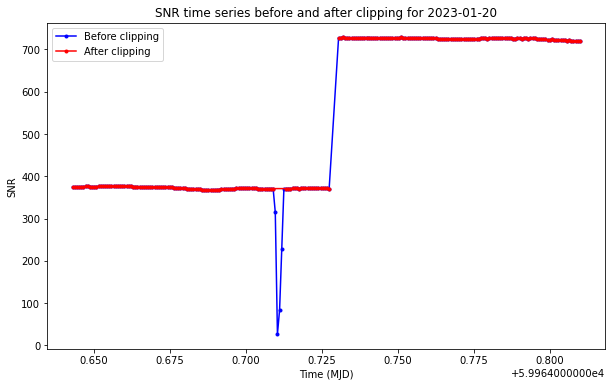

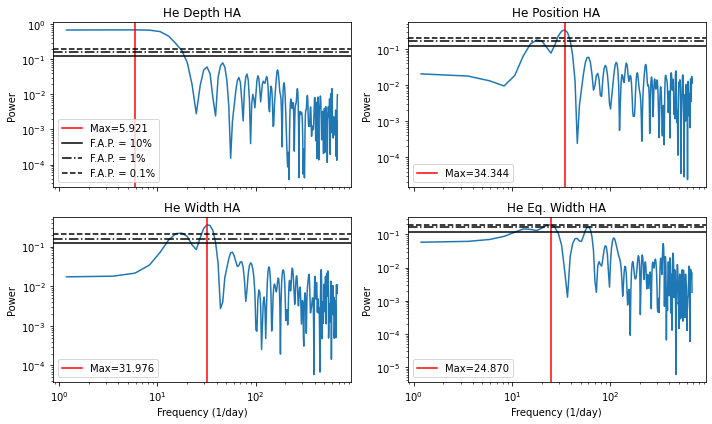

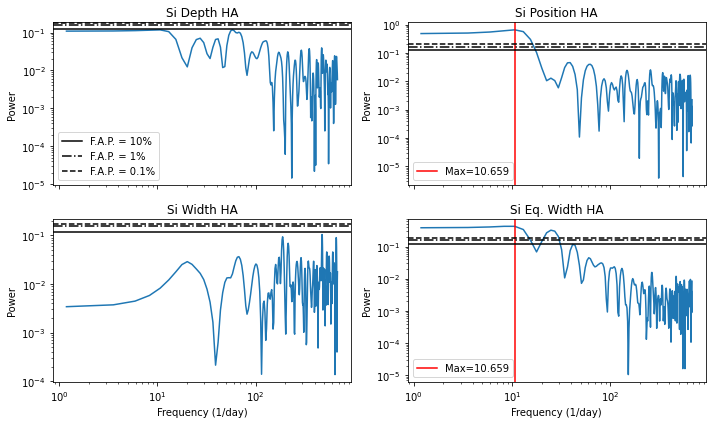

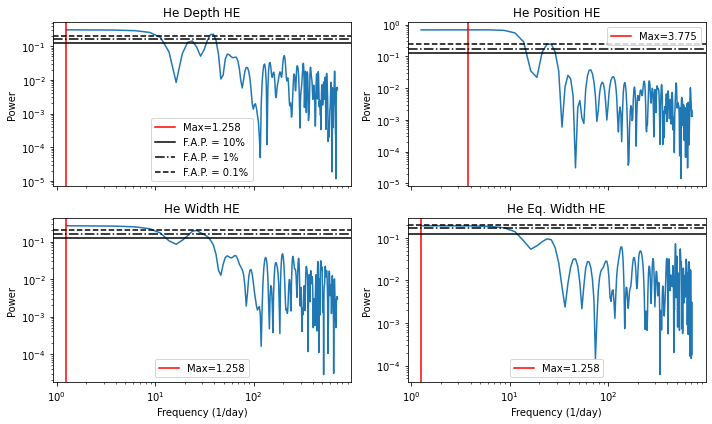

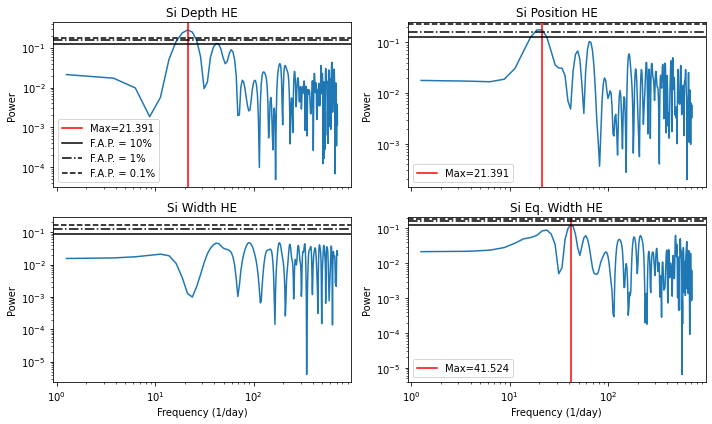

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


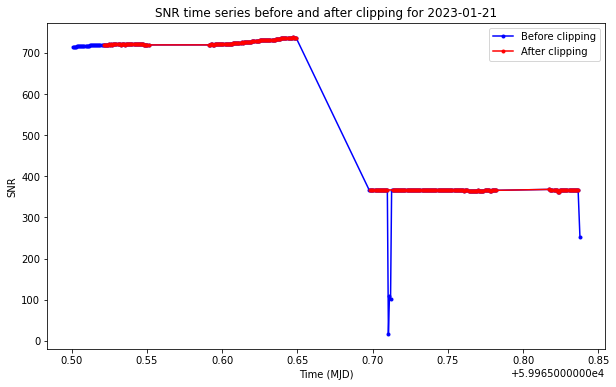

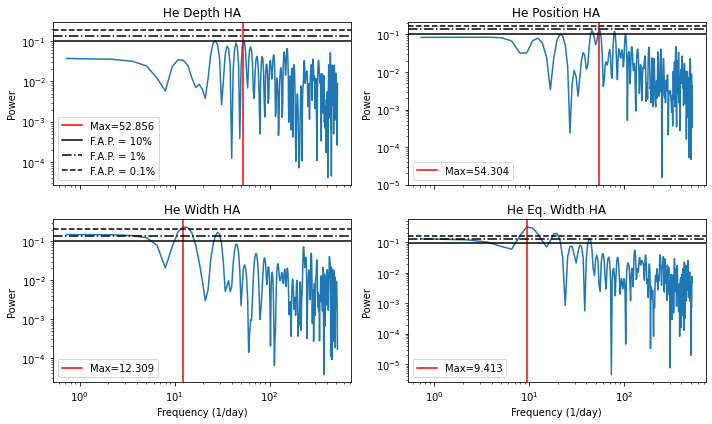

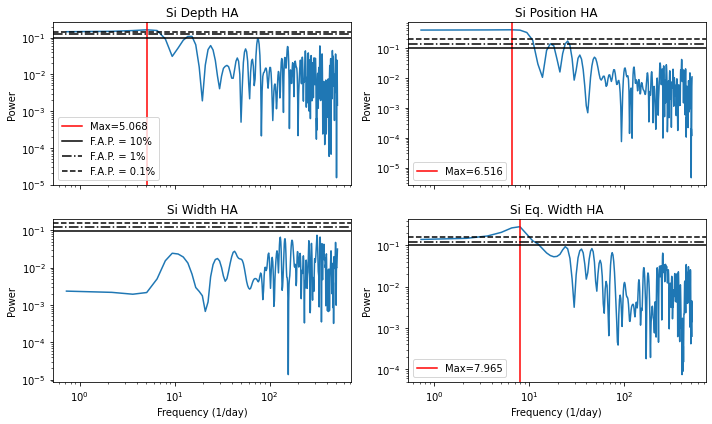

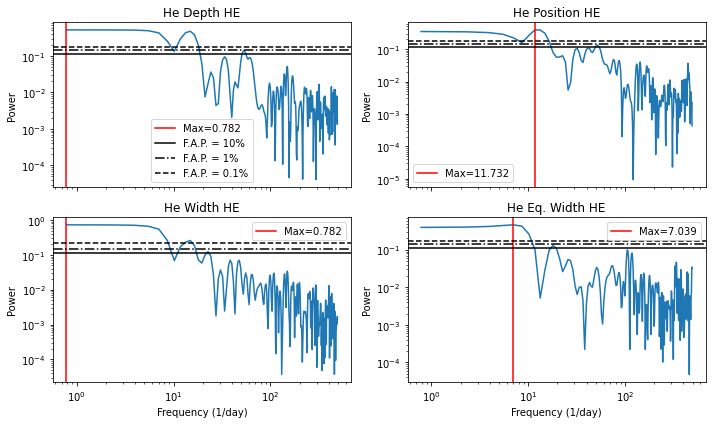

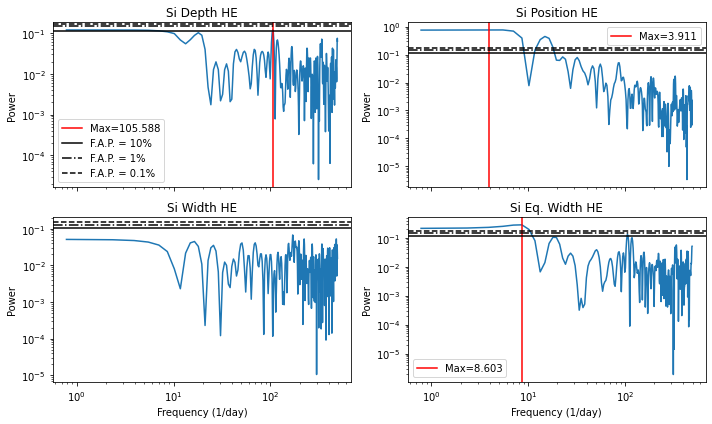

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


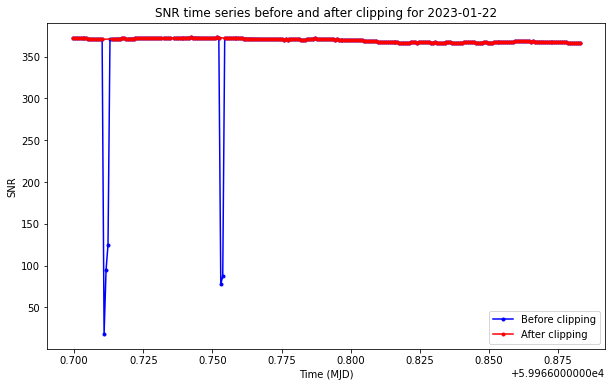

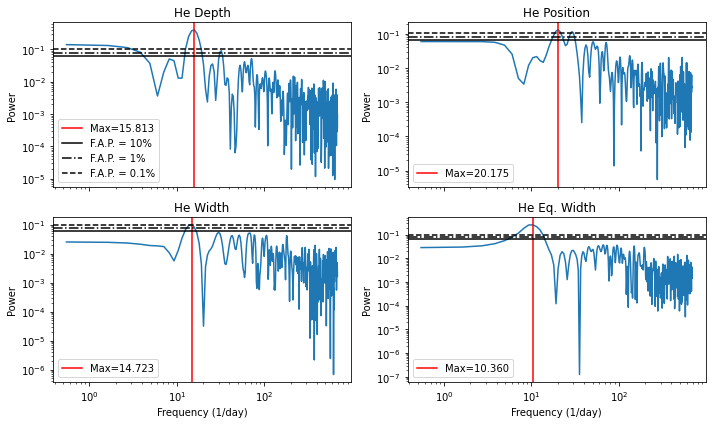

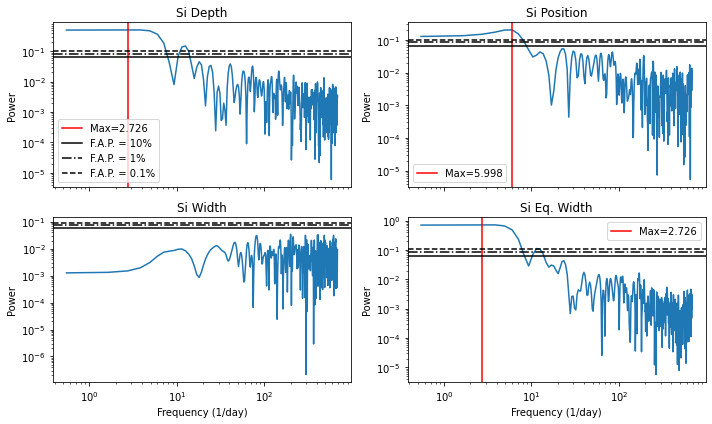

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


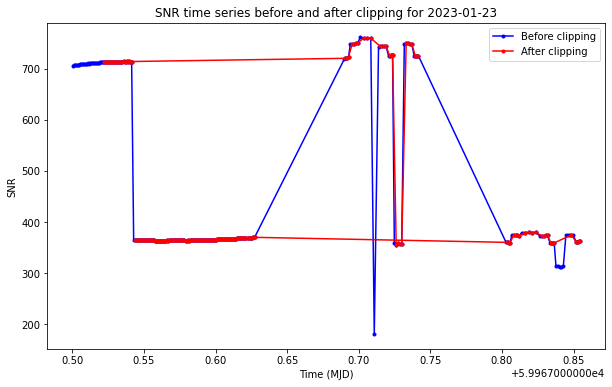

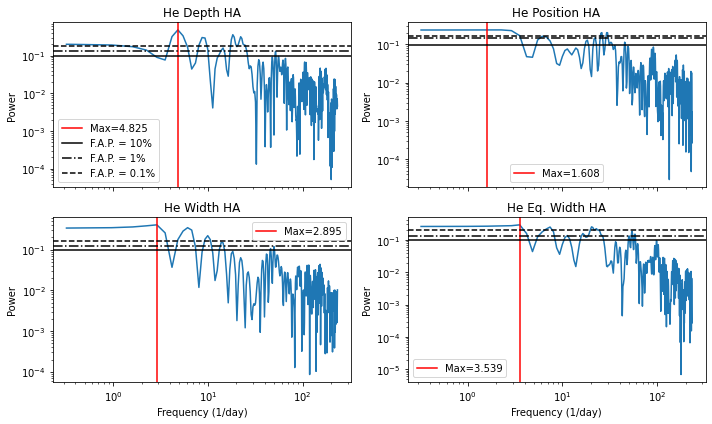

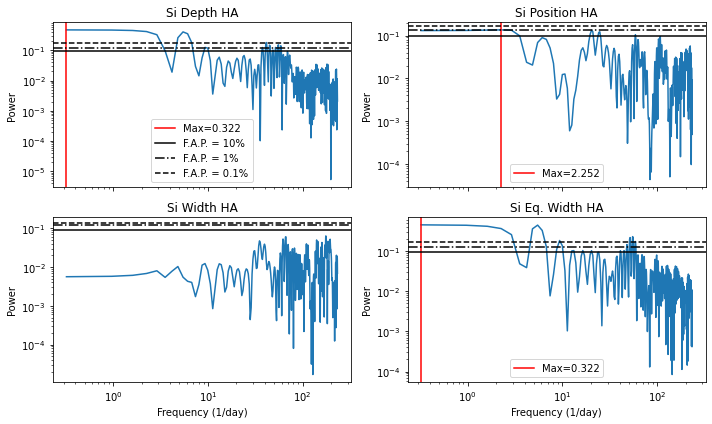

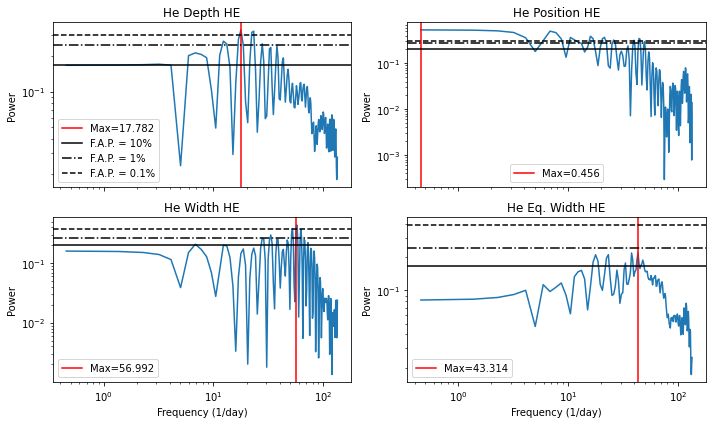

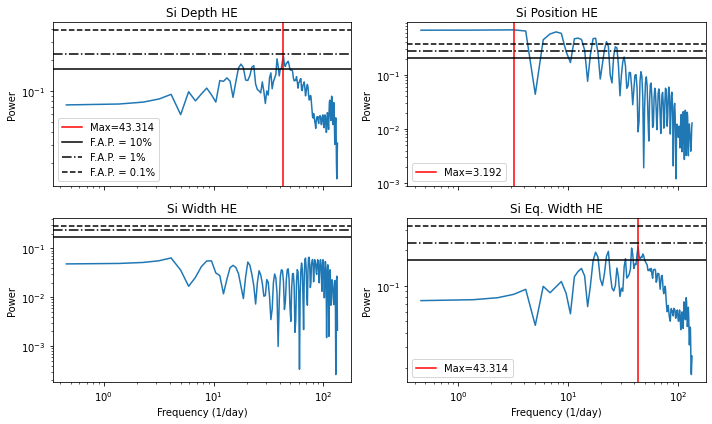

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


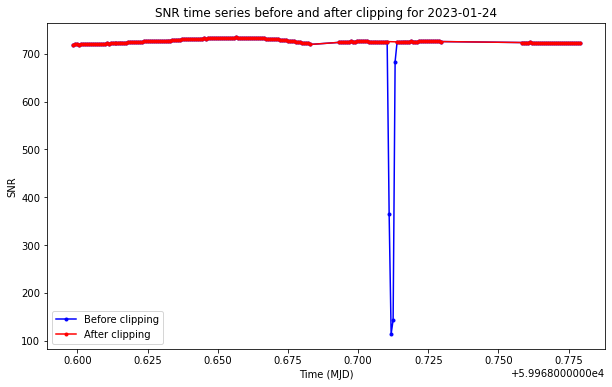

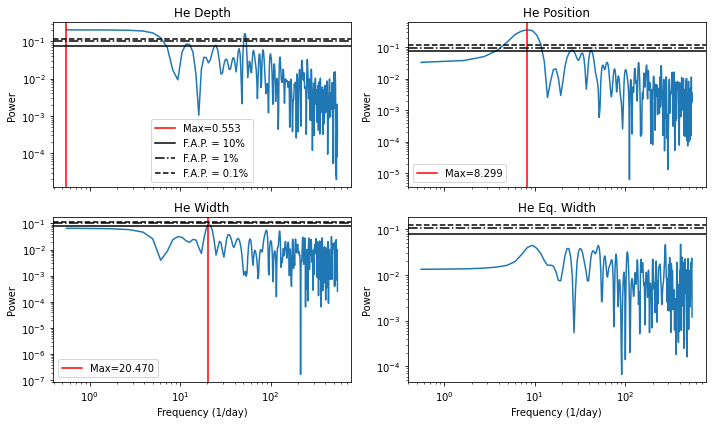

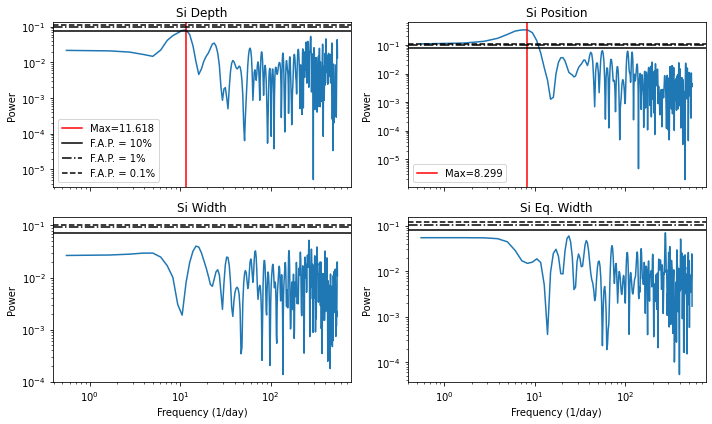

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


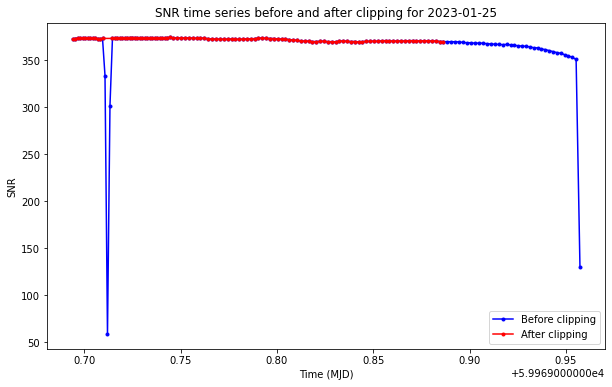

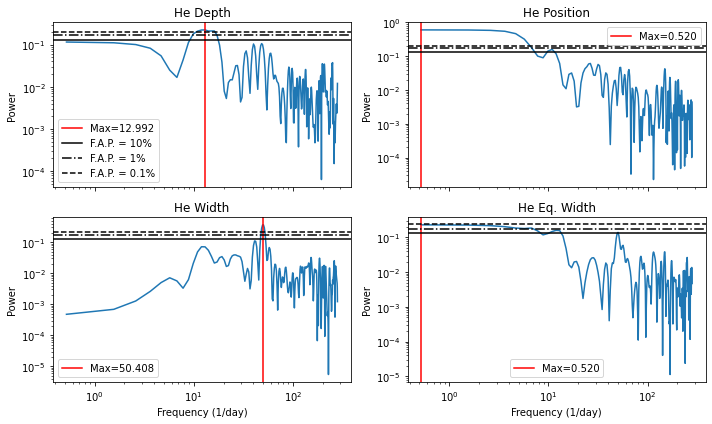

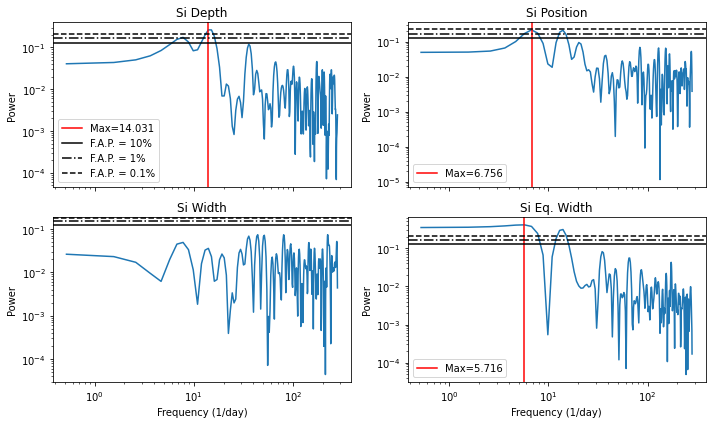

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


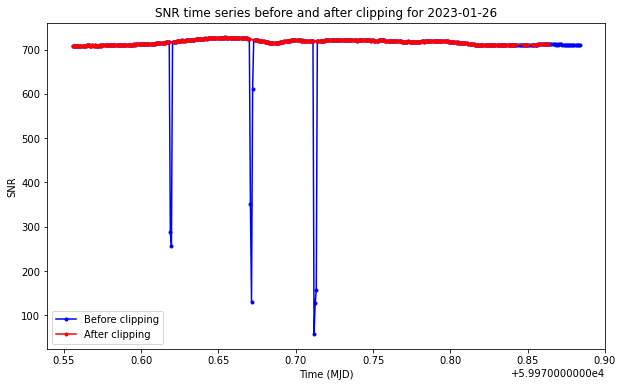

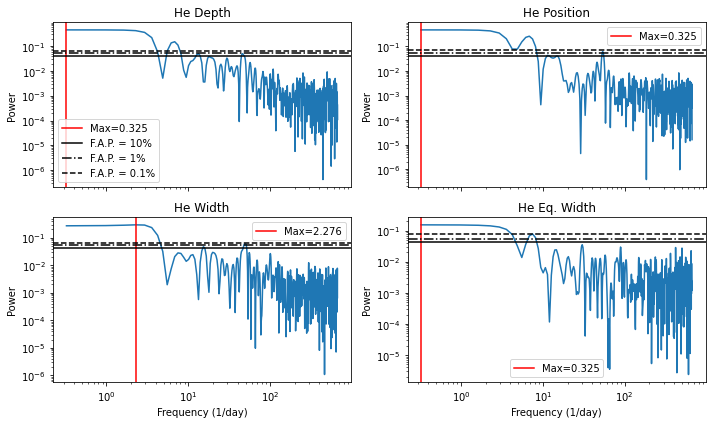

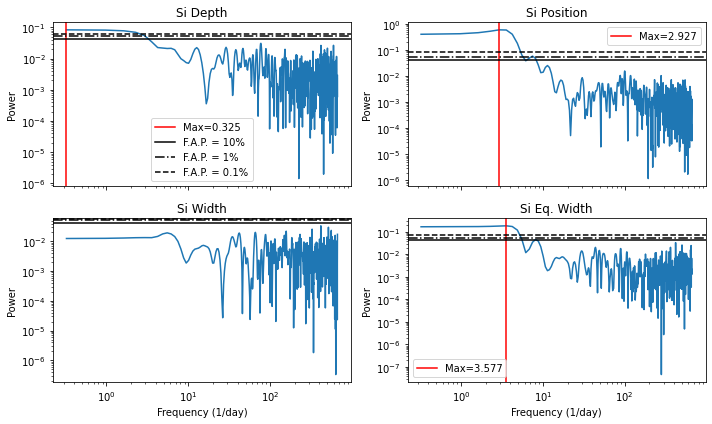

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


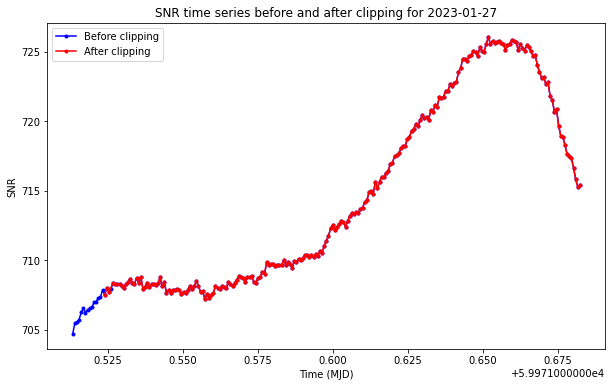

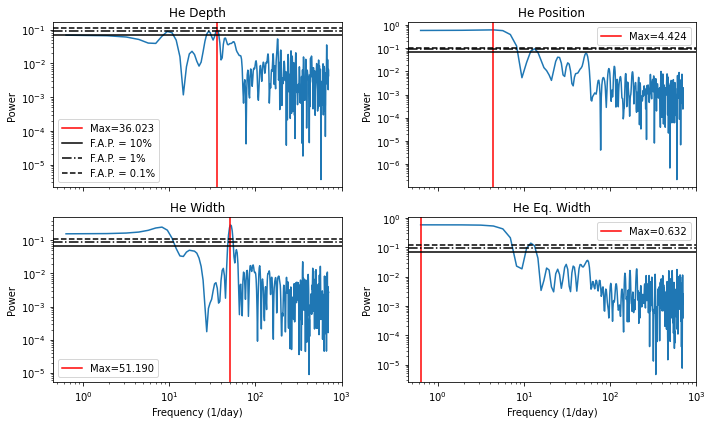

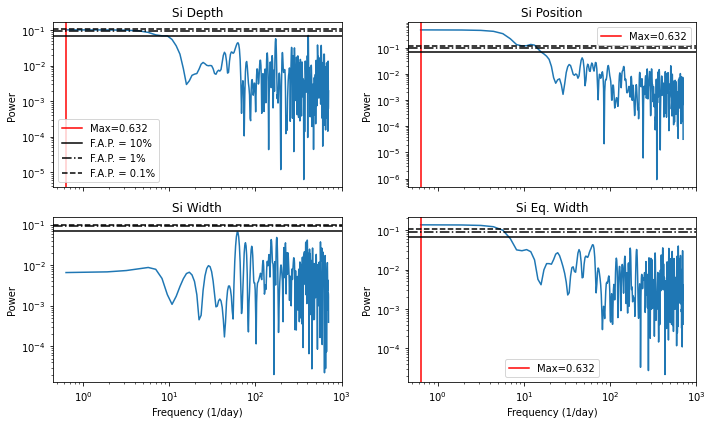

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


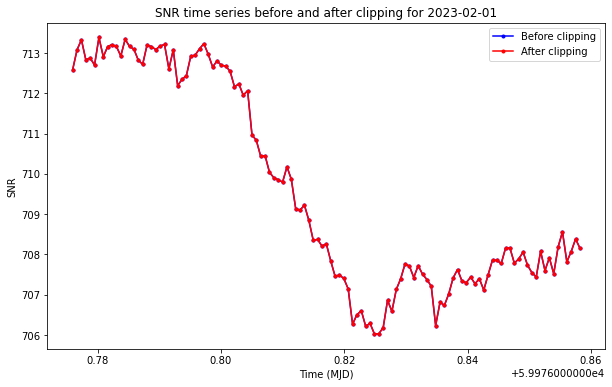

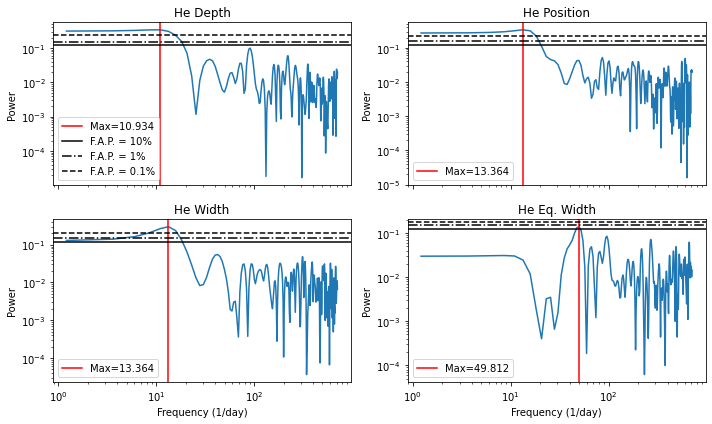

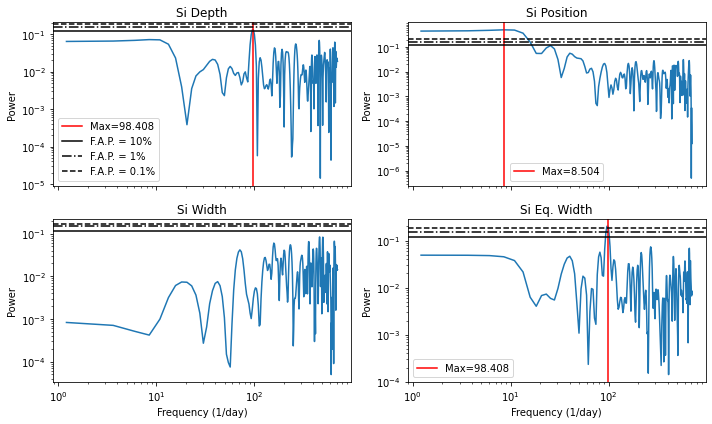

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


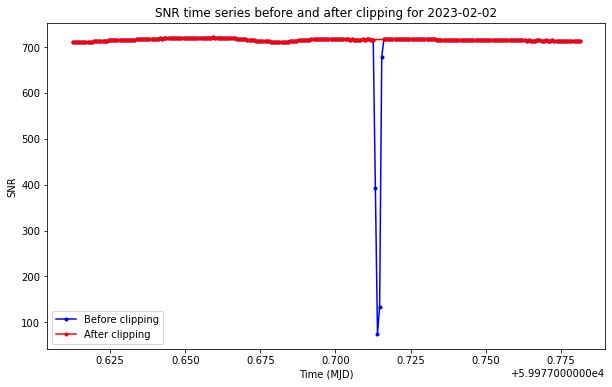

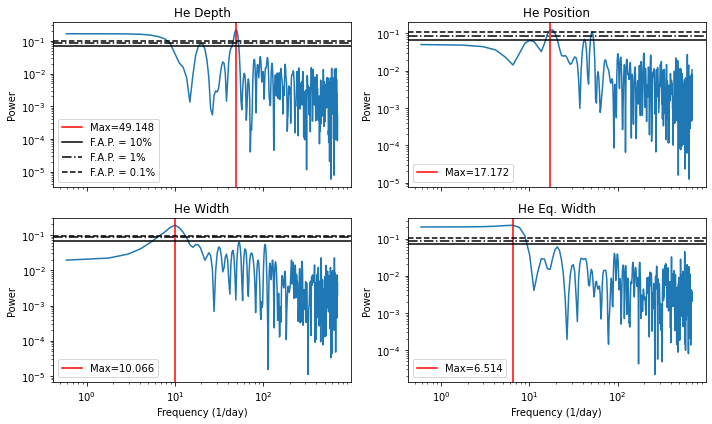

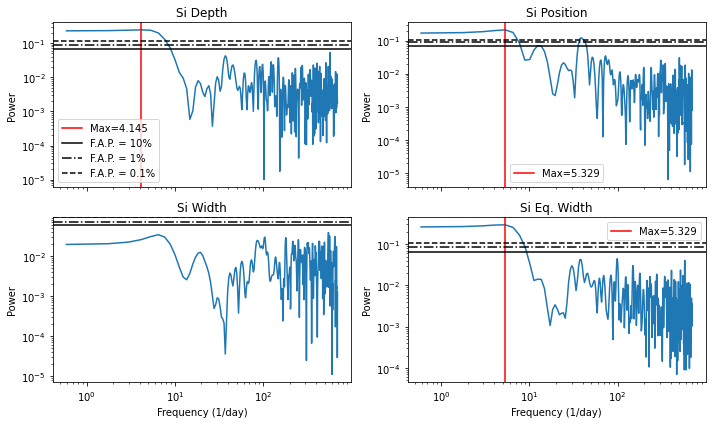

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


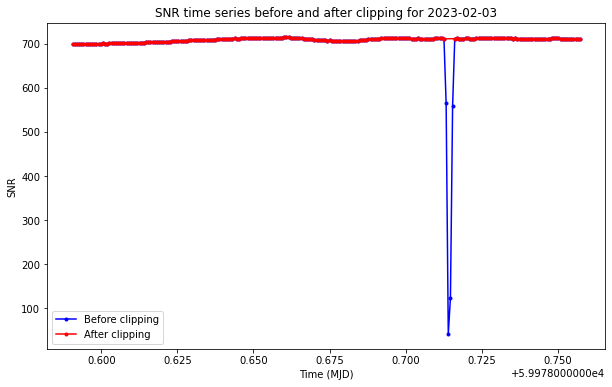

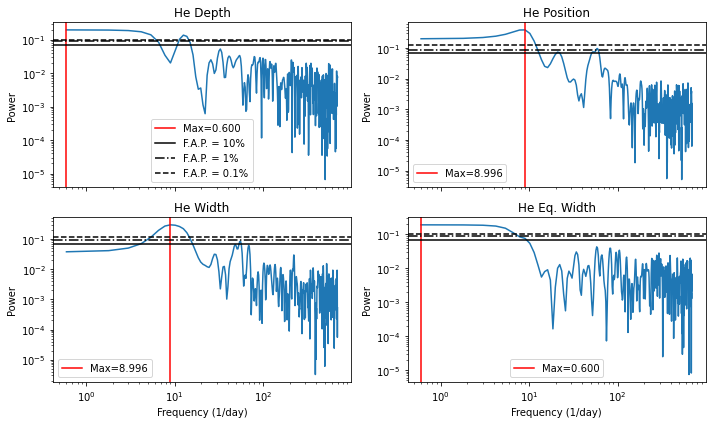

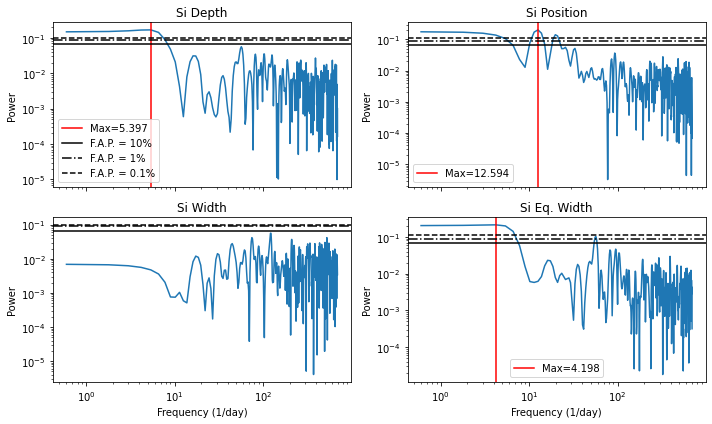

In [3]:
reload(AF)

for day in days:
    
    #Defining the location
    location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/new_Solar-data/'+day
    os.chdir(location)
    if not os.path.exists('Plot_Results'):
        os.mkdir('Plot_Results')
    
    #Extracting the data
    if new:
        #tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_CONTRAST, tot_CONTRAST_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM 
        long_dataset = AF.new_extraction(dir_name, blaze_dir, CCF_dir_name, 14)

    else:
        #tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_CONTRAST, tot_CONTRAST_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM 
        long_dataset = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)
    
    #For data reduction and plotting
    tot_SNR = long_dataset[5]
    tot_mode = long_dataset[6]
    tot_date = long_dataset[7]
    tot_RV = long_dataset[8]
    tot_AIRM = long_dataset[-1]
    sig = 200
    
    #For fitting the He triplet
    lower_lim_He = 10831.5
    upper_lim_He = 10834.1
    guess_params_He = [-0.06, -100, 10833.3, 0.1, 0.008]
    bounds_param_He = ((-np.inf, -np.inf, 10833.2, -np.inf, -np.inf),(0, np.inf, 10833.4, np.inf, np.inf)) 

    #For fitting the Si line
    lower_lim_Si = 10828
    upper_lim_Si = 10832
    guess_params_Si = [0.3, 0.6, 10830, 0.1, 0.2]
    bounds_param_Si = ((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf))

    #For plotting the False alarm probability
    probas = [0.1, 0.01, 0.001]

    #Distinguish two cases depending on the number of modes of observation
    #If there are two modes of observation
    if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
        total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[0], tot_RV, tot_AIRM, sig)

        total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[1], tot_RV, tot_AIRM, sig)

        total_norm_spctr_HA, total_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[2], tot_RV, tot_AIRM, sig)

        total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[3], tot_RV, tot_AIRM, sig)

        total_norm_err_HA, total_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[4], tot_RV, tot_AIRM, sig)
        
        total_SNR_HA, total_SNR_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[5], tot_RV, tot_AIRM, sig)

        date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[7], tot_RV, tot_AIRM, sig)

        total_RV_HA, total_RV_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[8], tot_RV, tot_AIRM, sig)

        total_RV_err_HA, total_RV_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[9], tot_RV, tot_AIRM, sig)

        total_FWHM_HA, total_FWHM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[10], tot_RV, tot_AIRM, sig)

        total_FWHM_err_HA, total_FWHM_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[11], tot_RV, tot_AIRM, sig)

        total_BIS_SPAN_HA, total_BIS_SPAN_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[12], tot_RV, tot_AIRM, sig)

        total_BIS_SPAN_err_HA, total_BIS_SPAN_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[13], tot_RV, tot_AIRM, sig)

        total_CONTRAST_HA, total_CONTRAST_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[14], tot_RV, tot_AIRM, sig)

        total_CONTRAST_err_HA, total_CONTRAST_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[15], tot_RV, tot_AIRM, sig)

        total_H2O_HA, total_H2O_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[16], tot_RV, tot_AIRM, sig)

        total_H2O_err_HA, total_H2O_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[17], tot_RV, tot_AIRM, sig)

        total_O2_HA, total_O2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[18], tot_RV, tot_AIRM, sig)

        total_O2_err_HA, total_O2_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[19], tot_RV, tot_AIRM, sig)

        total_CO2_HA, total_CO2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[20], tot_RV, tot_AIRM, sig)

        total_CO2_err_HA, total_CO2_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[21], tot_RV, tot_AIRM, sig)

        total_AIRM_HA, total_AIRM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[22], tot_RV, tot_AIRM, sig)

        #Plotting the SNR time series to make sure the outliers have been removed
        plt.figure(figsize=[10, 6])
        plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
        plt.plot(date_HA, total_SNR_HA, 'r.', linestyle='-', label='After clipping')
        plt.plot(date_HE, total_SNR_HE, 'r.', linestyle='-')
        plt.xlabel('Time (MJD)')
        plt.ylabel('SNR')
        plt.title('SNR time series before and after clipping for '+day)
        plt.legend()

        #Fitting the He triplet - HA
        theta_HA, err_theta_HA = AF.fit_spctr_line(AF.gaussian_L, lower_lim_He, upper_lim_He, guess_params_He, 
                                               bounds_param_He, total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r', False)

        LS_depth_HA = LombScargle(date_HA, theta_HA[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date_HA, theta_HA[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

        LS_position_HA = LombScargle(date_HA, theta_HA[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date_HA, theta_HA[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

        LS_width_HA = LombScargle(date_HA, theta_HA[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date_HA, theta_HA[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

        LS_ew_HA = LombScargle(date_HA, theta_HA[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date_HA, theta_HA[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

      
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth_HA[0], LS_depth_HA[1])
        if np.max(LS_depth_HA[1])>FAP_depth[0]:
            max_depth = LS_depth_HA[0][np.where(LS_depth_HA[1]==np.max(LS_depth_HA[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position_HA[0], LS_position_HA[1])
        if np.max(LS_position_HA[1])>FAP_position[0]:
            max_position = LS_position_HA[0][np.where(LS_position_HA[1]==np.max(LS_position_HA[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width_HA[0], LS_width_HA[1])
        if np.max(LS_width_HA[1])>FAP_width[0]:
            max_width = LS_width_HA[0][np.where(LS_width_HA[1]==np.max(LS_width_HA[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew_HA[0], LS_ew_HA[1])
        if np.max(LS_ew_HA[1])>FAP_ew[0]:
            max_ew = LS_ew_HA[0][np.where(LS_ew_HA[1]==np.max(LS_ew_HA[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('He Depth HA')
        ax2.set_title('He Position HA')
        ax3.set_title('He Width HA')
        ax4.set_title('He Eq. Width HA')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position_HA[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width_HA[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew_HA[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()
        
        #Fitting the Si line - HA
        theta_Si_HA, err_theta_Si_HA = AF.fit_spctr_line(AF.Voigt, lower_lim_Si, upper_lim_Si, guess_params_Si, 
                                               bounds_param_Si, total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r', False)

        LS_depth_HA = LombScargle(date_HA, theta_Si_HA[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date_HA, theta_Si_HA[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  
        
        LS_position_HA = LombScargle(date_HA, theta_Si_HA[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date_HA, theta_Si_HA[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

        LS_width_HA = LombScargle(date_HA, theta_Si_HA[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date_HA, theta_Si_HA[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  

        LS_ew_HA = LombScargle(date_HA, theta_Si_HA[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date_HA, theta_Si_HA[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  
      
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth_HA[0], LS_depth_HA[1])
        if np.max(LS_depth_HA[1])>FAP_depth[0]:
            max_depth = LS_depth_HA[0][np.where(LS_depth_HA[1]==np.max(LS_depth_HA[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position_HA[0], LS_position_HA[1])
        if np.max(LS_position_HA[1])>FAP_position[0]:
            max_position = LS_position_HA[0][np.where(LS_position_HA[1]==np.max(LS_position_HA[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width_HA[0], LS_width_HA[1])
        if np.max(LS_width_HA[1])>FAP_width[0]:
            max_width = LS_width_HA[0][np.where(LS_width_HA[1]==np.max(LS_width_HA[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew_HA[0], LS_ew_HA[1])
        if np.max(LS_ew_HA[1])>FAP_ew[0]:
            max_ew = LS_ew_HA[0][np.where(LS_ew_HA[1]==np.max(LS_ew_HA[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('Si Depth HA')
        ax2.set_title('Si Position HA')
        ax3.set_title('Si Width HA')
        ax4.set_title('Si Eq. Width HA')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position_HA[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width_HA[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew_HA[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()

        #Fitting the H2O line - HA
        
        
        #Fitting the He triplet - HE
        theta_HE, err_theta_HE = AF.fit_spctr_line(AF.gaussian_L, lower_lim_He, upper_lim_He, guess_params_He, 
                                       bounds_param_He, total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k', False)

        LS_depth_HE = LombScargle(date_HE, theta_HE[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date_HE, theta_HE[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_position_HE = LombScargle(date_HE, theta_HE[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date_HE, theta_HE[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_width_HE = LombScargle(date_HE, theta_HE[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date_HE, theta_HE[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_ew_HE = LombScargle(date_HE, theta_HE[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date_HE, theta_HE[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth_HE[0], LS_depth_HE[1])
        if np.max(LS_depth_HE[1])>FAP_depth[0]:
            max_depth = LS_depth_HE[0][np.where(LS_depth_HE[1]==np.max(LS_depth_HE[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position_HE[0], LS_position_HE[1])
        if np.max(LS_position_HE[1])>FAP_position[0]:
            max_position = LS_position_HE[0][np.where(LS_position_HE[1]==np.max(LS_position_HE[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width_HE[0], LS_width_HE[1])
        if np.max(LS_width_HE[1])>FAP_width[0]:
            max_width = LS_width_HE[0][np.where(LS_width_HE[1]==np.max(LS_width_HE[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew_HE[0], LS_ew_HE[1])
        if np.max(LS_ew_HE[1])>FAP_ew[0]:
            max_ew = LS_ew_HE[0][np.where(LS_ew_HE[1]==np.max(LS_ew_HE[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('He Depth HE')
        ax2.set_title('He Position HE')
        ax3.set_title('He Width HE')
        ax4.set_title('He Eq. Width HE')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position_HE[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width_HE[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew_HE[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()

        #Fitting the Si line - HE
        theta_Si_HE, err_theta_Si_HE = AF.fit_spctr_line(AF.Voigt, lower_lim_Si, upper_lim_Si, guess_params_Si, 
                                       bounds_param_Si, total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k', False)

        LS_depth_HE = LombScargle(date_HE, theta_Si_HE[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date_HE, theta_Si_HE[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_position_HE = LombScargle(date_HE, theta_Si_HE[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date_HE, theta_Si_HE[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_width_HE = LombScargle(date_HE, theta_Si_HE[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date_HE, theta_Si_HE[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_ew_HE = LombScargle(date_HE, theta_Si_HE[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date_HE, theta_Si_HE[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth_HE[0], LS_depth_HE[1])
        if np.max(LS_depth_HE[1])>FAP_depth[0]:
            max_depth = LS_depth_HE[0][np.where(LS_depth_HE[1]==np.max(LS_depth_HE[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position_HE[0], LS_position_HE[1])
        if np.max(LS_position_HE[1])>FAP_position[0]:
            max_position = LS_position_HE[0][np.where(LS_position_HE[1]==np.max(LS_position_HE[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width_HE[0], LS_width_HE[1])
        if np.max(LS_width_HE[1])>FAP_width[0]:
            max_width = LS_width_HE[0][np.where(LS_width_HE[1]==np.max(LS_width_HE[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew_HE[0], LS_ew_HE[1])
        if np.max(LS_ew_HE[1])>FAP_ew[0]:
            max_ew = LS_ew_HE[0][np.where(LS_ew_HE[1]==np.max(LS_ew_HE[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('Si Depth HE')
        ax2.set_title('Si Position HE')
        ax3.set_title('Si Width HE')
        ax4.set_title('Si Eq. Width HE')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position_HE[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width_HE[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew_HE[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()

        #Fitting the H2O line - HE

        #Storing the best-fit values and their errors - HE TRIPLET
        fit_params_dict[f"{day} HA"] = theta_HA
        fit_params_dict[f"{day} HE"] = theta_HE
        
        fit_err_dict[f"{day} HA"] = err_theta_HA
        fit_err_dict[f"{day} HE"] = err_theta_HE
        
        time_dict[f"{day} HA"] = date_HA
        time_dict[f"{day} HE"] = date_HE
        
        #Storing the best-fit values and their errors - Si LINE
        fit_params_Si_dict[f"{day} HA"] = theta_Si_HA
        fit_params_Si_dict[f"{day} HE"] = theta_Si_HE
        
        fit_err_Si_dict[f"{day} HA"] = err_theta_Si_HA
        fit_err_Si_dict[f"{day} HE"] = err_theta_Si_HE
 
        #Storing the best-fit values and their errors - H2O LINE
        #fit_params_T_dict[f"{day} HA"] = theta_T_HA
        #fit_params_T_dict[f"{day} HE"] = theta_T_HE 
        
        #fit_err_T_dict[f"{day} HA"] = err_theta_T_HA
        #fit_err_T_dict[f"{day} HE"] = err_theta_T_HE

    #If there is one mode of observation
    else:
        total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[0], tot_RV, tot_AIRM, sig)

        total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[1], tot_RV, tot_AIRM, sig)

        total_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[2], tot_RV, tot_AIRM, sig)

        total_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[3], tot_RV, tot_AIRM, sig)

        total_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[4], tot_RV, tot_AIRM, sig)

        total_SNR = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[5], tot_RV, tot_AIRM, sig)

        date = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[7], tot_RV, tot_AIRM, sig)

        total_RV = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[8], tot_RV, tot_AIRM, sig)

        total_RV_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[9], tot_RV, tot_AIRM, sig)

        total_FWHM = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[10], tot_RV, tot_AIRM, sig)

        total_FWHM_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[11], tot_RV, tot_AIRM, sig)

        total_BIS_SPAN = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[12], tot_RV, tot_AIRM, sig)

        total_BIS_SPAN_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[13], tot_RV, tot_AIRM, sig)

        total_CONTRAST = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[14], tot_RV, tot_AIRM, sig)

        total_CONTRAST_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[15], tot_RV, tot_AIRM, sig)

        total_H2O = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[16], tot_RV, tot_AIRM, sig)

        total_H2O_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[17], tot_RV, tot_AIRM, sig)

        total_O2 = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[18], tot_RV, tot_AIRM, sig)

        total_O2_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[19], tot_RV, tot_AIRM, sig)

        total_CO2 = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[20], tot_RV, tot_AIRM, sig)

        total_CO2_err = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[21], tot_RV, tot_AIRM, sig)

        total_AIRM = AF.segment_and_reduce(tot_mode, tot_SNR, long_dataset[22], tot_RV, tot_AIRM, sig)

        #Plotting the SNR time series to make sure the outliers have been removed
        plt.figure(figsize=[10, 6])
        plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
        plt.plot(date, total_SNR, 'r.', linestyle='-', label='After clipping')
        plt.xlabel('Time (MJD)')
        plt.ylabel('SNR')
        plt.title('SNR time series before and after clipping for '+day)
        plt.legend()
        
        #Fitting the He triplet 
        theta, err_theta = AF.fit_spctr_line(AF.gaussian_L, lower_lim_He, upper_lim_He, guess_params_He, 
                                             bounds_param_He, total_lamda, total_norm_spctr, total_norm_err, 'r', False)
        
        LS_depth = LombScargle(date, theta[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date, theta[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  
            
        LS_position = LombScargle(date, theta[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date, theta[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_width = LombScargle(date, theta[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date, theta[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_ew = LombScargle(date, theta[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date, theta[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth[0], LS_depth[1])
        if np.max(LS_depth[1])>FAP_depth[0]:
            max_depth = LS_depth[0][np.where(LS_depth[1]==np.max(LS_depth[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position[0], LS_position[1])
        if np.max(LS_position[1])>FAP_position[0]:
            max_position = LS_position[0][np.where(LS_position[1]==np.max(LS_position[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width[0], LS_width[1])
        if np.max(LS_width[1])>FAP_width[0]:
            max_width = LS_width[0][np.where(LS_width[1]==np.max(LS_width[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew[0], LS_ew[1])
        if np.max(LS_ew[1])>FAP_ew[0]:
            max_ew = LS_ew[0][np.where(LS_ew[1]==np.max(LS_ew[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('He Depth')
        ax2.set_title('He Position')
        ax3.set_title('He Width')
        ax4.set_title('He Eq. Width')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()
        
        #Fitting the Si line
        theta_Si, err_theta_Si = AF.fit_spctr_line(AF.Voigt, lower_lim_Si, upper_lim_Si, guess_params_Si, 
                                             bounds_param_Si, total_lamda, total_norm_spctr, total_norm_err, 'r', False)
        
        LS_depth = LombScargle(date, theta_Si[:,0]).autopower(nyquist_factor=1)
        FAP_depth = LombScargle(date, theta_Si[:,0]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  
        
        LS_position = LombScargle(date, theta_Si[:,2]).autopower(nyquist_factor=1)
        FAP_position = LombScargle(date, theta_Si[:,2]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_width = LombScargle(date, theta_Si[:,3]).autopower(nyquist_factor=1)
        FAP_width = LombScargle(date, theta_Si[:,3]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        LS_ew = LombScargle(date, theta_Si[:,-1]).autopower(nyquist_factor=1)
        FAP_ew = LombScargle(date, theta_Si[:,-1]).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 6], sharex=True)
        ax1.loglog(LS_depth[0], LS_depth[1])
        if np.max(LS_depth[1])>FAP_depth[0]:
            max_depth = LS_depth[0][np.where(LS_depth[1]==np.max(LS_depth[1]))]
            ax1.axvline(max_depth, color='r', label='Max=%.3f' %max_depth)
        
        ax2.loglog(LS_position[0], LS_position[1])
        if np.max(LS_position[1])>FAP_position[0]:
            max_position = LS_position[0][np.where(LS_position[1]==np.max(LS_position[1]))]
            ax2.axvline(max_position, color='r', label='Max=%.3f' %max_position)
        
        ax3.loglog(LS_width[0], LS_width[1])
        if np.max(LS_width[1])>FAP_width[0]:
            max_width = LS_width[0][np.where(LS_width[1]==np.max(LS_width[1]))]
            ax3.axvline(max_width, color='r', label='Max=%.3f' %max_width)
        
        ax4.loglog(LS_ew[0], LS_ew[1])
        if np.max(LS_ew[1])>FAP_ew[0]:
            max_ew = LS_ew[0][np.where(LS_ew[1]==np.max(LS_ew[1]))]
            ax4.axvline(max_ew, color='r', label='Max=%.3f' %max_ew)
        ax1.set_title('Si Depth')
        ax2.set_title('Si Position')
        ax3.set_title('Si Width')
        ax4.set_title('Si Eq. Width')
        ax1.set_ylabel('Power')
        ax2.set_ylabel('Power')
        ax3.set_ylabel('Power')
        ax4.set_ylabel('Power')
        ax3.set_xlabel('Frequency (1/day)')
        ax4.set_xlabel('Frequency (1/day)')
        ax1.axhline(FAP_depth[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
        ax1.axhline(FAP_depth[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
        ax1.axhline(FAP_depth[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
        ax2.axhline(FAP_position[0], color='k')
        ax2.axhline(FAP_position[1], color='k', linestyle='-.')
        ax2.axhline(FAP_position[2], color='k', linestyle='--')
        ax3.axhline(FAP_width[0], color='k')
        ax3.axhline(FAP_width[1], color='k', linestyle='-.')
        ax3.axhline(FAP_width[2], color='k', linestyle='--')
        ax4.axhline(FAP_ew[0], color='k')
        ax4.axhline(FAP_ew[1], color='k', linestyle='-.')
        ax4.axhline(FAP_ew[2], color='k', linestyle='--')
        ax1.legend()
        if np.max(LS_position[1])>FAP_position[0]:
            ax2.legend()
        if np.max(LS_width[1])>FAP_width[0]:
            ax3.legend()
        if np.max(LS_ew[1])>FAP_ew[0]:
            ax4.legend()
        fig.tight_layout()

        #Fitting the H2O line


        #Storing the best-fit values - HE TRIPLET
        fit_params_dict[f"{day}"] = theta
        
        fit_err_dict[f"{day}"] = err_theta
        
        time_dict[f"{day}"] = date
    
        #Storing the best-fit values and their errors - Si LINE
        fit_params_Si_dict[f"{day}"] = theta_Si
        
        fit_err_Si_dict[f"{day}"] = err_theta_Si
 
        #Storing the best-fit values and their errors - H2O LINE
        #fit_params_T_dict[f"{day}"] = theta_T
        
        #fit_err_T_dict[f"{day}"] = err_theta_T
        
    plt.show()
    

# Plotting the big dataset - He Triplet

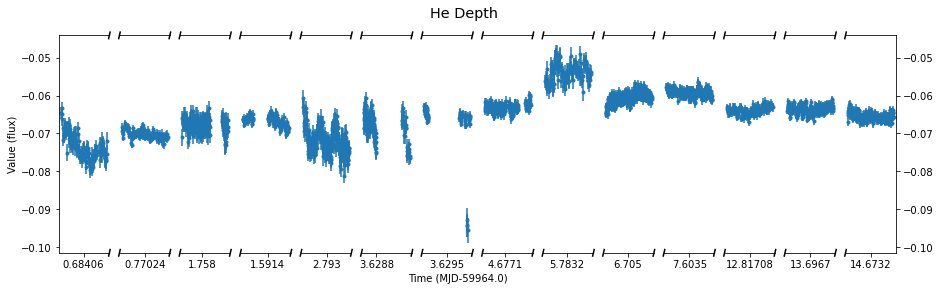

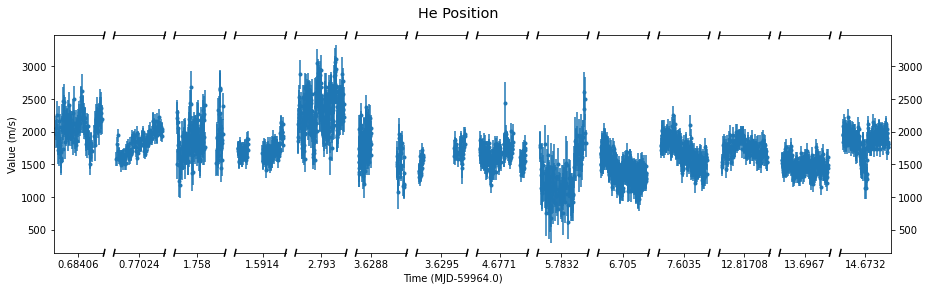

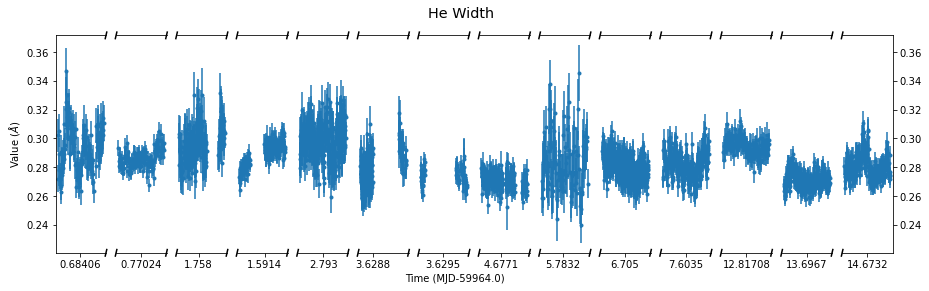

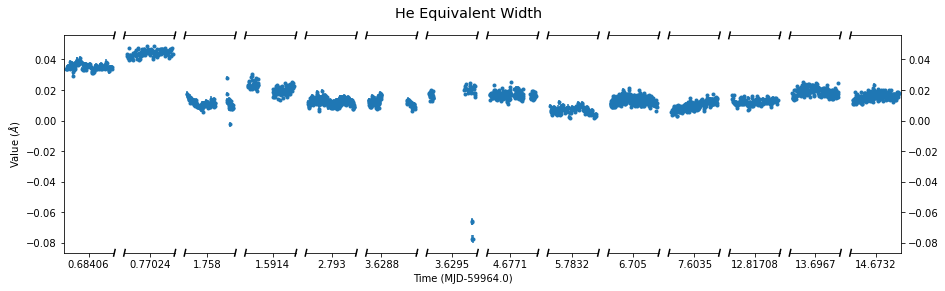

In [4]:
#Plotting one of the parameters of interest for all the days
params_of_interest = ['Depth', 'Position', 'Width', 'Equivalent Width']
units_of_interest = ['(flux)', '(m/s)', '($\AA$)', '($\AA$)'] 
indexes_of_interest = [0, 2, 3, -1]

#Reference value of the line of interest
ref_wav = AF.air2vac((10830.33977+10830.25010)/2) #From NIST database

#Line of interest 
line_name = 'He'

#Dictionnaries of interest
param_dictionnary = fit_params_dict
err_dictionnary = fit_err_dict
time_dictionnary = time_dict

#Define excess in time
excess=59964.0

for i in range(len(params_of_interest)):
    fig, axs = plt.subplots(1, len(param_dictionnary.keys()), sharey=True, figsize=[15, 4])
    fig.suptitle(line_name+' '+params_of_interest[i], fontsize="x-large")
    axs = axs.ravel()

    # Loop over the keys and values in the param_dictionnary dictionary
    for day in param_dictionnary:
        key_list = list(param_dictionnary.keys())

        index = key_list.index(day)

        param_list = np.array([param[indexes_of_interest[i]] for param in param_dictionnary[day]])
        err_list = np.array([err[indexes_of_interest[i]] for err in err_dictionnary[day]])
        time_list = np.array([time-excess for time in time_dictionnary[day]])
        if params_of_interest[i]=='Position':
            axs[index].errorbar(time_list, (param_list-ref_wav)*3e8/ref_wav, yerr=err_list*3e8/ref_wav, fmt='.', label=day)
        else:
            axs[index].errorbar(time_list, param_list, yerr=err_list, fmt='.', label=day)

        #Adding the breaks
        d = .015  

        if index==0:
            axs[index].spines['right'].set_visible(False)
            axs[index].set_ylabel('Value '+units_of_interest[i])
            kwargs = dict(transform=axs[index].transAxes, color='k', clip_on=False)
            axs[index].plot((1-d, 1+d), (-d, +d), **kwargs) #Bottom right
            axs[index].plot((1-d, 1+d), (1-d, 1+d), **kwargs) #Top right

        elif index==len(fit_params_dict.keys())-1:
            axs[index].spines['left'].set_visible(False)
            axs[index].yaxis.tick_right()
            axs[index].tick_params(labelright='off')

            kwargs.update(transform=axs[index].transAxes)
            axs[index].plot((-d, +d), (1-d, 1+d), **kwargs) #Top left
            axs[index].plot((-d, +d), (-d, +d), **kwargs) #Bottom left

        else:
            axs[index].spines['right'].set_visible(False)
            axs[index].spines['left'].set_visible(False)
            axs[index].get_yaxis().set_visible(False)

            kwargs = dict(transform=axs[index].transAxes, color='k', clip_on=False)
            axs[index].plot((1-d, 1+d), (-d, +d), **kwargs)
            axs[index].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

            kwargs.update(transform=axs[index].transAxes)
            axs[index].plot((-d, +d), (1-d, 1+d), **kwargs)
            axs[index].plot((-d, +d), (-d, +d), **kwargs)

        axs[index].set_xticks([np.mean(time_list)])
        axs[7].set_xlabel('Time (MJD-'+str(excess)+')', ha='right')

    plt.show()



# Inspecting the periodograms and fitting long-term trend - He triplet

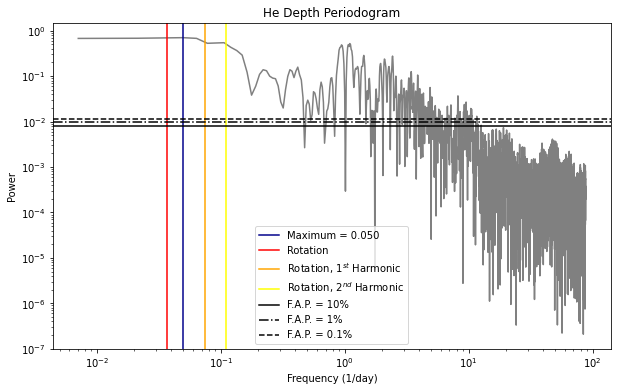

chisq=9086.575316816878  with 2470 degrees of freedom
For  Depth
parameter: Amplitude Cos: 1.2785085717073881e-06
   95% conf interval: 1.2785085717073881e-06 1.2785085717073881e-06
   tstat: inf
   pstat: 0.0
parameter: Amplitude Sin: 0.00608818898260671
   95% conf interval: 0.005889810960547007 0.006286567004666413
   tstat: 50.499228248511585
   pstat: 0.0
parameter: Offset: -0.06479841551689434
   95% conf interval: -0.06492210437137494 -0.06467472666241375
   tstat: -862.0331973183288
   pstat: 0.0
parameter: Period: 20.1573376984795
   95% conf interval: 20.157311196620103 20.157364200338893
   tstat: 1251546.5234101058
   pstat: 0.0


/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Analysis_functions.py:953: RuntimeWarning: divide by zero encountered in true_divide
  pstat_beta = (1.0 - ss.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values


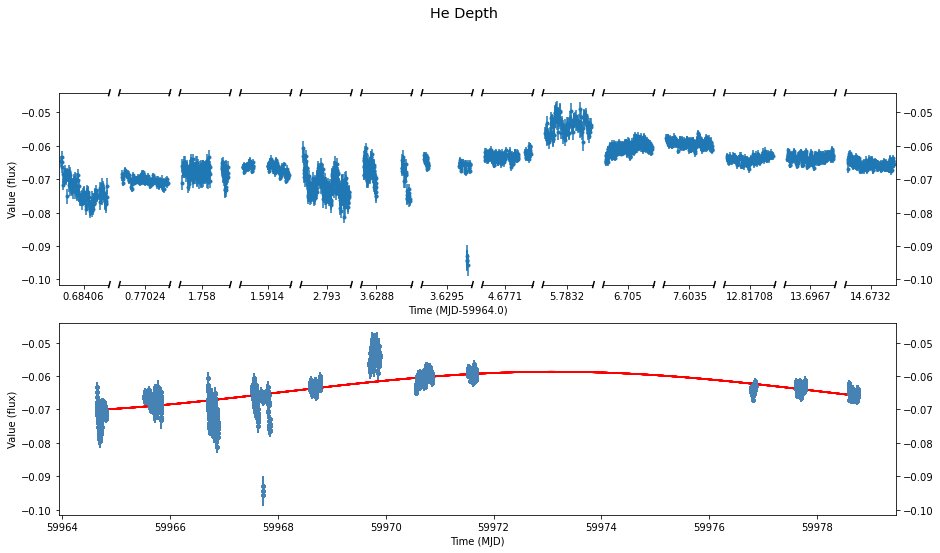

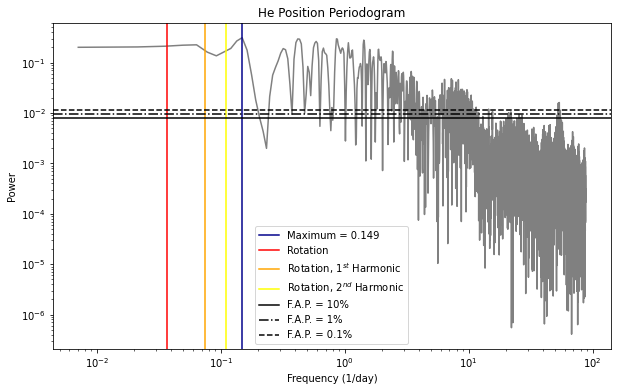

chisq=6939.985324078478  with 2470 degrees of freedom
For  Position
parameter: Amplitude Cos: -0.006991420695294249
   95% conf interval: -0.009403529670462128 -0.004579311720126372
   tstat: -4.769344385361331
   pstat: 1.955813512033444e-06
parameter: Amplitude Sin: 0.007450462965517586
   95% conf interval: 0.0052005841339639695 0.009700341797071202
   tstat: 5.448968568301212
   pstat: 5.567912886306203e-08
parameter: Offset: 10833.323989796889
   95% conf interval: 10833.323608066192 10833.324371527586
   tstat: 46697627.62372326
   pstat: 0.0
parameter: Period: 6.718665206445939
   95% conf interval: 6.718626638060639 6.718703774831239
   tstat: 286643.2475014467
   pstat: 0.0


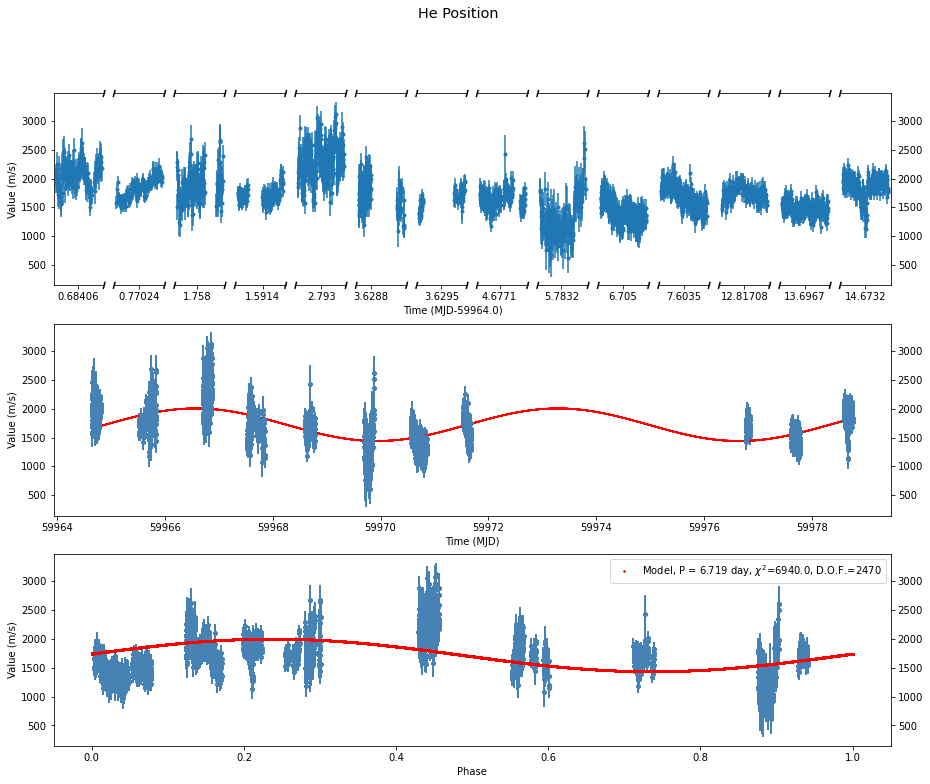

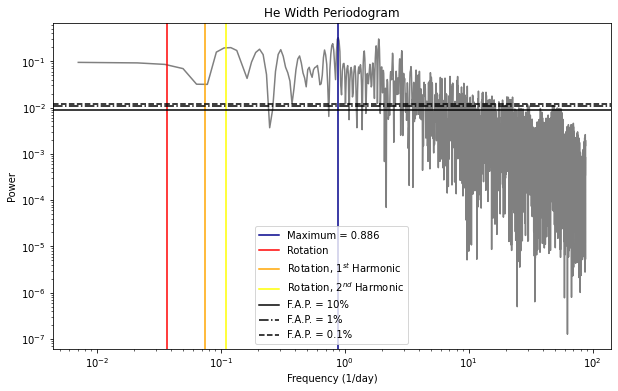

chisq=4120.727796561393  with 2470 degrees of freedom
For  Width
parameter: Amplitude Cos: -0.008934810032229741
   95% conf interval: -0.009415644605587888 -0.008453975458871594
   tstat: -30.575939338825677
   pstat: 0.0
parameter: Amplitude Sin: 7.4069298190297716e-06
   95% conf interval: 7.4069298190297716e-06 7.4069298190297716e-06
   tstat: inf
   pstat: 0.0
parameter: Offset: 0.28233756842824365
   95% conf interval: 0.2819652345915444 0.2827099022649429
   tstat: 1247.7464319379822
   pstat: 0.0
parameter: Period: 1.129756227164264
   95% conf interval: 1.1297560069111443 1.1297564474173838
   tstat: 8440202.125480257
   pstat: 0.0


/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Analysis_functions.py:953: RuntimeWarning: divide by zero encountered in true_divide
  pstat_beta = (1.0 - ss.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values


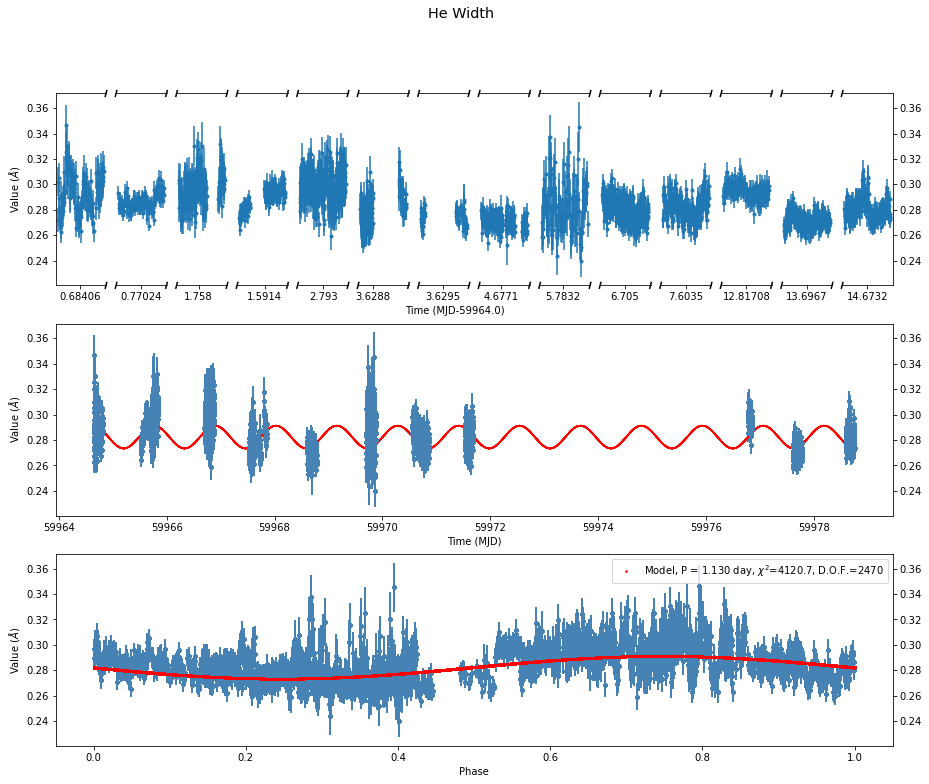

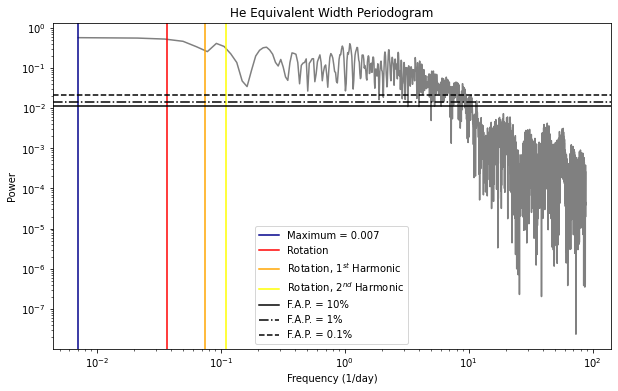

chisq=156181.1924757531  with 2470 degrees of freedom
For  Equivalent Width
parameter: Amplitude Cos: -0.2058382606413801
   95% conf interval: -0.2058382606413801 -0.2058382606413801
   tstat: -inf
   pstat: 0.0
parameter: Amplitude Sin: -0.26471490315341467
   95% conf interval: -0.2834335907641941 -0.24599621554263523
   tstat: -23.269827708132468
   pstat: 0.0
parameter: Offset: 0.34436721453850655
   95% conf interval: 0.32990167970943657 0.35883274936757653
   tstat: 39.172155920880016
   pstat: 0.0
parameter: Period: 141.0652343020481
   95% conf interval: 141.06328839839261 141.0671802057036
   tstat: 119285.82337904321
   pstat: 0.0


/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Analysis_functions.py:953: RuntimeWarning: divide by zero encountered in true_divide
  pstat_beta = (1.0 - ss.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values


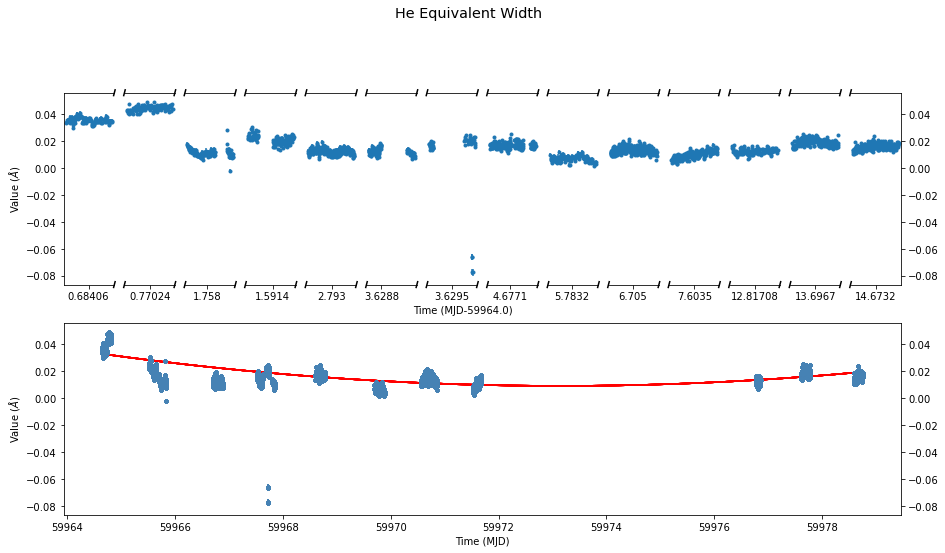

In [55]:
reload(AF)
#Frequency of oscillation 
oscillation_freq = 24*60/5.4 #in 1/days!!

#Line of interest 
line_name = 'He'

#List to store the sinusoidal trend frequencies
freqs = []
for i in range(len(params_of_interest)):
    long_param = []
    long_param_err = []
    long_time = []
    
    # Loop over the keys and values in the fit_params_dict dictionary
    for day in param_dictionnary:
        key_list = list(param_dictionnary.keys())

        index = key_list.index(day)

        param_list = [param[indexes_of_interest[i]] for param in param_dictionnary[day]]
        err_list = [err[indexes_of_interest[i]] for err in err_dictionnary[day]]
        time_list = [time for time in time_dictionnary[day]]

        long_param.append(param_list)
        long_param_err.append(err_list)
        long_time.append(time_list)

    long_param = np.array(list(itertools.chain.from_iterable(long_param)))
    long_param_err = np.array(list(itertools.chain.from_iterable(long_param_err)))
    long_time = np.array(list(itertools.chain.from_iterable(long_time)))
    
    LS = LombScargle(long_time, long_param, long_param_err).autopower(nyquist_factor=1) 
    probas = [0.1, 0.01, 0.001]
    FAP = LombScargle(long_time, long_param, long_param_err).false_alarm_level(probas, method='bootstrap', nyquist_factor=1)  
    
    plt.figure(figsize=[10, 6])
    plt.loglog(LS[0], LS[1], color='grey')
    if max(LS[1])>FAP[0]:
        max_power = np.where(LS[1]==max(LS[1]))
        plt.axvline(LS[0][max_power], color='darkblue', label='Maximum = %.3f' %LS[0][max_power])
    plt.axvline(1/27, color='r', label='Rotation')
    plt.axvline(2/27, color='orange', label='Rotation, $1^{st}$ Harmonic')
    plt.axvline(3/27, color='yellow', label='Rotation, $2^{nd}$ Harmonic')
    plt.axhline(FAP[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
    plt.axhline(FAP[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
    plt.axhline(FAP[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power')
    plt.title(line_name+' '+params_of_interest[i]+' Periodogram')
    plt.legend()
    plt.show()
    
    #Fitting the long-term trend to the data
    important_freq = LS[0][max_power]

    #Creating a basic sinusoidal function
    def sinusoid(t, A, B, offset, period):
        return offset+A*np.cos(2*np.pi*t/period) + B*np.sin(2*np.pi*t/period)

    guess = [-0.0003, 0.0005, np.median(long_param), important_freq[0]**(-1)]
    best_fit_theta, best_fit_err = curve_fit(sinusoid, long_time, long_param, sigma = long_param_err, p0=guess, maxfev=1000000)
    
    #Evaluating the model
    simulated_time = np.linspace(long_time[0], long_time[-1], 10000)
    model = sinusoid(simulated_time, *best_fit_theta)

    #Evaluating the goodness of fit - chi-squared
    residuals = long_param - sinusoid(long_time, *best_fit_theta)
    chisq = np.sum((residuals/long_param_err)**2)
    Dof = len(long_param) - len(best_fit_theta)
    print('chisq='+str(chisq), ' with '+str(Dof)+' degrees of freedom')

    #Evaluating the statistical significance of our results
    print('For ', params_of_interest[i])
    param_name = ['Amplitude Cos', 'Amplitude Sin', 'Offset', 'Period']
    AF.eval_stat(best_fit_theta, long_time, long_param, sinusoid, param_name)

    fig, axes = plt.subplot_mosaic("ABCDEFGHIJKLMN;OOOOOOOOOOOOOO;PPPPPPPPPPPPPP", figsize=[15, 12])
    
    subplot_list = "ABCDEFGHIJKLMN"
    
    fig.suptitle(line_name+' '+params_of_interest[i], fontsize="x-large")
    
    # Loop over the keys and values in the fit_params_dict dictionary
    for day in param_dictionnary:
        key_list = list(param_dictionnary.keys())

        index = key_list.index(day)
        param_list = np.array([param[indexes_of_interest[i]] for param in param_dictionnary[day]])
        err_list = np.array([err[indexes_of_interest[i]] for err in err_dictionnary[day]])
        time_list = np.array([time-excess for time in time_dictionnary[day]])
        
        if params_of_interest[i]=='Position':
            axes[subplot_list[index]].errorbar(time_list, (param_list-ref_wav)*3e8/ref_wav, yerr=err_list*3e8/ref_wav, fmt='.')
            axes['O'].plot(simulated_time, (model-ref_wav)*3e8/ref_wav, 'r', label='Model')
            axes['O'].errorbar(long_time, (long_param-ref_wav)*3e8/ref_wav, yerr=long_param_err*3e8/ref_wav, fmt='.', color='steelblue')
            
            if important_freq > 3/27:
                axes['P'].errorbar(AF.phasefold(long_time, np.mean(long_time), important_freq), (long_param-ref_wav)*3e8/ref_wav, yerr=long_param_err*3e8/ref_wav, fmt='.', color='steelblue', zorder=1)
                line1=axes['P'].plot(AF.phasefold(simulated_time, np.mean(simulated_time), important_freq), (model-ref_wav)*3e8/ref_wav, 'r.', zorder=2, markersize=3)
                
                axes['P'].set_xlabel('Phase')
                axes['P'].set_ylabel('Value '+units_of_interest[i])
                axes['P'].tick_params(left=True, right=True, labelright='off')

                axes['P'].legend(line1, ['Model, P = %.3f day'%best_fit_theta[-1]+', $\chi^2$=%.1f'%chisq+', D.O.F.='+str(Dof)])
            else:
                axes['P'].set_visible(False)
        else:
            axes[subplot_list[index]].errorbar(time_list, param_list, yerr=err_list, fmt='.')
            axes['O'].plot(simulated_time, model, 'r', label='Model')
            axes['O'].errorbar(long_time, long_param, yerr=long_param_err, fmt='.', color='steelblue')
            
            if important_freq > 3/27:
                axes['P'].errorbar(AF.phasefold(long_time, np.mean(long_time), important_freq), long_param, yerr=long_param_err, fmt='.', color='steelblue', zorder=1)
                line1=axes['P'].plot(AF.phasefold(simulated_time, np.mean(simulated_time), important_freq), model, 'r.', zorder=2, markersize=3)

                axes['P'].set_xlabel('Phase')
                axes['P'].set_ylabel('Value '+units_of_interest[i])
                axes['P'].tick_params(left=True, right=True, labelright='off')

                axes['P'].legend(line1, ['Model, P = %.3f day'%best_fit_theta[-1]+', $\chi^2$=%.1f'%chisq+', D.O.F.='+str(Dof)])
            else:
                axes['P'].set_visible(False)


        axes['O'].set_xlabel('Time (MJD)')
        axes['O'].set_ylabel('Value '+units_of_interest[i])
        axes['O'].tick_params(left=True, right=True, labelright='off')

        #Adding the breaks
        d = .015  

        if index==0:
            axes[subplot_list[index]].spines['right'].set_visible(False)
            axes[subplot_list[index]].set_ylabel('Value '+units_of_interest[i])
            kwargs = dict(transform=axes[subplot_list[index]].transAxes, color='k', clip_on=False)
            axes[subplot_list[index]].plot((1-d, 1+d), (-d, +d), **kwargs) #Bottom right
            axes[subplot_list[index]].plot((1-d, 1+d), (1-d, 1+d), **kwargs) #Top right

        elif index==len(fit_params_dict.keys())-1:
            axes[subplot_list[index]].sharey(axes[subplot_list[0]])
            axes[subplot_list[index]].spines['left'].set_visible(False)
            axes[subplot_list[index]].yaxis.tick_right()
            axes[subplot_list[index]].tick_params(labelright='off')

            kwargs.update(transform=axes[subplot_list[index]].transAxes)
            axes[subplot_list[index]].plot((-d, +d), (1-d, 1+d), **kwargs) #Top left
            axes[subplot_list[index]].plot((-d, +d), (-d, +d), **kwargs) #Bottom left

        else:
            axes[subplot_list[index]].sharey(axes[subplot_list[0]])
            axes[subplot_list[index]].spines['right'].set_visible(False)
            axes[subplot_list[index]].spines['left'].set_visible(False)
            axes[subplot_list[index]].get_yaxis().set_visible(False)

            kwargs = dict(transform=axes[subplot_list[index]].transAxes, color='k', clip_on=False)
            axes[subplot_list[index]].plot((1-d, 1+d), (-d, +d), **kwargs)
            axes[subplot_list[index]].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

            kwargs.update(transform=axes[subplot_list[index]].transAxes)
            axes[subplot_list[index]].plot((-d, +d), (1-d, 1+d), **kwargs)
            axes[subplot_list[index]].plot((-d, +d), (-d, +d), **kwargs)

        axes[subplot_list[index]].set_xticks([np.mean(time_list)])
        axes[subplot_list[7]].set_xlabel('Time (MJD-'+str(excess)+')', ha='right')
        
    plt.show()

# Plotting the big dataset - Si Line

# Inspecting the periodograms and fitting long-term trend - Si line

# Extracting the HARPS data and plotting the Calcium stellar activity indicator

In [78]:
HARPS_file = np.loadtxt(HARPS_directory+'SUN_harps.rdb', skiprows=2)

BJD_date = HARPS_file[:, 0]
vrad = HARPS_file[:, 1]
vrad_err = HARPS_file[:, 2]
old_rhk = HARPS_file[:, 9]
old_rhk_err = HARPS_file[:, 10]

low_rhk = -5.02
high_rhk = -4.95

rhk_BJD_date = AF.bound(low_rhk, high_rhk, old_rhk, BJD_date)
rhk = AF.bound(low_rhk, high_rhk, old_rhk, old_rhk)
rhk_err = AF.bound(low_rhk, high_rhk, old_rhk, old_rhk_err)
new_vrad = AF.bound(low_rhk, high_rhk, old_rhk, vrad)
new_vrad_err = AF.bound(low_rhk, high_rhk, old_rhk, vrad_err)

<IPython.core.display.Javascript object>


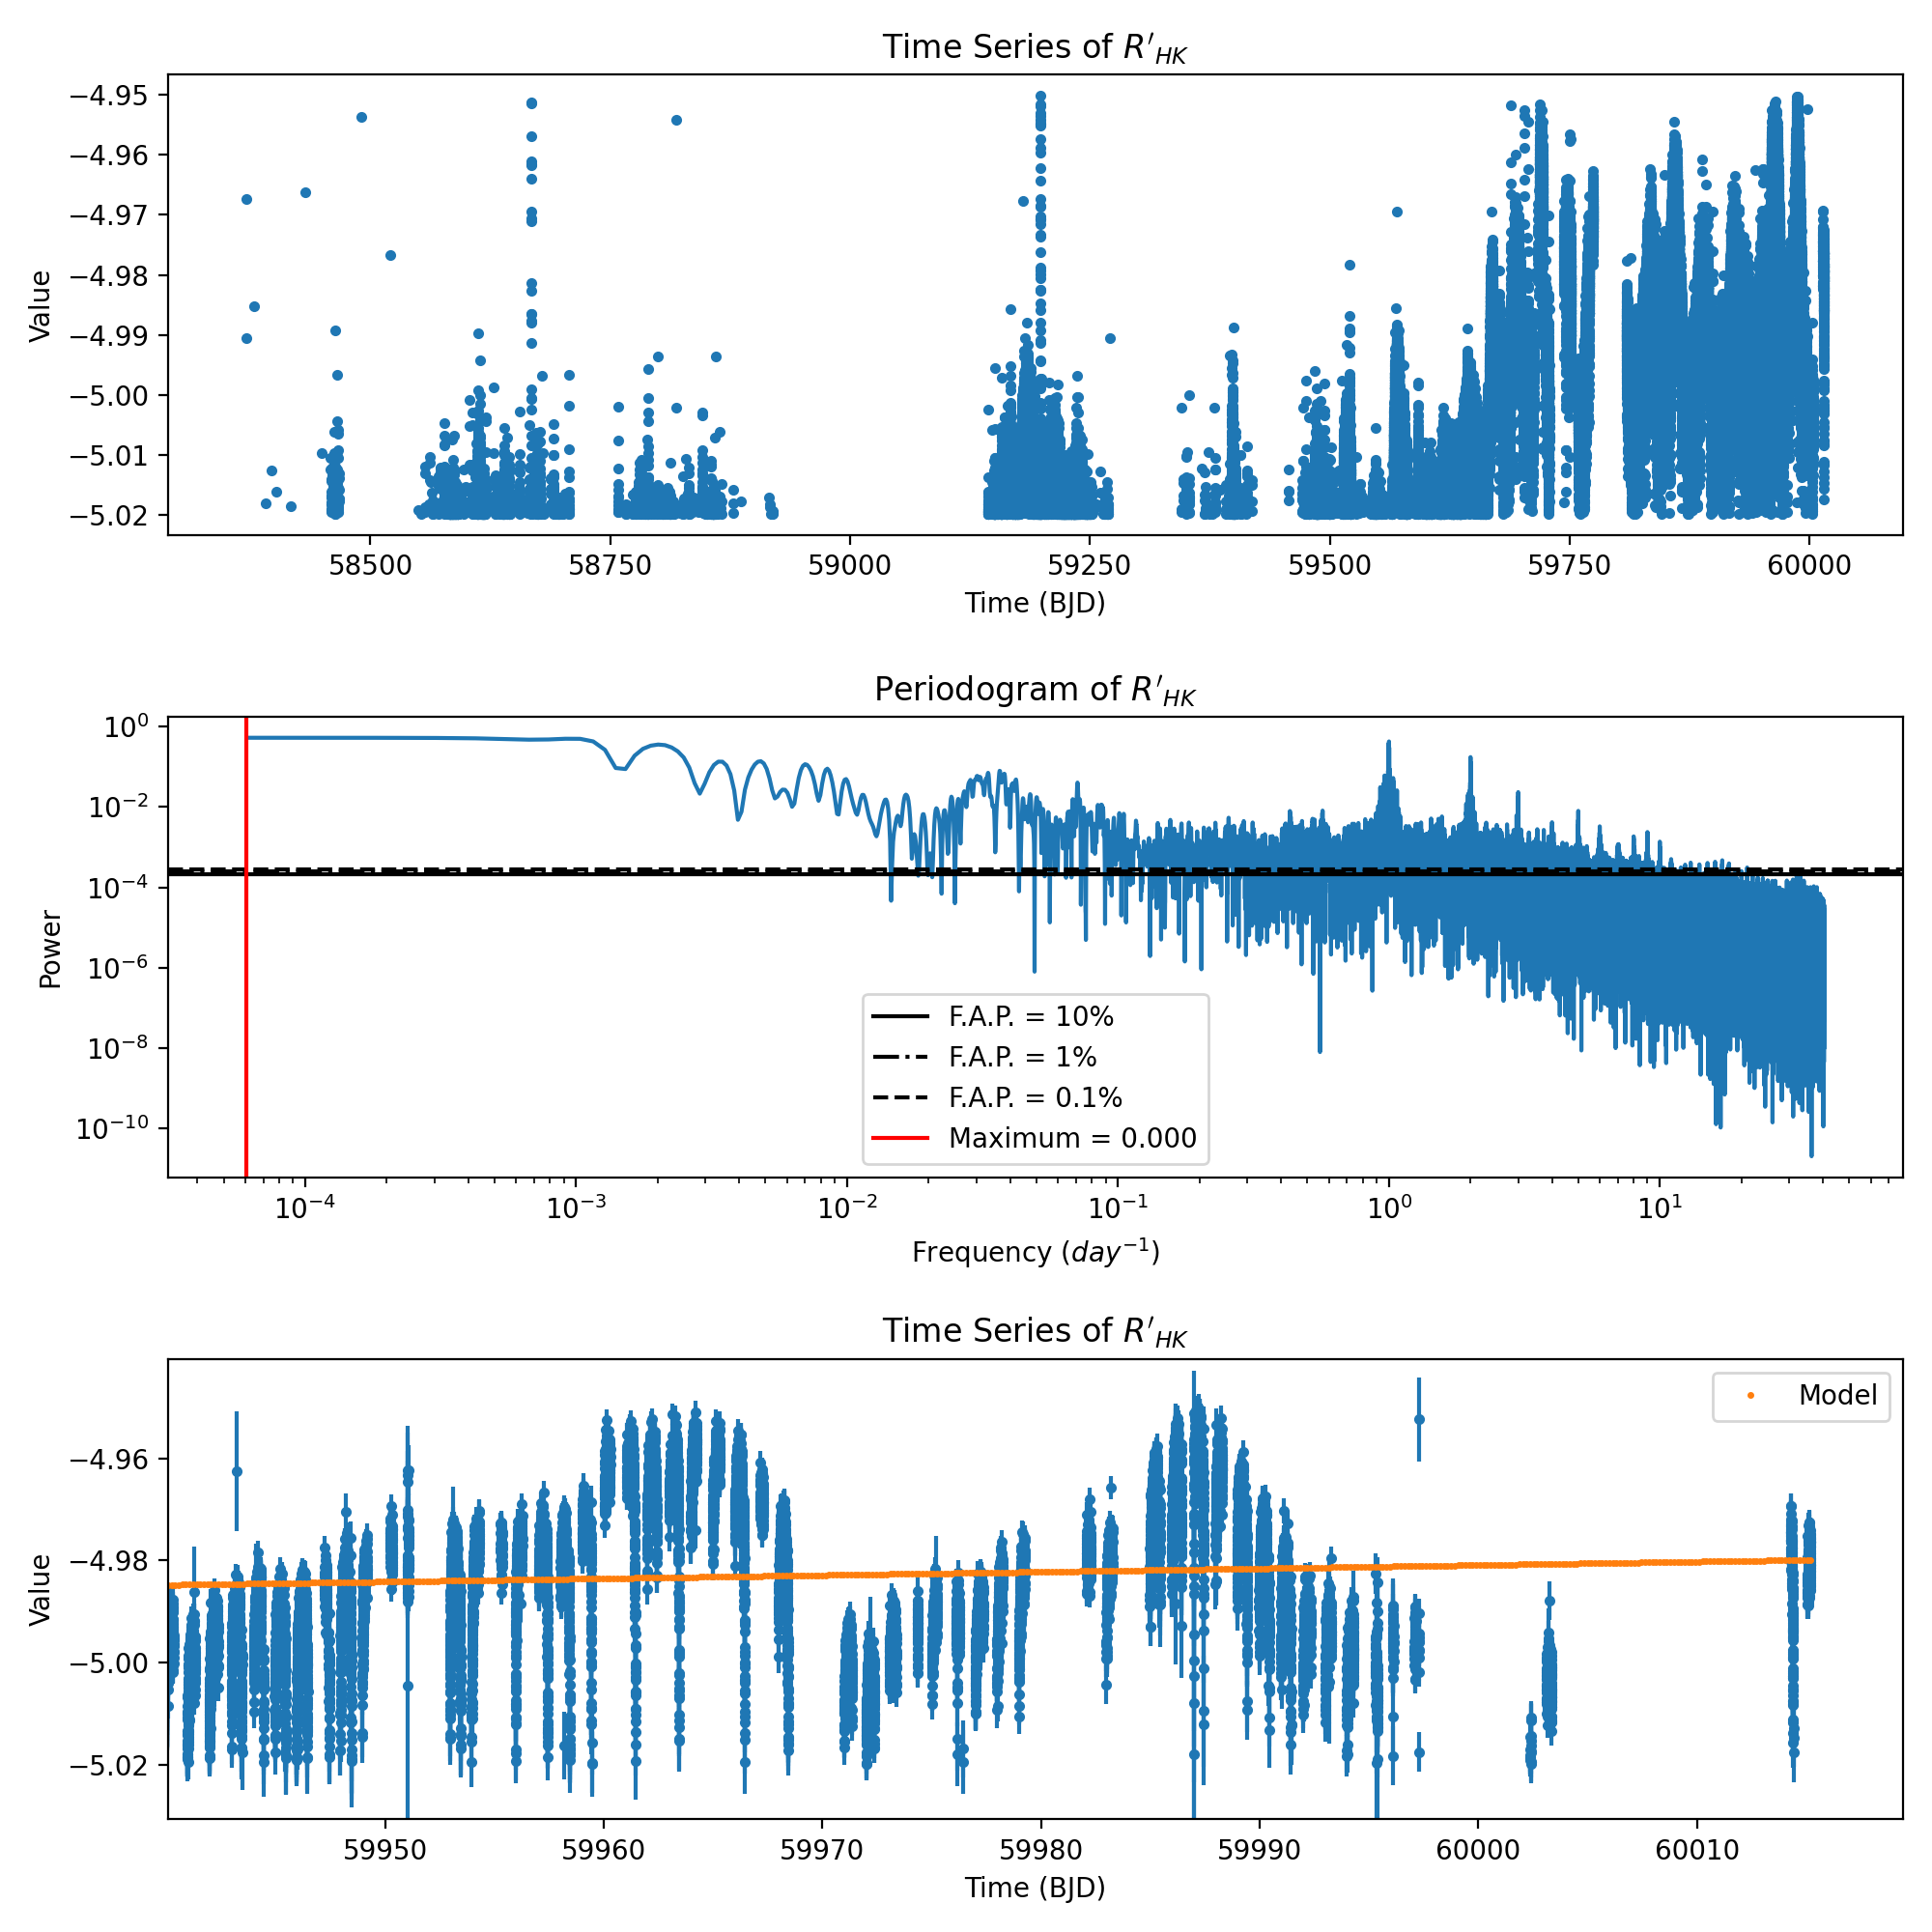

For R_HK
parameter: Amplitude Cos: 0.00040748465193867416
   95% conf interval: -0.04857231229898524 0.04938728160286259
   tstat: 0.013684362185352177
   pstat: 0.9890818199967621
parameter: Amplitude Sin: -0.5319281590007799
   95% conf interval: -0.5407098663228371 -0.5231464516787228
   tstat: -99.63325243922137
   pstat: 0.0
parameter: Offset: -4.4849748565636665
   95% conf interval: -4.493801361891577 -4.476148351235756
   tstat: -835.7983511211671
   pstat: 0.0
parameter: Period: 18132.32397752899
   95% conf interval: 18050.53681046951 18214.11114458847
   tstat: 364.66878481420724
   pstat: 0.0


<IPython.core.display.Javascript object>


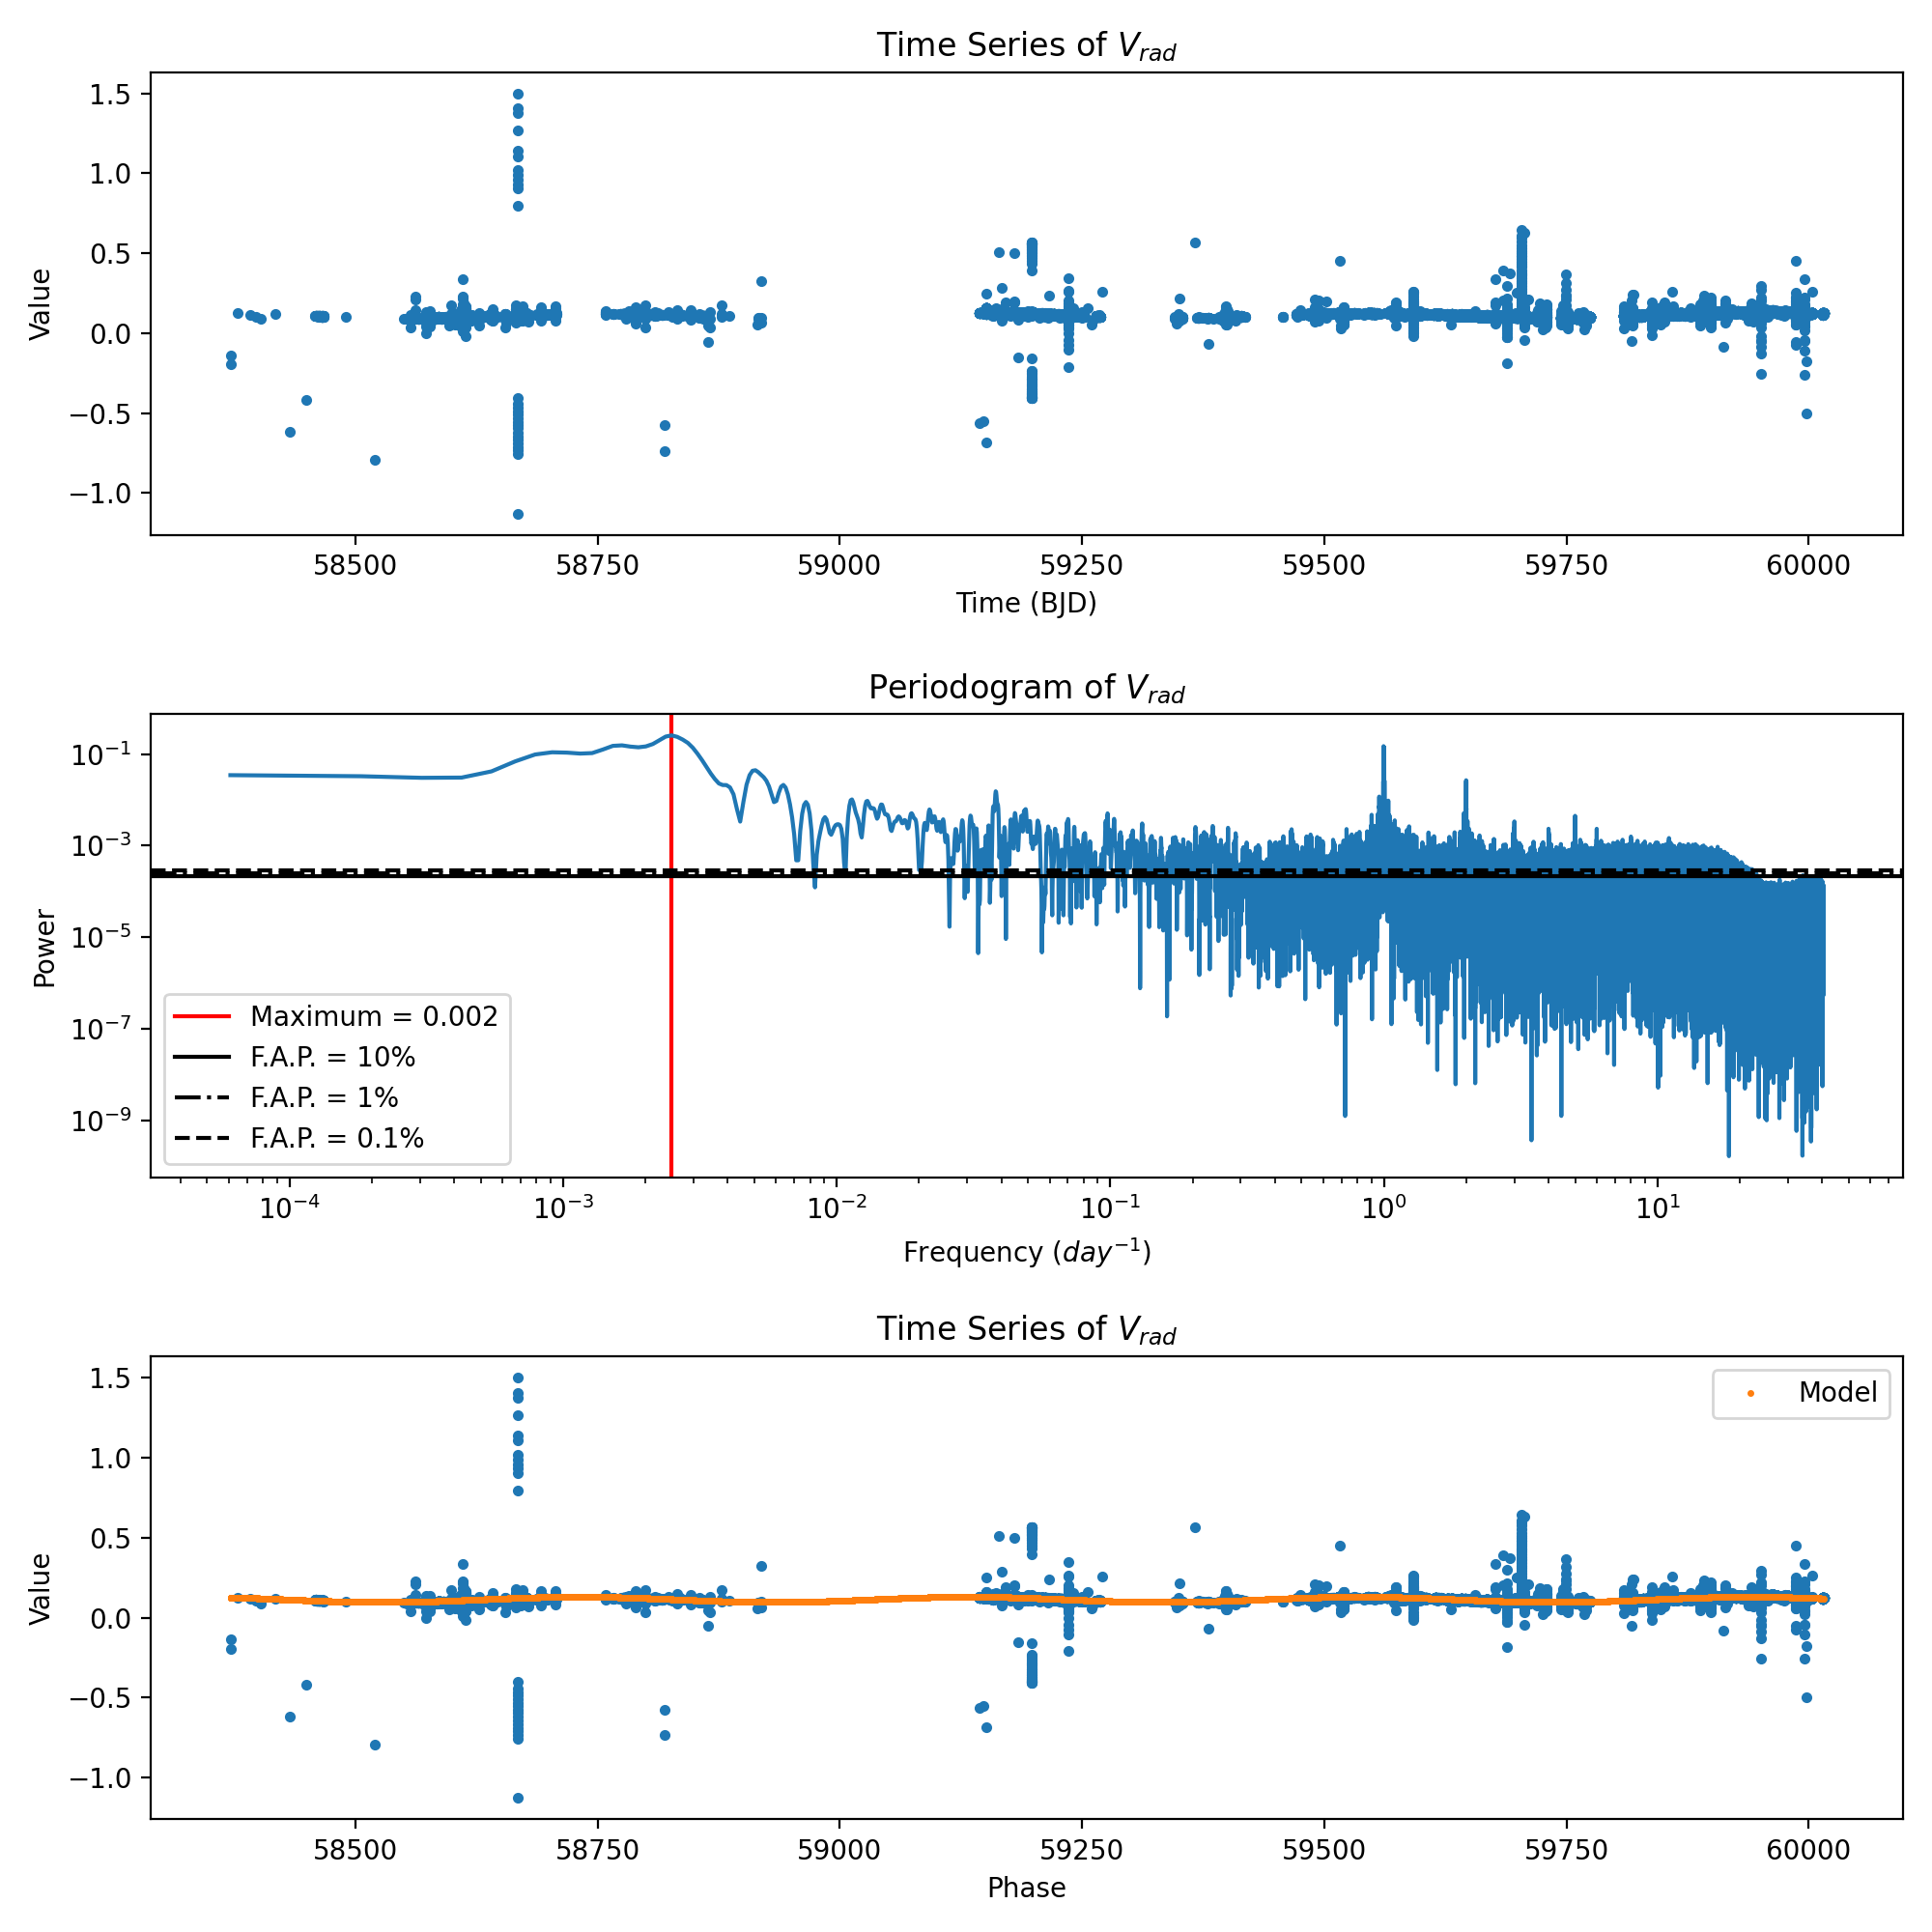

For Vrad
parameter: Amplitude Cos: -0.0012249392624513371
   95% conf interval: -0.025571680781593133 0.02312180225669046
   tstat: -0.08275685829572743
   pstat: 0.9340449981700312
parameter: Amplitude Sin: -0.016681788843000252
   95% conf interval: -0.01847004723050805 -0.014893530455492455
   tstat: -15.344142883910452
   pstat: 0.0
parameter: Offset: 0.11395276134627721
   95% conf interval: 0.1138483326269412 0.11405719006561323
   tstat: 1794.8790424162873
   pstat: 0.0
parameter: Period: 402.9862679441642
   95% conf interval: 402.3536419932139 403.61889389511447
   tstat: 1047.7882632281398
   pstat: 0.0


In [113]:
reload(AF)
#Calcium indicator 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10, 10])
ax1.plot(rhk_BJD_date, rhk, '.')
ax1.set_xlabel('Time (BJD)')
ax1.set_ylabel('Value')
ax1.set_title('Time Series of $R\'_{HK}$')

ls = LombScargle(rhk_BJD_date, rhk, rhk_err)
LS = ls.autopower(nyquist_factor=1)
probas = [0.1, 0.01, 0.001]
FAP = ls.false_alarm_level(probas, nyquist_factor=1)  

ax2.loglog(LS[0], LS[1])
ax2.axhline(FAP[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
ax2.axhline(FAP[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
ax2.axhline(FAP[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')

if max(LS[1])>FAP[0]:
    max_power= np.where(LS[1]==max(LS[1]))
    ax2.axvline(LS[0][max_power], color='r', label='Maximum = %.3f' %LS[0][max_power])
ax2.set_xlabel('Frequency ($day^{-1}$)')
ax2.set_ylabel('Power')
ax2.set_title('Periodogram of $R\'_{HK}$')
ax2.legend()

#Fitting the long-term trend to the data
important_freq = LS[0][max_power]

#Creating a basic sinusoidal function
def sinusoid(t, A, B, offset, period):
    return offset+A*np.cos(2*np.pi*t/period) + B*np.sin(2*np.pi*t/period)

#Setting a guess
iniguess=[0.4, 1e-5, np.median(rhk), important_freq[0]**(-1)]

best_fit_theta, best_fit_err = curve_fit(sinusoid, rhk_BJD_date, rhk, sigma=rhk_err, p0=iniguess, maxfev=20000)

#Evaluating the model
simulated_time = np.linspace(rhk_BJD_date[0], rhk_BJD_date[-1], 10000)
model = sinusoid(simulated_time, *best_fit_theta)

#Evaluating statistical significance
print('For R_HK')
param_name = ['Amplitude Cos', 'Amplitude Sin', 'Offset', 'Period']
AF.eval_stat(best_fit_theta, rhk_BJD_date, rhk, sinusoid, param_name)

ax3.errorbar(rhk_BJD_date, rhk, yerr=rhk_err, fmt='.', zorder=1)
ax3.plot(simulated_time, model, '.', label='Model', markersize=3, zorder=2)
ax3.set_xlabel('Time (BJD)')
ax3.set_ylabel('Value')
ax3.set_title('Time Series of $R\'_{HK}$')
ax3.legend()
fig.tight_layout()
plt.show()

#Radial velocity
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10, 10])
ax1.errorbar(rhk_BJD_date, new_vrad, yerr=new_vrad_err, fmt='.')
ax1.set_xlabel('Time (BJD)')
ax1.set_ylabel('Value')
ax1.set_title('Time Series of $V_{rad}$')

ls = LombScargle(rhk_BJD_date, new_vrad, new_vrad_err)
LS = ls.autopower(nyquist_factor=1)
FAP = ls.false_alarm_level(probas, nyquist_factor=1)  

if max(LS[1])>FAP[0]:
    max_power = np.where(LS[1]==max(LS[1]))
    ax2.axvline(LS[0][max_power], color='r', label='Maximum = %.3f' %LS[0][max_power])
ax2.loglog(LS[0], LS[1])
ax2.axhline(FAP[0], color='k', label='F.A.P. = '+str(int(100*probas[0]))+'%')
ax2.axhline(FAP[1], color='k', linestyle='-.', label='F.A.P. = '+str(int(100*probas[1]))+'%')
ax2.axhline(FAP[2], color='k', linestyle='--', label='F.A.P. = '+str(100*probas[2])+'%')
ax2.set_xlabel('Frequency ($day^{-1}$)')
ax2.set_ylabel('Power')
ax2.set_title('Periodogram of $V_{rad}$')
ax2.legend()

#Fitting the long-term trend to the data
important_freq = LS[0][max_power]

#Setting a guess
iniguess=[0.1, 0.1, np.median(new_vrad), important_freq[0]**(-1)]
best_fit_theta, best_fit_err = curve_fit(sinusoid, rhk_BJD_date, new_vrad, sigma=new_vrad_err, p0=iniguess)

#Evaluating the model
simulated_time = np.linspace(rhk_BJD_date[0], rhk_BJD_date[-1], 10000)
model = sinusoid(simulated_time, *best_fit_theta)

#Statistical Significance
print('For Vrad')
AF.eval_stat(best_fit_theta, rhk_BJD_date, new_vrad, sinusoid, param_name)

ax3.errorbar(rhk_BJD_date, new_vrad, yerr=new_vrad_err, fmt='.', zorder=1)
ax3.plot(simulated_time, model, '.', label='Model', markersize=3, zorder=2)
ax3.set_xlabel('Phase')
ax3.set_ylabel('Value')
ax3.set_title('Time Series of $V_{rad}$')
ax3.legend()
fig.tight_layout()


In [114]:
%matplotlib inline

# Interpolating the $R_{HK}$ and $V_{rad}$ values to the observations

[-4.96619471 -4.96621054 -4.96622638 -4.96624221 -4.96625805 -4.96627388
 -4.96628971 -4.96630555 -4.96632138 -4.96633722 -4.96635305 -4.96636888
 -4.96638472 -4.96640055 -4.96641639 -4.96643222 -4.96644806 -4.96646389
 -4.96647972 -4.96649556 -4.96651139 -4.96652723 -4.96654306 -4.96655889
 -4.96657473 -4.96659056 -4.9666064  -4.96662223 -4.96663806 -4.9666539
 -4.96666973 -4.96668557 -4.9667014  -4.96671723 -4.96673307 -4.9667489
 -4.96676474 -4.96678057 -4.96679641 -4.96681224 -4.96682807 -4.96684391
 -4.96685974 -4.96687558 -4.96689141 -4.96690724 -4.96692308 -4.96693891
 -4.96695475 -4.96697058 -4.96698641 -4.96700225 -4.96701808 -4.96703392
 -4.96704975 -4.96706559 -4.96708142 -4.96709725 -4.96711309 -4.96712892
 -4.96714476 -4.96716059 -4.96717642 -4.96719226 -4.96720809 -4.96722393
 -4.96723976 -4.96725559 -4.96727143 -4.96728726 -4.9673031  -4.96731893
 -4.96733476 -4.9673506  -4.96736643 -4.96738227 -4.9673981  -4.96741394
 -4.96742977 -4.9674456  -4.96746144 -4.96747727 -4.9

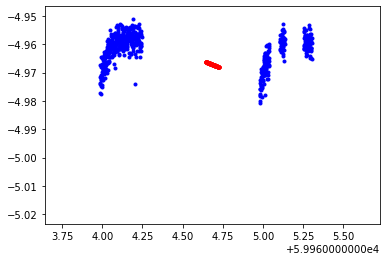

[-4.96814807 -4.9681639  -4.96817974 -4.96819557 -4.9682114  -4.96822724
 -4.96824307 -4.96825891 -4.96827474 -4.96829058 -4.96830641 -4.96832224
 -4.96833808 -4.96835391 -4.96836975 -4.96838558 -4.96840141 -4.96841725
 -4.96843308 -4.96844892 -4.96846475 -4.96848058 -4.96849642 -4.96851225
 -4.96852809 -4.96854392 -4.96855976 -4.96857559 -4.96859142 -4.96860726
 -4.96862309 -4.96863893 -4.96865476 -4.96867059 -4.96868643 -4.96870226
 -4.9687181  -4.96873393 -4.96874976 -4.9687656  -4.96878143 -4.96879727
 -4.9688131  -4.96882893 -4.96884477 -4.9688606  -4.96887644 -4.96889227
 -4.96890811 -4.96892394 -4.96893977 -4.96895561 -4.96897144 -4.96898728
 -4.96900311 -4.96901894 -4.96903478 -4.96905061 -4.96906645 -4.96908228
 -4.96909812 -4.96911395 -4.96912978 -4.96914562 -4.96916145 -4.96917729
 -4.96919312 -4.96920895 -4.96922479 -4.96924062 -4.96925646 -4.96927229
 -4.96928812 -4.96930396 -4.96931979 -4.96933563 -4.96935146 -4.9693673
 -4.96938313 -4.96939896 -4.9694148  -4.96943063 -4.

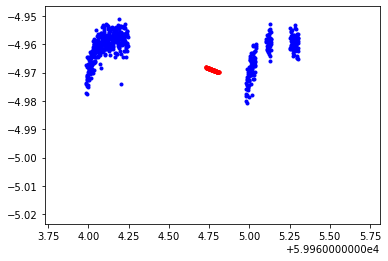

[-4.96620111 -4.96621283 -4.96622454 -4.96623625 -4.96624796 -4.96625967
 -4.96627138 -4.9662831  -4.96629481 -4.96630652 -4.96631823 -4.96632994
 -4.96634165 -4.96635337 -4.96636508 -4.96637679 -4.9663885  -4.96644706
 -4.96645877 -4.96647048 -4.96648219 -4.96649391 -4.96650562 -4.96651733
 -4.96652904 -4.96654075 -4.96655247 -4.96656418 -4.96657589 -4.9665876
 -4.96659931 -4.96661102 -4.96662274 -4.96663445 -4.96664616 -4.96665787
 -4.96666958 -4.96668129 -4.96669301 -4.96670472 -4.96671643 -4.96672814
 -4.96673985 -4.96675156 -4.96676328 -4.96677499 -4.9667867  -4.96679841
 -4.96681012 -4.96682183 -4.96683355 -4.96684526 -4.96685697 -4.96686868
 -4.96688039 -4.9668921  -4.96690382 -4.96691553 -4.96692724 -4.96693895
 -4.96695066 -4.96696237 -4.96697409 -4.9669858  -4.96699751 -4.96700922
 -4.96702093 -4.96703264 -4.96704436 -4.96705607 -4.96706778 -4.96707949
 -4.9670912  -4.96710291 -4.96711463 -4.96712634 -4.96713805 -4.96714976
 -4.96716147 -4.96717318 -4.9671849  -4.96719661 -4.

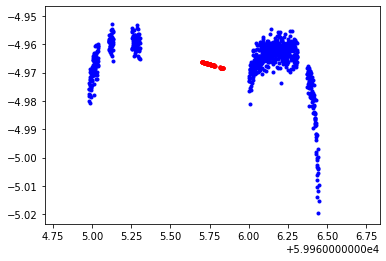

[-4.96327738 -4.96328909 -4.9633008  -4.96331251 -4.96332423 -4.96333594
 -4.96334765 -4.96335936 -4.96337107 -4.96338279 -4.9633945  -4.96340621
 -4.96341792 -4.96342963 -4.96344134 -4.96345306 -4.96346477 -4.96347648
 -4.96348819 -4.9634999  -4.96351161 -4.96352333 -4.96353504 -4.96354675
 -4.96355846 -4.96357017 -4.96358188 -4.9635936  -4.96360531 -4.96361702
 -4.96362873 -4.96364044 -4.96365215 -4.96366387 -4.96367558 -4.96368729
 -4.963699   -4.96371071 -4.96372242 -4.96373414 -4.96374585 -4.96375756
 -4.96376927 -4.96442732 -4.96443903 -4.96445074 -4.96446245 -4.96447417
 -4.96448588 -4.96449759 -4.9645093  -4.96452101 -4.96453272 -4.96454444
 -4.96455615 -4.96456786 -4.96457957 -4.96459128 -4.96460299 -4.96461471
 -4.96462642 -4.96463813 -4.96464984 -4.96466155 -4.96467326 -4.96468498
 -4.96469669 -4.9647084  -4.96472011 -4.96473182 -4.96474353 -4.96475525
 -4.96476696 -4.96477867 -4.96479038 -4.96480209 -4.9648138  -4.96482552
 -4.96483723 -4.96484894 -4.96486065 -4.96487236 -4

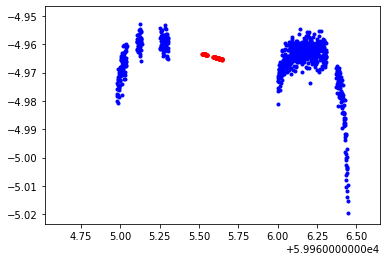

[-4.99844535 -4.99839833 -4.9983513  -4.99830428 -4.99825726 -4.99821023
 -4.99816321 -4.99811619 -4.99806917 -4.99802214 -4.99797512 -4.9979281
 -4.99788107 -4.99783405 -4.99778703 -4.99774001 -4.99750489 -4.99745787
 -4.99741085 -4.99736382 -4.9973168  -4.99726978 -4.99722275 -4.99717573
 -4.99712871 -4.99708169 -4.99703466 -4.99698764 -4.99694062 -4.99689359
 -4.99684657 -4.99679955 -4.99675253 -4.9967055  -4.99665848 -4.99661146
 -4.99656443 -4.99651741 -4.99647039 -4.99642337 -4.99637634 -4.99632932
 -4.99624809 -4.99620107 -4.99615405 -4.99610702 -4.9960258  -4.99597877
 -4.99593175 -4.99588473 -4.9958377  -4.99579068 -4.99574366 -4.99569664
 -4.99564961 -4.99560259 -4.99555557 -4.99550854 -4.99546152 -4.9954145
 -4.99536748 -4.99532045 -4.99527343 -4.99522641 -4.99517938 -4.99513236
 -4.99508534 -4.99503832 -4.99499129 -4.99494427 -4.9948032  -4.99475618
 -4.99470916 -4.99466213 -4.99461511 -4.99456809 -4.99452106 -4.99447404
 -4.99442702 -4.99438    -4.99433297 -4.99428595 -4.9

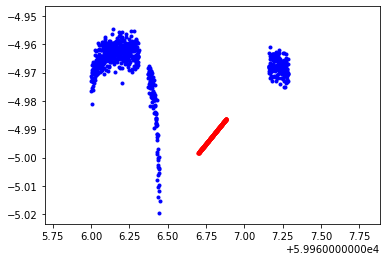

[-4.97921471 -4.97923975 -4.97926479 -4.97928982 -4.97931486 -4.9793399
 -4.97936494 -4.97938998 -4.97941501 -4.97944005 -4.97946509 -4.97949013
 -4.97951516 -4.9795402  -4.97956524 -4.97959028 -4.97961532 -4.97964035
 -4.97966539 -4.97969043 -4.97971547 -4.97974051 -4.97976554 -4.97979058
 -4.97981562 -4.97984066 -4.97986569 -4.97989073 -4.97991577 -4.97994081
 -4.97996585 -4.97999088 -4.98001592 -4.98004096 -4.980066   -4.98009103
 -4.98011607 -4.98014111 -4.98016615 -4.98019119 -4.98021622 -4.98024126
 -4.9802663  -4.98029134 -4.98031637 -4.98034141 -4.98036645 -4.98039149
 -4.98041653 -4.98044156 -4.9804666  -4.98049164 -4.98051668 -4.98054172
 -4.98056675 -4.98059179 -4.98061683 -4.98064187 -4.9806669  -4.98069194
 -4.98071698 -4.98074202 -4.98076706 -4.98079209 -4.98081713 -4.98084217
 -4.98086721 -4.98089224 -4.98091728 -4.98094232 -4.98096736 -4.9809924
 -4.98101743 -4.98104247 -4.98106751 -4.98109255 -4.98111759 -4.98114262
 -4.98116766 -4.9811927  -4.98121774 -4.98124277 -4.9

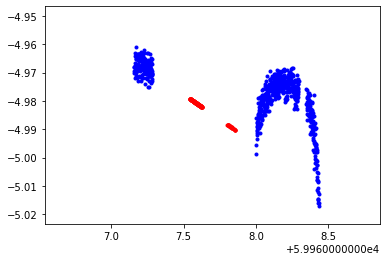

[-4.97846357 -4.97848861 -4.97851365 -4.97853869 -4.97856372 -4.97858876
 -4.9786138  -4.97863884 -4.97866387 -4.97868891 -4.97871395 -4.97873899
 -4.97876403 -4.97878906 -4.9788141  -4.97883914 -4.97886418 -4.97888922
 -4.97891425 -4.97893929 -4.97896433 -4.97898937 -4.9790144  -4.97903944
 -4.97906448 -4.97908952 -4.97911456 -4.97913959 -4.98440686 -4.9844319
 -4.98445694 -4.98448198 -4.98457075 -4.98461627 -4.9846618  -4.98470732
 -4.98485755 -4.98494404 -4.98503053 -4.98526726 -4.98531278 -4.9853583
 -4.98540382 -4.9854926  -4.98551764 -4.98554267 -4.98556771 -4.98565648
 -4.98570201 -4.98574753 -4.98579305 -4.98590231 -4.98594783 -4.98599336
 -4.98603888 -4.98612765 -4.98615269 -4.98617773 -4.98620277]


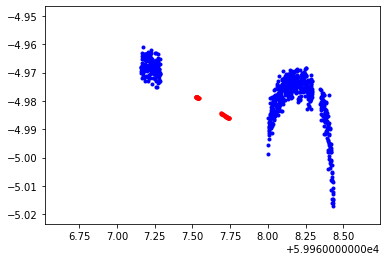

[-5.01613849 -5.01613866 -5.01613882 -5.01613899 -5.01613915 -5.01613932
 -5.01613949 -5.01613965 -5.01613982 -5.01613998 -5.01614015 -5.01614032
 -5.01614048 -5.01614065 -5.01614081 -5.01614098 -5.01614115 -5.01614131
 -5.01614148 -5.01614164 -5.01614181 -5.01614198 -5.01614214 -5.01614231
 -5.01614247 -5.01614264 -5.01614281 -5.01614297 -5.01614314 -5.0161433
 -5.01614347 -5.01614364 -5.0161438  -5.01614397 -5.01614413 -5.0161443
 -5.01614447 -5.01614463 -5.0161448  -5.01614496 -5.01614513 -5.0161453
 -5.01614546 -5.01614563 -5.01614579 -5.01614596 -5.01614613 -5.01614629
 -5.01614646 -5.01614662 -5.01614679 -5.01614696 -5.01614712 -5.01614729
 -5.01614745 -5.01614762 -5.01614779 -5.01614795 -5.01614812 -5.01614828
 -5.01614845 -5.01614861 -5.01614878 -5.01614895 -5.01614911 -5.01614928
 -5.01614944 -5.01614961 -5.01614978 -5.01614994 -5.01615011 -5.01615027
 -5.01615044 -5.01615061 -5.01615077 -5.01615094 -5.0161511  -5.01615127
 -5.01615144 -5.0161516  -5.01615177 -5.01615193 -5.01

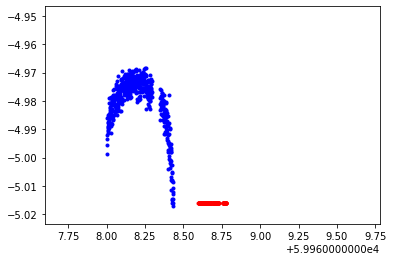

[-5.01639478 -5.01639508 -5.01639538 -5.01639568 -5.01639598 -5.01639628
 -5.01639659 -5.01639689 -5.01639719 -5.01639749 -5.01639779 -5.01639809
 -5.0163984  -5.0163996  -5.01639991 -5.01640021 -5.01640051 -5.01640081
 -5.01640111 -5.01640141 -5.01640172 -5.01640202 -5.01640232 -5.01640262
 -5.01640292 -5.01640323 -5.01640353 -5.01640383 -5.01640413 -5.01640443
 -5.01640473 -5.01640504 -5.01640534 -5.01640564 -5.01640594 -5.01640624
 -5.01640654 -5.01640701 -5.01640748 -5.01640795 -5.01640842 -5.01640888
 -5.01640935 -5.01640982 -5.01641029 -5.01641075 -5.01641122 -5.01641169
 -5.01641216 -5.01641263 -5.01641312 -5.01641359 -5.01641406 -5.01641453
 -5.016415   -5.01641546 -5.01641593 -5.0164164  -5.01641687 -5.01641733
 -5.0164178  -5.01641827 -5.01641874 -5.01641921 -5.01641967 -5.01642014
 -5.01642061 -5.01642108 -5.01642154 -5.01642201 -5.01642248 -5.01642295
 -5.01642342 -5.01642388 -5.01642435 -5.01642482 -5.01642529 -5.01642575
 -5.01642622 -5.01642669 -5.01642716 -5.01642763 -5

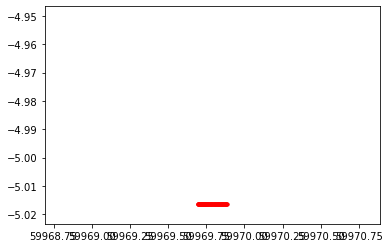

[-5.01659636 -5.01659653 -5.01659669 -5.01659686 -5.01659702 -5.01659719
 -5.01659736 -5.01659752 -5.01659769 -5.01659785 -5.01659802 -5.01659819
 -5.01659835 -5.01659852 -5.01659868 -5.01659885 -5.01659902 -5.01659918
 -5.01659935 -5.01659951 -5.01659968 -5.01659985 -5.01660001 -5.01660018
 -5.01660034 -5.01660051 -5.01660068 -5.01660084 -5.01660101 -5.01660117
 -5.01660134 -5.01660151 -5.01660167 -5.01660184 -5.016602   -5.01660217
 -5.01660234 -5.0166025  -5.01660267 -5.01660283 -5.016603   -5.01660317
 -5.01660333 -5.0166035  -5.01660366 -5.01660383 -5.016604   -5.01660416
 -5.01660433 -5.01660449 -5.01660466 -5.01660483 -5.01660499 -5.01660516
 -5.01660532 -5.01660549 -5.01660566 -5.01660582 -5.01660599 -5.01660615
 -5.01660632 -5.01660649 -5.01660665 -5.01660682 -5.01660698 -5.01660715
 -5.01660732 -5.01660748 -5.01660765 -5.01660781 -5.01660798 -5.01660815
 -5.01660831 -5.01660848 -5.01660864 -5.01660881 -5.01660898 -5.01660914
 -5.01660931 -5.01660947 -5.01660964 -5.0166098  -5

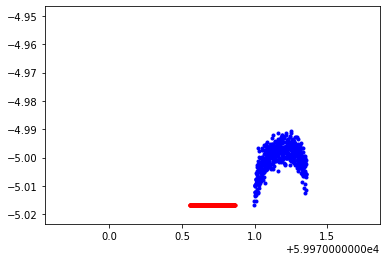

[-5.0054458  -5.00545865 -5.0054715  -5.00549719 -5.00551004 -5.00552288
 -5.00553573 -5.00554858 -5.00556142 -5.00557427 -5.00558712 -5.00559997
 -5.00561281 -5.00562566 -5.00563851 -5.00565135 -5.0056642  -5.00567705
 -5.00568989 -5.00570274 -5.00571559 -5.00572843 -5.00574128 -5.00575413
 -5.00576697 -5.00577982 -5.00579267 -5.00580552 -5.00581836 -5.00583121
 -5.00584406 -5.0058569  -5.00586975 -5.0058826  -5.00589544 -5.00590829
 -5.00592114 -5.00593398 -5.00594683 -5.00595968 -5.00597252 -5.00598537
 -5.00599822 -5.00601107 -5.00602391 -5.00603676 -5.00604961 -5.00606245
 -5.0060753  -5.00608815 -5.00610099 -5.00611384 -5.00612669 -5.00613953
 -5.00615238 -5.00616523 -5.00617807 -5.00619092 -5.00620377 -5.00621662
 -5.00622946 -5.00624231 -5.00625516 -5.006268   -5.00628085 -5.0062937
 -5.00630654 -5.00631939 -5.00633224 -5.00634508 -5.00635793 -5.00637078
 -5.00638362 -5.00639647 -5.00640932 -5.00642217 -5.00643501 -5.00644786
 -5.00646071 -5.00647355 -5.0064864  -5.00649925 -5.

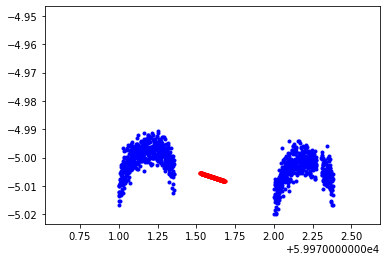

[-5.01364116 -5.01362886 -5.01361656 -5.01360426 -5.01359196 -5.01357967
 -5.01356737 -5.01355507 -5.01354277 -5.01353047 -5.01351817 -5.01350588
 -5.01349358 -5.01348128 -5.01346898 -5.01345668 -5.01344439 -5.01343209
 -5.01341979 -5.01340749 -5.01339519 -5.0133829  -5.0133706  -5.0133583
 -5.013346   -5.0133337  -5.0133214  -5.01330911 -5.01329681 -5.01328451
 -5.01327221 -5.01325991 -5.01324762 -5.01323532 -5.01322302 -5.01321072
 -5.01319842 -5.01318612 -5.01317383 -5.01316153 -5.01314923 -5.01313693
 -5.01312463 -5.01311234 -5.01310004 -5.01308774 -5.01307544 -5.01306314
 -5.01305085 -5.01303855 -5.01302625 -5.01301395 -5.01300165 -5.01298935
 -5.01297706 -5.01296476 -5.01295246 -5.01294016 -5.01292786 -5.01291557
 -5.01290327 -5.01289097 -5.01287867 -5.01286637 -5.01285408 -5.01284178
 -5.01282948 -5.01281718 -5.01280488 -5.01279258 -5.01278029 -5.01276799
 -5.01275569 -5.01274339 -5.01273109 -5.0127188  -5.0127065  -5.0126942
 -5.0126819  -5.0126696  -5.0126573  -5.01264501 -5.0

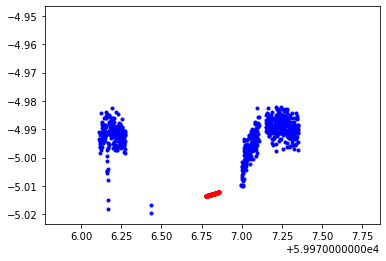

[-4.99776197 -4.99777115 -4.99778033 -4.99778952 -4.9977987  -4.99780788
 -4.99781707 -4.99782625 -4.99783543 -4.99784462 -4.9978538  -4.99786298
 -4.99787217 -4.99788135 -4.99789053 -4.99789972 -4.9979089  -4.99791808
 -4.99792727 -4.99793645 -4.99794563 -4.99795482 -4.997964   -4.99797318
 -4.99798237 -4.99799155 -4.99800073 -4.99800992 -4.9980191  -4.99802828
 -4.99803747 -4.99804665 -4.99805583 -4.99806502 -4.9980742  -4.99808338
 -4.99809257 -4.99810175 -4.99811093 -4.99812012 -4.9981293  -4.99813848
 -4.99814767 -4.99815685 -4.99816603 -4.99817522 -4.9981844  -4.99819358
 -4.99820277 -4.99821195 -4.99822113 -4.99823032 -4.9982395  -4.99824869
 -4.99825787 -4.99826705 -4.99827624 -4.99828542 -4.9982946  -4.99830379
 -4.99831297 -4.99832215 -4.99833134 -4.99834052 -4.9983497  -4.99835889
 -4.99836807 -4.99837725 -4.99838644 -4.99839562 -4.9984048  -4.99841399
 -4.99842317 -4.99843235 -4.99844154 -4.99845072 -4.9984599  -4.99846909
 -4.99847827 -4.99848745 -4.99849664 -4.99850582 -4

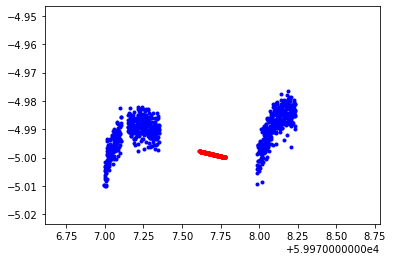

[-4.997149   -4.99716545 -4.9971819  -4.99719835 -4.9972148  -4.99723125
 -4.9972477  -4.99726415 -4.9972806  -4.99729706 -4.99731351 -4.99732996
 -4.99734641 -4.99736286 -4.99737931 -4.99739576 -4.99741221 -4.99742866
 -4.99744511 -4.99746156 -4.99747801 -4.99749446 -4.99751091 -4.99752736
 -4.99754381 -4.99756026 -4.99757671 -4.99759316 -4.99760961 -4.99762606
 -4.99764251 -4.99765896 -4.99767541 -4.99769186 -4.99770832 -4.99772477
 -4.99774122 -4.99775767 -4.99777412 -4.99779057 -4.99780702 -4.99782347
 -4.99783992 -4.99785637 -4.99787282 -4.99788927 -4.99790572 -4.99792217
 -4.99793862 -4.99795507 -4.99797152 -4.99798797 -4.99800442 -4.99802087
 -4.99803732 -4.99805377 -4.99807022 -4.99808667 -4.99810312 -4.99811957
 -4.99813603 -4.99815248 -4.99816893 -4.99818538 -4.99820183 -4.99821828
 -4.99823473 -4.99825118 -4.99826763 -4.99828408 -4.99830053 -4.99831698
 -4.99833343 -4.99834988 -4.99836633 -4.99838278 -4.99839923 -4.99841568
 -4.99843213 -4.99844858 -4.99846503 -4.99848148 -4

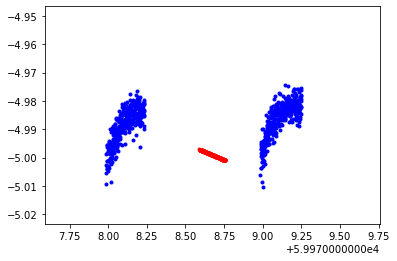

[-4.96619471 -4.96621054 -4.96622638 -4.96624221 -4.96625805 -4.96627388
 -4.96628971 -4.96630555 -4.96632138 -4.96633722 -4.96635305 -4.96636888
 -4.96638472 -4.96640055 -4.96641639 -4.96643222 -4.96644806 -4.96646389
 -4.96647972 -4.96649556 -4.96651139 -4.96652723 -4.96654306 -4.96655889
 -4.96657473 -4.96659056 -4.9666064  -4.96662223 -4.96663806 -4.9666539
 -4.96666973 -4.96668557 -4.9667014  -4.96671723 -4.96673307 -4.9667489
 -4.96676474 -4.96678057 -4.96679641 -4.96681224 -4.96682807 -4.96684391
 -4.96685974 -4.96687558 -4.96689141 -4.96690724 -4.96692308 -4.96693891
 -4.96695475 -4.96697058 -4.96698641 -4.96700225 -4.96701808 -4.96703392
 -4.96704975 -4.96706559 -4.96708142 -4.96709725 -4.96711309 -4.96712892
 -4.96714476 -4.96716059 -4.96717642 -4.96719226 -4.96720809 -4.96722393
 -4.96723976 -4.96725559 -4.96727143 -4.96728726 -4.9673031  -4.96731893
 -4.96733476 -4.9673506  -4.96736643 -4.96738227 -4.9673981  -4.96741394
 -4.96742977 -4.9674456  -4.96746144 -4.96747727 -4.9

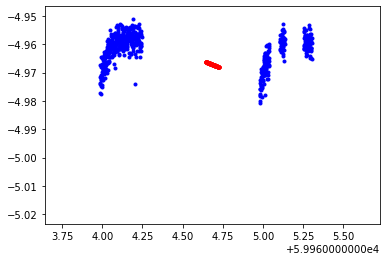

[-4.96814807 -4.9681639  -4.96817974 -4.96819557 -4.9682114  -4.96822724
 -4.96824307 -4.96825891 -4.96827474 -4.96829058 -4.96830641 -4.96832224
 -4.96833808 -4.96835391 -4.96836975 -4.96838558 -4.96840141 -4.96841725
 -4.96843308 -4.96844892 -4.96846475 -4.96848058 -4.96849642 -4.96851225
 -4.96852809 -4.96854392 -4.96855976 -4.96857559 -4.96859142 -4.96860726
 -4.96862309 -4.96863893 -4.96865476 -4.96867059 -4.96868643 -4.96870226
 -4.9687181  -4.96873393 -4.96874976 -4.9687656  -4.96878143 -4.96879727
 -4.9688131  -4.96882893 -4.96884477 -4.9688606  -4.96887644 -4.96889227
 -4.96890811 -4.96892394 -4.96893977 -4.96895561 -4.96897144 -4.96898728
 -4.96900311 -4.96901894 -4.96903478 -4.96905061 -4.96906645 -4.96908228
 -4.96909812 -4.96911395 -4.96912978 -4.96914562 -4.96916145 -4.96917729
 -4.96919312 -4.96920895 -4.96922479 -4.96924062 -4.96925646 -4.96927229
 -4.96928812 -4.96930396 -4.96931979 -4.96933563 -4.96935146 -4.9693673
 -4.96938313 -4.96939896 -4.9694148  -4.96943063 -4.

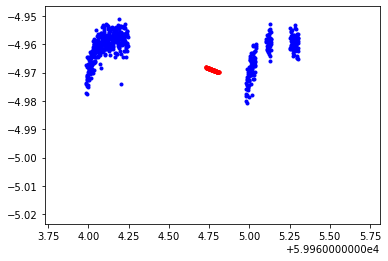

[-4.96620111 -4.96621283 -4.96622454 -4.96623625 -4.96624796 -4.96625967
 -4.96627138 -4.9662831  -4.96629481 -4.96630652 -4.96631823 -4.96632994
 -4.96634165 -4.96635337 -4.96636508 -4.96637679 -4.9663885  -4.96644706
 -4.96645877 -4.96647048 -4.96648219 -4.96649391 -4.96650562 -4.96651733
 -4.96652904 -4.96654075 -4.96655247 -4.96656418 -4.96657589 -4.9665876
 -4.96659931 -4.96661102 -4.96662274 -4.96663445 -4.96664616 -4.96665787
 -4.96666958 -4.96668129 -4.96669301 -4.96670472 -4.96671643 -4.96672814
 -4.96673985 -4.96675156 -4.96676328 -4.96677499 -4.9667867  -4.96679841
 -4.96681012 -4.96682183 -4.96683355 -4.96684526 -4.96685697 -4.96686868
 -4.96688039 -4.9668921  -4.96690382 -4.96691553 -4.96692724 -4.96693895
 -4.96695066 -4.96696237 -4.96697409 -4.9669858  -4.96699751 -4.96700922
 -4.96702093 -4.96703264 -4.96704436 -4.96705607 -4.96706778 -4.96707949
 -4.9670912  -4.96710291 -4.96711463 -4.96712634 -4.96713805 -4.96714976
 -4.96716147 -4.96717318 -4.9671849  -4.96719661 -4.

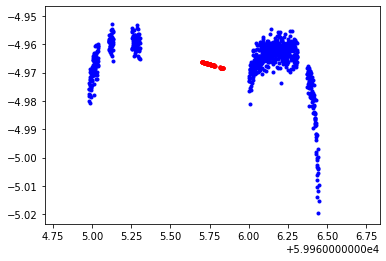

[-4.96327738 -4.96328909 -4.9633008  -4.96331251 -4.96332423 -4.96333594
 -4.96334765 -4.96335936 -4.96337107 -4.96338279 -4.9633945  -4.96340621
 -4.96341792 -4.96342963 -4.96344134 -4.96345306 -4.96346477 -4.96347648
 -4.96348819 -4.9634999  -4.96351161 -4.96352333 -4.96353504 -4.96354675
 -4.96355846 -4.96357017 -4.96358188 -4.9635936  -4.96360531 -4.96361702
 -4.96362873 -4.96364044 -4.96365215 -4.96366387 -4.96367558 -4.96368729
 -4.963699   -4.96371071 -4.96372242 -4.96373414 -4.96374585 -4.96375756
 -4.96376927 -4.96442732 -4.96443903 -4.96445074 -4.96446245 -4.96447417
 -4.96448588 -4.96449759 -4.9645093  -4.96452101 -4.96453272 -4.96454444
 -4.96455615 -4.96456786 -4.96457957 -4.96459128 -4.96460299 -4.96461471
 -4.96462642 -4.96463813 -4.96464984 -4.96466155 -4.96467326 -4.96468498
 -4.96469669 -4.9647084  -4.96472011 -4.96473182 -4.96474353 -4.96475525
 -4.96476696 -4.96477867 -4.96479038 -4.96480209 -4.9648138  -4.96482552
 -4.96483723 -4.96484894 -4.96486065 -4.96487236 -4

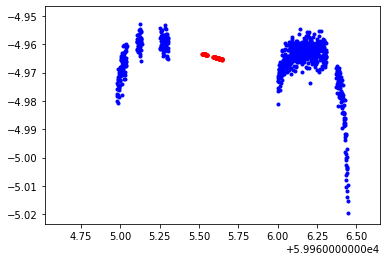

[-4.99844535 -4.99839833 -4.9983513  -4.99830428 -4.99825726 -4.99821023
 -4.99816321 -4.99811619 -4.99806917 -4.99802214 -4.99797512 -4.9979281
 -4.99788107 -4.99783405 -4.99778703 -4.99774001 -4.99750489 -4.99745787
 -4.99741085 -4.99736382 -4.9973168  -4.99726978 -4.99722275 -4.99717573
 -4.99712871 -4.99708169 -4.99703466 -4.99698764 -4.99694062 -4.99689359
 -4.99684657 -4.99679955 -4.99675253 -4.9967055  -4.99665848 -4.99661146
 -4.99656443 -4.99651741 -4.99647039 -4.99642337 -4.99637634 -4.99632932
 -4.99624809 -4.99620107 -4.99615405 -4.99610702 -4.9960258  -4.99597877
 -4.99593175 -4.99588473 -4.9958377  -4.99579068 -4.99574366 -4.99569664
 -4.99564961 -4.99560259 -4.99555557 -4.99550854 -4.99546152 -4.9954145
 -4.99536748 -4.99532045 -4.99527343 -4.99522641 -4.99517938 -4.99513236
 -4.99508534 -4.99503832 -4.99499129 -4.99494427 -4.9948032  -4.99475618
 -4.99470916 -4.99466213 -4.99461511 -4.99456809 -4.99452106 -4.99447404
 -4.99442702 -4.99438    -4.99433297 -4.99428595 -4.9

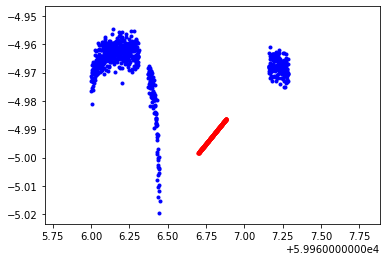

[-4.97921471 -4.97923975 -4.97926479 -4.97928982 -4.97931486 -4.9793399
 -4.97936494 -4.97938998 -4.97941501 -4.97944005 -4.97946509 -4.97949013
 -4.97951516 -4.9795402  -4.97956524 -4.97959028 -4.97961532 -4.97964035
 -4.97966539 -4.97969043 -4.97971547 -4.97974051 -4.97976554 -4.97979058
 -4.97981562 -4.97984066 -4.97986569 -4.97989073 -4.97991577 -4.97994081
 -4.97996585 -4.97999088 -4.98001592 -4.98004096 -4.980066   -4.98009103
 -4.98011607 -4.98014111 -4.98016615 -4.98019119 -4.98021622 -4.98024126
 -4.9802663  -4.98029134 -4.98031637 -4.98034141 -4.98036645 -4.98039149
 -4.98041653 -4.98044156 -4.9804666  -4.98049164 -4.98051668 -4.98054172
 -4.98056675 -4.98059179 -4.98061683 -4.98064187 -4.9806669  -4.98069194
 -4.98071698 -4.98074202 -4.98076706 -4.98079209 -4.98081713 -4.98084217
 -4.98086721 -4.98089224 -4.98091728 -4.98094232 -4.98096736 -4.9809924
 -4.98101743 -4.98104247 -4.98106751 -4.98109255 -4.98111759 -4.98114262
 -4.98116766 -4.9811927  -4.98121774 -4.98124277 -4.9

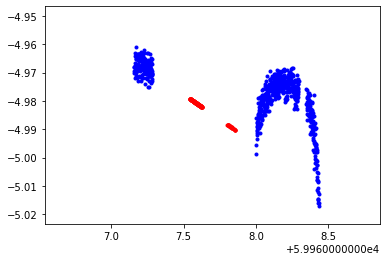

[-4.97846357 -4.97848861 -4.97851365 -4.97853869 -4.97856372 -4.97858876
 -4.9786138  -4.97863884 -4.97866387 -4.97868891 -4.97871395 -4.97873899
 -4.97876403 -4.97878906 -4.9788141  -4.97883914 -4.97886418 -4.97888922
 -4.97891425 -4.97893929 -4.97896433 -4.97898937 -4.9790144  -4.97903944
 -4.97906448 -4.97908952 -4.97911456 -4.97913959 -4.98440686 -4.9844319
 -4.98445694 -4.98448198 -4.98457075 -4.98461627 -4.9846618  -4.98470732
 -4.98485755 -4.98494404 -4.98503053 -4.98526726 -4.98531278 -4.9853583
 -4.98540382 -4.9854926  -4.98551764 -4.98554267 -4.98556771 -4.98565648
 -4.98570201 -4.98574753 -4.98579305 -4.98590231 -4.98594783 -4.98599336
 -4.98603888 -4.98612765 -4.98615269 -4.98617773 -4.98620277]


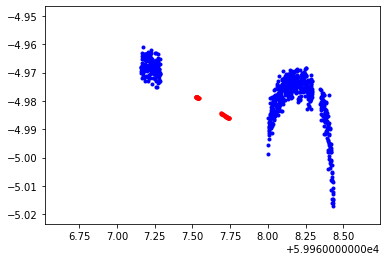

[-5.01613849 -5.01613866 -5.01613882 -5.01613899 -5.01613915 -5.01613932
 -5.01613949 -5.01613965 -5.01613982 -5.01613998 -5.01614015 -5.01614032
 -5.01614048 -5.01614065 -5.01614081 -5.01614098 -5.01614115 -5.01614131
 -5.01614148 -5.01614164 -5.01614181 -5.01614198 -5.01614214 -5.01614231
 -5.01614247 -5.01614264 -5.01614281 -5.01614297 -5.01614314 -5.0161433
 -5.01614347 -5.01614364 -5.0161438  -5.01614397 -5.01614413 -5.0161443
 -5.01614447 -5.01614463 -5.0161448  -5.01614496 -5.01614513 -5.0161453
 -5.01614546 -5.01614563 -5.01614579 -5.01614596 -5.01614613 -5.01614629
 -5.01614646 -5.01614662 -5.01614679 -5.01614696 -5.01614712 -5.01614729
 -5.01614745 -5.01614762 -5.01614779 -5.01614795 -5.01614812 -5.01614828
 -5.01614845 -5.01614861 -5.01614878 -5.01614895 -5.01614911 -5.01614928
 -5.01614944 -5.01614961 -5.01614978 -5.01614994 -5.01615011 -5.01615027
 -5.01615044 -5.01615061 -5.01615077 -5.01615094 -5.0161511  -5.01615127
 -5.01615144 -5.0161516  -5.01615177 -5.01615193 -5.01

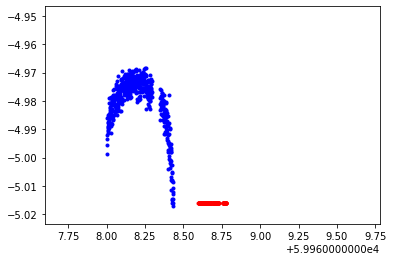

[-5.01639478 -5.01639508 -5.01639538 -5.01639568 -5.01639598 -5.01639628
 -5.01639659 -5.01639689 -5.01639719 -5.01639749 -5.01639779 -5.01639809
 -5.0163984  -5.0163996  -5.01639991 -5.01640021 -5.01640051 -5.01640081
 -5.01640111 -5.01640141 -5.01640172 -5.01640202 -5.01640232 -5.01640262
 -5.01640292 -5.01640323 -5.01640353 -5.01640383 -5.01640413 -5.01640443
 -5.01640473 -5.01640504 -5.01640534 -5.01640564 -5.01640594 -5.01640624
 -5.01640654 -5.01640701 -5.01640748 -5.01640795 -5.01640842 -5.01640888
 -5.01640935 -5.01640982 -5.01641029 -5.01641075 -5.01641122 -5.01641169
 -5.01641216 -5.01641263 -5.01641312 -5.01641359 -5.01641406 -5.01641453
 -5.016415   -5.01641546 -5.01641593 -5.0164164  -5.01641687 -5.01641733
 -5.0164178  -5.01641827 -5.01641874 -5.01641921 -5.01641967 -5.01642014
 -5.01642061 -5.01642108 -5.01642154 -5.01642201 -5.01642248 -5.01642295
 -5.01642342 -5.01642388 -5.01642435 -5.01642482 -5.01642529 -5.01642575
 -5.01642622 -5.01642669 -5.01642716 -5.01642763 -5

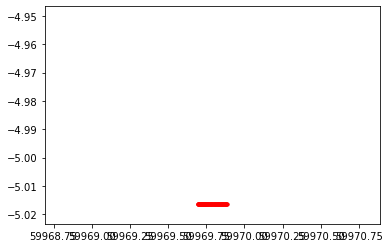

[-5.01659636 -5.01659653 -5.01659669 -5.01659686 -5.01659702 -5.01659719
 -5.01659736 -5.01659752 -5.01659769 -5.01659785 -5.01659802 -5.01659819
 -5.01659835 -5.01659852 -5.01659868 -5.01659885 -5.01659902 -5.01659918
 -5.01659935 -5.01659951 -5.01659968 -5.01659985 -5.01660001 -5.01660018
 -5.01660034 -5.01660051 -5.01660068 -5.01660084 -5.01660101 -5.01660117
 -5.01660134 -5.01660151 -5.01660167 -5.01660184 -5.016602   -5.01660217
 -5.01660234 -5.0166025  -5.01660267 -5.01660283 -5.016603   -5.01660317
 -5.01660333 -5.0166035  -5.01660366 -5.01660383 -5.016604   -5.01660416
 -5.01660433 -5.01660449 -5.01660466 -5.01660483 -5.01660499 -5.01660516
 -5.01660532 -5.01660549 -5.01660566 -5.01660582 -5.01660599 -5.01660615
 -5.01660632 -5.01660649 -5.01660665 -5.01660682 -5.01660698 -5.01660715
 -5.01660732 -5.01660748 -5.01660765 -5.01660781 -5.01660798 -5.01660815
 -5.01660831 -5.01660848 -5.01660864 -5.01660881 -5.01660898 -5.01660914
 -5.01660931 -5.01660947 -5.01660964 -5.0166098  -5

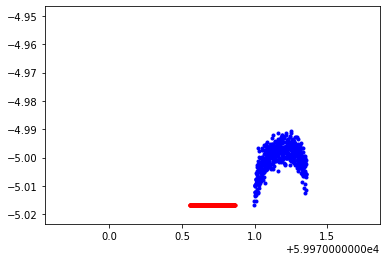

[-5.0054458  -5.00545865 -5.0054715  -5.00549719 -5.00551004 -5.00552288
 -5.00553573 -5.00554858 -5.00556142 -5.00557427 -5.00558712 -5.00559997
 -5.00561281 -5.00562566 -5.00563851 -5.00565135 -5.0056642  -5.00567705
 -5.00568989 -5.00570274 -5.00571559 -5.00572843 -5.00574128 -5.00575413
 -5.00576697 -5.00577982 -5.00579267 -5.00580552 -5.00581836 -5.00583121
 -5.00584406 -5.0058569  -5.00586975 -5.0058826  -5.00589544 -5.00590829
 -5.00592114 -5.00593398 -5.00594683 -5.00595968 -5.00597252 -5.00598537
 -5.00599822 -5.00601107 -5.00602391 -5.00603676 -5.00604961 -5.00606245
 -5.0060753  -5.00608815 -5.00610099 -5.00611384 -5.00612669 -5.00613953
 -5.00615238 -5.00616523 -5.00617807 -5.00619092 -5.00620377 -5.00621662
 -5.00622946 -5.00624231 -5.00625516 -5.006268   -5.00628085 -5.0062937
 -5.00630654 -5.00631939 -5.00633224 -5.00634508 -5.00635793 -5.00637078
 -5.00638362 -5.00639647 -5.00640932 -5.00642217 -5.00643501 -5.00644786
 -5.00646071 -5.00647355 -5.0064864  -5.00649925 -5.

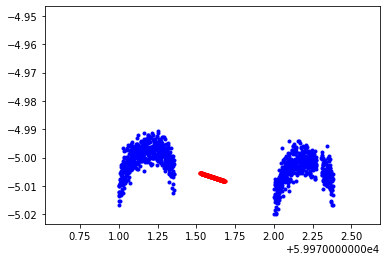

[-5.01364116 -5.01362886 -5.01361656 -5.01360426 -5.01359196 -5.01357967
 -5.01356737 -5.01355507 -5.01354277 -5.01353047 -5.01351817 -5.01350588
 -5.01349358 -5.01348128 -5.01346898 -5.01345668 -5.01344439 -5.01343209
 -5.01341979 -5.01340749 -5.01339519 -5.0133829  -5.0133706  -5.0133583
 -5.013346   -5.0133337  -5.0133214  -5.01330911 -5.01329681 -5.01328451
 -5.01327221 -5.01325991 -5.01324762 -5.01323532 -5.01322302 -5.01321072
 -5.01319842 -5.01318612 -5.01317383 -5.01316153 -5.01314923 -5.01313693
 -5.01312463 -5.01311234 -5.01310004 -5.01308774 -5.01307544 -5.01306314
 -5.01305085 -5.01303855 -5.01302625 -5.01301395 -5.01300165 -5.01298935
 -5.01297706 -5.01296476 -5.01295246 -5.01294016 -5.01292786 -5.01291557
 -5.01290327 -5.01289097 -5.01287867 -5.01286637 -5.01285408 -5.01284178
 -5.01282948 -5.01281718 -5.01280488 -5.01279258 -5.01278029 -5.01276799
 -5.01275569 -5.01274339 -5.01273109 -5.0127188  -5.0127065  -5.0126942
 -5.0126819  -5.0126696  -5.0126573  -5.01264501 -5.0

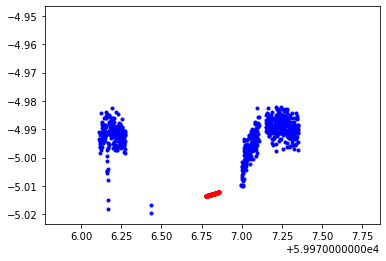

[-4.99776197 -4.99777115 -4.99778033 -4.99778952 -4.9977987  -4.99780788
 -4.99781707 -4.99782625 -4.99783543 -4.99784462 -4.9978538  -4.99786298
 -4.99787217 -4.99788135 -4.99789053 -4.99789972 -4.9979089  -4.99791808
 -4.99792727 -4.99793645 -4.99794563 -4.99795482 -4.997964   -4.99797318
 -4.99798237 -4.99799155 -4.99800073 -4.99800992 -4.9980191  -4.99802828
 -4.99803747 -4.99804665 -4.99805583 -4.99806502 -4.9980742  -4.99808338
 -4.99809257 -4.99810175 -4.99811093 -4.99812012 -4.9981293  -4.99813848
 -4.99814767 -4.99815685 -4.99816603 -4.99817522 -4.9981844  -4.99819358
 -4.99820277 -4.99821195 -4.99822113 -4.99823032 -4.9982395  -4.99824869
 -4.99825787 -4.99826705 -4.99827624 -4.99828542 -4.9982946  -4.99830379
 -4.99831297 -4.99832215 -4.99833134 -4.99834052 -4.9983497  -4.99835889
 -4.99836807 -4.99837725 -4.99838644 -4.99839562 -4.9984048  -4.99841399
 -4.99842317 -4.99843235 -4.99844154 -4.99845072 -4.9984599  -4.99846909
 -4.99847827 -4.99848745 -4.99849664 -4.99850582 -4

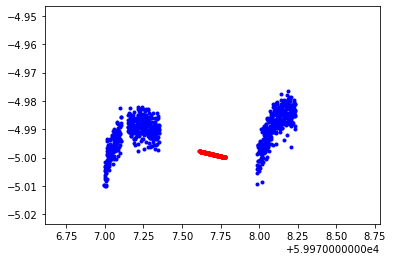

[-4.997149   -4.99716545 -4.9971819  -4.99719835 -4.9972148  -4.99723125
 -4.9972477  -4.99726415 -4.9972806  -4.99729706 -4.99731351 -4.99732996
 -4.99734641 -4.99736286 -4.99737931 -4.99739576 -4.99741221 -4.99742866
 -4.99744511 -4.99746156 -4.99747801 -4.99749446 -4.99751091 -4.99752736
 -4.99754381 -4.99756026 -4.99757671 -4.99759316 -4.99760961 -4.99762606
 -4.99764251 -4.99765896 -4.99767541 -4.99769186 -4.99770832 -4.99772477
 -4.99774122 -4.99775767 -4.99777412 -4.99779057 -4.99780702 -4.99782347
 -4.99783992 -4.99785637 -4.99787282 -4.99788927 -4.99790572 -4.99792217
 -4.99793862 -4.99795507 -4.99797152 -4.99798797 -4.99800442 -4.99802087
 -4.99803732 -4.99805377 -4.99807022 -4.99808667 -4.99810312 -4.99811957
 -4.99813603 -4.99815248 -4.99816893 -4.99818538 -4.99820183 -4.99821828
 -4.99823473 -4.99825118 -4.99826763 -4.99828408 -4.99830053 -4.99831698
 -4.99833343 -4.99834988 -4.99836633 -4.99838278 -4.99839923 -4.99841568
 -4.99843213 -4.99844858 -4.99846503 -4.99848148 -4

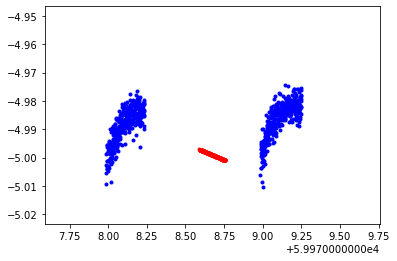

[-4.96619471 -4.96621054 -4.96622638 -4.96624221 -4.96625805 -4.96627388
 -4.96628971 -4.96630555 -4.96632138 -4.96633722 -4.96635305 -4.96636888
 -4.96638472 -4.96640055 -4.96641639 -4.96643222 -4.96644806 -4.96646389
 -4.96647972 -4.96649556 -4.96651139 -4.96652723 -4.96654306 -4.96655889
 -4.96657473 -4.96659056 -4.9666064  -4.96662223 -4.96663806 -4.9666539
 -4.96666973 -4.96668557 -4.9667014  -4.96671723 -4.96673307 -4.9667489
 -4.96676474 -4.96678057 -4.96679641 -4.96681224 -4.96682807 -4.96684391
 -4.96685974 -4.96687558 -4.96689141 -4.96690724 -4.96692308 -4.96693891
 -4.96695475 -4.96697058 -4.96698641 -4.96700225 -4.96701808 -4.96703392
 -4.96704975 -4.96706559 -4.96708142 -4.96709725 -4.96711309 -4.96712892
 -4.96714476 -4.96716059 -4.96717642 -4.96719226 -4.96720809 -4.96722393
 -4.96723976 -4.96725559 -4.96727143 -4.96728726 -4.9673031  -4.96731893
 -4.96733476 -4.9673506  -4.96736643 -4.96738227 -4.9673981  -4.96741394
 -4.96742977 -4.9674456  -4.96746144 -4.96747727 -4.9

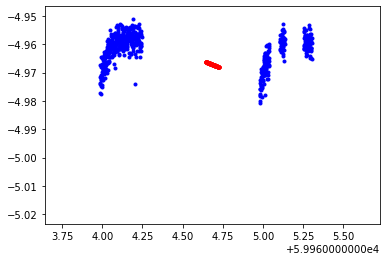

[-4.96814807 -4.9681639  -4.96817974 -4.96819557 -4.9682114  -4.96822724
 -4.96824307 -4.96825891 -4.96827474 -4.96829058 -4.96830641 -4.96832224
 -4.96833808 -4.96835391 -4.96836975 -4.96838558 -4.96840141 -4.96841725
 -4.96843308 -4.96844892 -4.96846475 -4.96848058 -4.96849642 -4.96851225
 -4.96852809 -4.96854392 -4.96855976 -4.96857559 -4.96859142 -4.96860726
 -4.96862309 -4.96863893 -4.96865476 -4.96867059 -4.96868643 -4.96870226
 -4.9687181  -4.96873393 -4.96874976 -4.9687656  -4.96878143 -4.96879727
 -4.9688131  -4.96882893 -4.96884477 -4.9688606  -4.96887644 -4.96889227
 -4.96890811 -4.96892394 -4.96893977 -4.96895561 -4.96897144 -4.96898728
 -4.96900311 -4.96901894 -4.96903478 -4.96905061 -4.96906645 -4.96908228
 -4.96909812 -4.96911395 -4.96912978 -4.96914562 -4.96916145 -4.96917729
 -4.96919312 -4.96920895 -4.96922479 -4.96924062 -4.96925646 -4.96927229
 -4.96928812 -4.96930396 -4.96931979 -4.96933563 -4.96935146 -4.9693673
 -4.96938313 -4.96939896 -4.9694148  -4.96943063 -4.

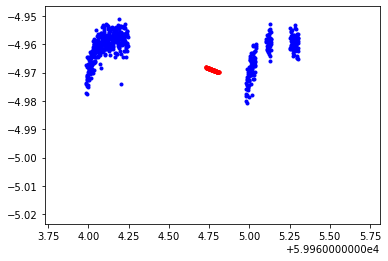

[-4.96620111 -4.96621283 -4.96622454 -4.96623625 -4.96624796 -4.96625967
 -4.96627138 -4.9662831  -4.96629481 -4.96630652 -4.96631823 -4.96632994
 -4.96634165 -4.96635337 -4.96636508 -4.96637679 -4.9663885  -4.96644706
 -4.96645877 -4.96647048 -4.96648219 -4.96649391 -4.96650562 -4.96651733
 -4.96652904 -4.96654075 -4.96655247 -4.96656418 -4.96657589 -4.9665876
 -4.96659931 -4.96661102 -4.96662274 -4.96663445 -4.96664616 -4.96665787
 -4.96666958 -4.96668129 -4.96669301 -4.96670472 -4.96671643 -4.96672814
 -4.96673985 -4.96675156 -4.96676328 -4.96677499 -4.9667867  -4.96679841
 -4.96681012 -4.96682183 -4.96683355 -4.96684526 -4.96685697 -4.96686868
 -4.96688039 -4.9668921  -4.96690382 -4.96691553 -4.96692724 -4.96693895
 -4.96695066 -4.96696237 -4.96697409 -4.9669858  -4.96699751 -4.96700922
 -4.96702093 -4.96703264 -4.96704436 -4.96705607 -4.96706778 -4.96707949
 -4.9670912  -4.96710291 -4.96711463 -4.96712634 -4.96713805 -4.96714976
 -4.96716147 -4.96717318 -4.9671849  -4.96719661 -4.

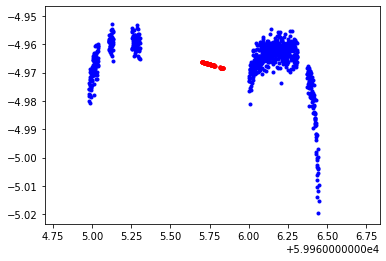

[-4.96327738 -4.96328909 -4.9633008  -4.96331251 -4.96332423 -4.96333594
 -4.96334765 -4.96335936 -4.96337107 -4.96338279 -4.9633945  -4.96340621
 -4.96341792 -4.96342963 -4.96344134 -4.96345306 -4.96346477 -4.96347648
 -4.96348819 -4.9634999  -4.96351161 -4.96352333 -4.96353504 -4.96354675
 -4.96355846 -4.96357017 -4.96358188 -4.9635936  -4.96360531 -4.96361702
 -4.96362873 -4.96364044 -4.96365215 -4.96366387 -4.96367558 -4.96368729
 -4.963699   -4.96371071 -4.96372242 -4.96373414 -4.96374585 -4.96375756
 -4.96376927 -4.96442732 -4.96443903 -4.96445074 -4.96446245 -4.96447417
 -4.96448588 -4.96449759 -4.9645093  -4.96452101 -4.96453272 -4.96454444
 -4.96455615 -4.96456786 -4.96457957 -4.96459128 -4.96460299 -4.96461471
 -4.96462642 -4.96463813 -4.96464984 -4.96466155 -4.96467326 -4.96468498
 -4.96469669 -4.9647084  -4.96472011 -4.96473182 -4.96474353 -4.96475525
 -4.96476696 -4.96477867 -4.96479038 -4.96480209 -4.9648138  -4.96482552
 -4.96483723 -4.96484894 -4.96486065 -4.96487236 -4

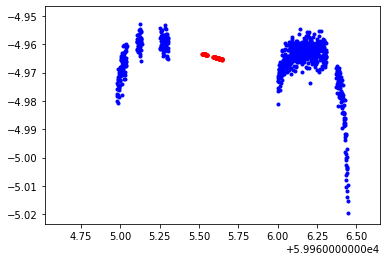

[-4.99844535 -4.99839833 -4.9983513  -4.99830428 -4.99825726 -4.99821023
 -4.99816321 -4.99811619 -4.99806917 -4.99802214 -4.99797512 -4.9979281
 -4.99788107 -4.99783405 -4.99778703 -4.99774001 -4.99750489 -4.99745787
 -4.99741085 -4.99736382 -4.9973168  -4.99726978 -4.99722275 -4.99717573
 -4.99712871 -4.99708169 -4.99703466 -4.99698764 -4.99694062 -4.99689359
 -4.99684657 -4.99679955 -4.99675253 -4.9967055  -4.99665848 -4.99661146
 -4.99656443 -4.99651741 -4.99647039 -4.99642337 -4.99637634 -4.99632932
 -4.99624809 -4.99620107 -4.99615405 -4.99610702 -4.9960258  -4.99597877
 -4.99593175 -4.99588473 -4.9958377  -4.99579068 -4.99574366 -4.99569664
 -4.99564961 -4.99560259 -4.99555557 -4.99550854 -4.99546152 -4.9954145
 -4.99536748 -4.99532045 -4.99527343 -4.99522641 -4.99517938 -4.99513236
 -4.99508534 -4.99503832 -4.99499129 -4.99494427 -4.9948032  -4.99475618
 -4.99470916 -4.99466213 -4.99461511 -4.99456809 -4.99452106 -4.99447404
 -4.99442702 -4.99438    -4.99433297 -4.99428595 -4.9

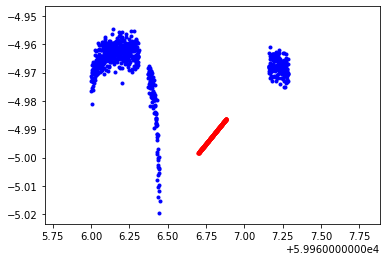

[-4.97921471 -4.97923975 -4.97926479 -4.97928982 -4.97931486 -4.9793399
 -4.97936494 -4.97938998 -4.97941501 -4.97944005 -4.97946509 -4.97949013
 -4.97951516 -4.9795402  -4.97956524 -4.97959028 -4.97961532 -4.97964035
 -4.97966539 -4.97969043 -4.97971547 -4.97974051 -4.97976554 -4.97979058
 -4.97981562 -4.97984066 -4.97986569 -4.97989073 -4.97991577 -4.97994081
 -4.97996585 -4.97999088 -4.98001592 -4.98004096 -4.980066   -4.98009103
 -4.98011607 -4.98014111 -4.98016615 -4.98019119 -4.98021622 -4.98024126
 -4.9802663  -4.98029134 -4.98031637 -4.98034141 -4.98036645 -4.98039149
 -4.98041653 -4.98044156 -4.9804666  -4.98049164 -4.98051668 -4.98054172
 -4.98056675 -4.98059179 -4.98061683 -4.98064187 -4.9806669  -4.98069194
 -4.98071698 -4.98074202 -4.98076706 -4.98079209 -4.98081713 -4.98084217
 -4.98086721 -4.98089224 -4.98091728 -4.98094232 -4.98096736 -4.9809924
 -4.98101743 -4.98104247 -4.98106751 -4.98109255 -4.98111759 -4.98114262
 -4.98116766 -4.9811927  -4.98121774 -4.98124277 -4.9

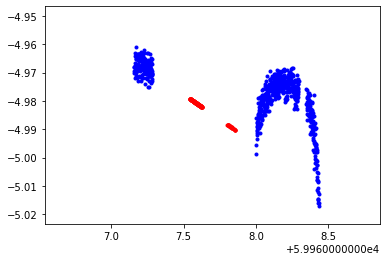

[-4.97846357 -4.97848861 -4.97851365 -4.97853869 -4.97856372 -4.97858876
 -4.9786138  -4.97863884 -4.97866387 -4.97868891 -4.97871395 -4.97873899
 -4.97876403 -4.97878906 -4.9788141  -4.97883914 -4.97886418 -4.97888922
 -4.97891425 -4.97893929 -4.97896433 -4.97898937 -4.9790144  -4.97903944
 -4.97906448 -4.97908952 -4.97911456 -4.97913959 -4.98440686 -4.9844319
 -4.98445694 -4.98448198 -4.98457075 -4.98461627 -4.9846618  -4.98470732
 -4.98485755 -4.98494404 -4.98503053 -4.98526726 -4.98531278 -4.9853583
 -4.98540382 -4.9854926  -4.98551764 -4.98554267 -4.98556771 -4.98565648
 -4.98570201 -4.98574753 -4.98579305 -4.98590231 -4.98594783 -4.98599336
 -4.98603888 -4.98612765 -4.98615269 -4.98617773 -4.98620277]


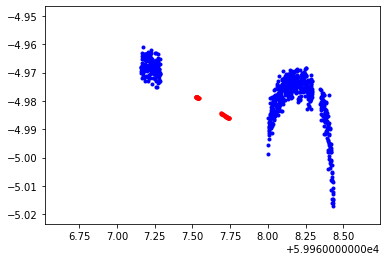

[-5.01613849 -5.01613866 -5.01613882 -5.01613899 -5.01613915 -5.01613932
 -5.01613949 -5.01613965 -5.01613982 -5.01613998 -5.01614015 -5.01614032
 -5.01614048 -5.01614065 -5.01614081 -5.01614098 -5.01614115 -5.01614131
 -5.01614148 -5.01614164 -5.01614181 -5.01614198 -5.01614214 -5.01614231
 -5.01614247 -5.01614264 -5.01614281 -5.01614297 -5.01614314 -5.0161433
 -5.01614347 -5.01614364 -5.0161438  -5.01614397 -5.01614413 -5.0161443
 -5.01614447 -5.01614463 -5.0161448  -5.01614496 -5.01614513 -5.0161453
 -5.01614546 -5.01614563 -5.01614579 -5.01614596 -5.01614613 -5.01614629
 -5.01614646 -5.01614662 -5.01614679 -5.01614696 -5.01614712 -5.01614729
 -5.01614745 -5.01614762 -5.01614779 -5.01614795 -5.01614812 -5.01614828
 -5.01614845 -5.01614861 -5.01614878 -5.01614895 -5.01614911 -5.01614928
 -5.01614944 -5.01614961 -5.01614978 -5.01614994 -5.01615011 -5.01615027
 -5.01615044 -5.01615061 -5.01615077 -5.01615094 -5.0161511  -5.01615127
 -5.01615144 -5.0161516  -5.01615177 -5.01615193 -5.01

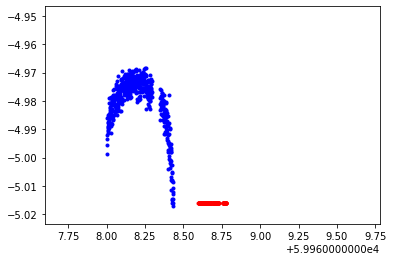

[-5.01639478 -5.01639508 -5.01639538 -5.01639568 -5.01639598 -5.01639628
 -5.01639659 -5.01639689 -5.01639719 -5.01639749 -5.01639779 -5.01639809
 -5.0163984  -5.0163996  -5.01639991 -5.01640021 -5.01640051 -5.01640081
 -5.01640111 -5.01640141 -5.01640172 -5.01640202 -5.01640232 -5.01640262
 -5.01640292 -5.01640323 -5.01640353 -5.01640383 -5.01640413 -5.01640443
 -5.01640473 -5.01640504 -5.01640534 -5.01640564 -5.01640594 -5.01640624
 -5.01640654 -5.01640701 -5.01640748 -5.01640795 -5.01640842 -5.01640888
 -5.01640935 -5.01640982 -5.01641029 -5.01641075 -5.01641122 -5.01641169
 -5.01641216 -5.01641263 -5.01641312 -5.01641359 -5.01641406 -5.01641453
 -5.016415   -5.01641546 -5.01641593 -5.0164164  -5.01641687 -5.01641733
 -5.0164178  -5.01641827 -5.01641874 -5.01641921 -5.01641967 -5.01642014
 -5.01642061 -5.01642108 -5.01642154 -5.01642201 -5.01642248 -5.01642295
 -5.01642342 -5.01642388 -5.01642435 -5.01642482 -5.01642529 -5.01642575
 -5.01642622 -5.01642669 -5.01642716 -5.01642763 -5

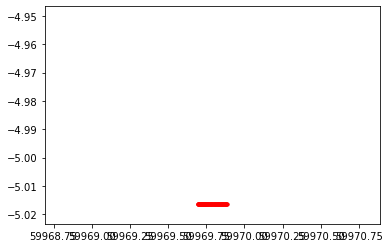

[-5.01659636 -5.01659653 -5.01659669 -5.01659686 -5.01659702 -5.01659719
 -5.01659736 -5.01659752 -5.01659769 -5.01659785 -5.01659802 -5.01659819
 -5.01659835 -5.01659852 -5.01659868 -5.01659885 -5.01659902 -5.01659918
 -5.01659935 -5.01659951 -5.01659968 -5.01659985 -5.01660001 -5.01660018
 -5.01660034 -5.01660051 -5.01660068 -5.01660084 -5.01660101 -5.01660117
 -5.01660134 -5.01660151 -5.01660167 -5.01660184 -5.016602   -5.01660217
 -5.01660234 -5.0166025  -5.01660267 -5.01660283 -5.016603   -5.01660317
 -5.01660333 -5.0166035  -5.01660366 -5.01660383 -5.016604   -5.01660416
 -5.01660433 -5.01660449 -5.01660466 -5.01660483 -5.01660499 -5.01660516
 -5.01660532 -5.01660549 -5.01660566 -5.01660582 -5.01660599 -5.01660615
 -5.01660632 -5.01660649 -5.01660665 -5.01660682 -5.01660698 -5.01660715
 -5.01660732 -5.01660748 -5.01660765 -5.01660781 -5.01660798 -5.01660815
 -5.01660831 -5.01660848 -5.01660864 -5.01660881 -5.01660898 -5.01660914
 -5.01660931 -5.01660947 -5.01660964 -5.0166098  -5

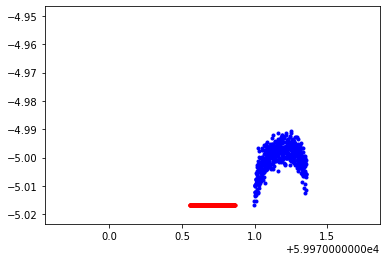

[-5.0054458  -5.00545865 -5.0054715  -5.00549719 -5.00551004 -5.00552288
 -5.00553573 -5.00554858 -5.00556142 -5.00557427 -5.00558712 -5.00559997
 -5.00561281 -5.00562566 -5.00563851 -5.00565135 -5.0056642  -5.00567705
 -5.00568989 -5.00570274 -5.00571559 -5.00572843 -5.00574128 -5.00575413
 -5.00576697 -5.00577982 -5.00579267 -5.00580552 -5.00581836 -5.00583121
 -5.00584406 -5.0058569  -5.00586975 -5.0058826  -5.00589544 -5.00590829
 -5.00592114 -5.00593398 -5.00594683 -5.00595968 -5.00597252 -5.00598537
 -5.00599822 -5.00601107 -5.00602391 -5.00603676 -5.00604961 -5.00606245
 -5.0060753  -5.00608815 -5.00610099 -5.00611384 -5.00612669 -5.00613953
 -5.00615238 -5.00616523 -5.00617807 -5.00619092 -5.00620377 -5.00621662
 -5.00622946 -5.00624231 -5.00625516 -5.006268   -5.00628085 -5.0062937
 -5.00630654 -5.00631939 -5.00633224 -5.00634508 -5.00635793 -5.00637078
 -5.00638362 -5.00639647 -5.00640932 -5.00642217 -5.00643501 -5.00644786
 -5.00646071 -5.00647355 -5.0064864  -5.00649925 -5.

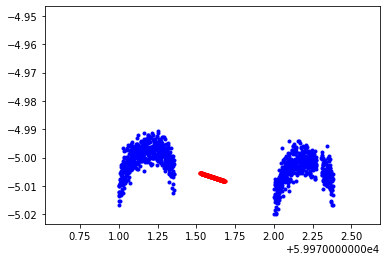

[-5.01364116 -5.01362886 -5.01361656 -5.01360426 -5.01359196 -5.01357967
 -5.01356737 -5.01355507 -5.01354277 -5.01353047 -5.01351817 -5.01350588
 -5.01349358 -5.01348128 -5.01346898 -5.01345668 -5.01344439 -5.01343209
 -5.01341979 -5.01340749 -5.01339519 -5.0133829  -5.0133706  -5.0133583
 -5.013346   -5.0133337  -5.0133214  -5.01330911 -5.01329681 -5.01328451
 -5.01327221 -5.01325991 -5.01324762 -5.01323532 -5.01322302 -5.01321072
 -5.01319842 -5.01318612 -5.01317383 -5.01316153 -5.01314923 -5.01313693
 -5.01312463 -5.01311234 -5.01310004 -5.01308774 -5.01307544 -5.01306314
 -5.01305085 -5.01303855 -5.01302625 -5.01301395 -5.01300165 -5.01298935
 -5.01297706 -5.01296476 -5.01295246 -5.01294016 -5.01292786 -5.01291557
 -5.01290327 -5.01289097 -5.01287867 -5.01286637 -5.01285408 -5.01284178
 -5.01282948 -5.01281718 -5.01280488 -5.01279258 -5.01278029 -5.01276799
 -5.01275569 -5.01274339 -5.01273109 -5.0127188  -5.0127065  -5.0126942
 -5.0126819  -5.0126696  -5.0126573  -5.01264501 -5.0

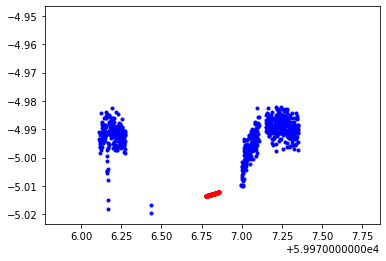

[-4.99776197 -4.99777115 -4.99778033 -4.99778952 -4.9977987  -4.99780788
 -4.99781707 -4.99782625 -4.99783543 -4.99784462 -4.9978538  -4.99786298
 -4.99787217 -4.99788135 -4.99789053 -4.99789972 -4.9979089  -4.99791808
 -4.99792727 -4.99793645 -4.99794563 -4.99795482 -4.997964   -4.99797318
 -4.99798237 -4.99799155 -4.99800073 -4.99800992 -4.9980191  -4.99802828
 -4.99803747 -4.99804665 -4.99805583 -4.99806502 -4.9980742  -4.99808338
 -4.99809257 -4.99810175 -4.99811093 -4.99812012 -4.9981293  -4.99813848
 -4.99814767 -4.99815685 -4.99816603 -4.99817522 -4.9981844  -4.99819358
 -4.99820277 -4.99821195 -4.99822113 -4.99823032 -4.9982395  -4.99824869
 -4.99825787 -4.99826705 -4.99827624 -4.99828542 -4.9982946  -4.99830379
 -4.99831297 -4.99832215 -4.99833134 -4.99834052 -4.9983497  -4.99835889
 -4.99836807 -4.99837725 -4.99838644 -4.99839562 -4.9984048  -4.99841399
 -4.99842317 -4.99843235 -4.99844154 -4.99845072 -4.9984599  -4.99846909
 -4.99847827 -4.99848745 -4.99849664 -4.99850582 -4

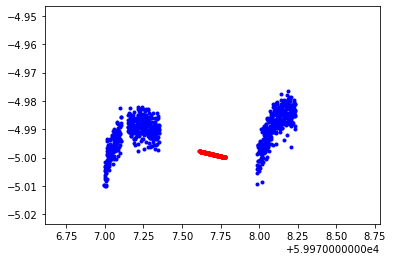

[-4.997149   -4.99716545 -4.9971819  -4.99719835 -4.9972148  -4.99723125
 -4.9972477  -4.99726415 -4.9972806  -4.99729706 -4.99731351 -4.99732996
 -4.99734641 -4.99736286 -4.99737931 -4.99739576 -4.99741221 -4.99742866
 -4.99744511 -4.99746156 -4.99747801 -4.99749446 -4.99751091 -4.99752736
 -4.99754381 -4.99756026 -4.99757671 -4.99759316 -4.99760961 -4.99762606
 -4.99764251 -4.99765896 -4.99767541 -4.99769186 -4.99770832 -4.99772477
 -4.99774122 -4.99775767 -4.99777412 -4.99779057 -4.99780702 -4.99782347
 -4.99783992 -4.99785637 -4.99787282 -4.99788927 -4.99790572 -4.99792217
 -4.99793862 -4.99795507 -4.99797152 -4.99798797 -4.99800442 -4.99802087
 -4.99803732 -4.99805377 -4.99807022 -4.99808667 -4.99810312 -4.99811957
 -4.99813603 -4.99815248 -4.99816893 -4.99818538 -4.99820183 -4.99821828
 -4.99823473 -4.99825118 -4.99826763 -4.99828408 -4.99830053 -4.99831698
 -4.99833343 -4.99834988 -4.99836633 -4.99838278 -4.99839923 -4.99841568
 -4.99843213 -4.99844858 -4.99846503 -4.99848148 -4

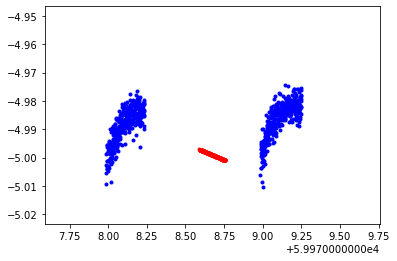

[-4.96619471 -4.96621054 -4.96622638 -4.96624221 -4.96625805 -4.96627388
 -4.96628971 -4.96630555 -4.96632138 -4.96633722 -4.96635305 -4.96636888
 -4.96638472 -4.96640055 -4.96641639 -4.96643222 -4.96644806 -4.96646389
 -4.96647972 -4.96649556 -4.96651139 -4.96652723 -4.96654306 -4.96655889
 -4.96657473 -4.96659056 -4.9666064  -4.96662223 -4.96663806 -4.9666539
 -4.96666973 -4.96668557 -4.9667014  -4.96671723 -4.96673307 -4.9667489
 -4.96676474 -4.96678057 -4.96679641 -4.96681224 -4.96682807 -4.96684391
 -4.96685974 -4.96687558 -4.96689141 -4.96690724 -4.96692308 -4.96693891
 -4.96695475 -4.96697058 -4.96698641 -4.96700225 -4.96701808 -4.96703392
 -4.96704975 -4.96706559 -4.96708142 -4.96709725 -4.96711309 -4.96712892
 -4.96714476 -4.96716059 -4.96717642 -4.96719226 -4.96720809 -4.96722393
 -4.96723976 -4.96725559 -4.96727143 -4.96728726 -4.9673031  -4.96731893
 -4.96733476 -4.9673506  -4.96736643 -4.96738227 -4.9673981  -4.96741394
 -4.96742977 -4.9674456  -4.96746144 -4.96747727 -4.9

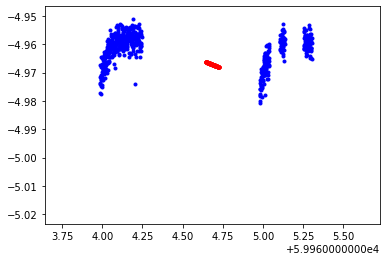

[-4.96814807 -4.9681639  -4.96817974 -4.96819557 -4.9682114  -4.96822724
 -4.96824307 -4.96825891 -4.96827474 -4.96829058 -4.96830641 -4.96832224
 -4.96833808 -4.96835391 -4.96836975 -4.96838558 -4.96840141 -4.96841725
 -4.96843308 -4.96844892 -4.96846475 -4.96848058 -4.96849642 -4.96851225
 -4.96852809 -4.96854392 -4.96855976 -4.96857559 -4.96859142 -4.96860726
 -4.96862309 -4.96863893 -4.96865476 -4.96867059 -4.96868643 -4.96870226
 -4.9687181  -4.96873393 -4.96874976 -4.9687656  -4.96878143 -4.96879727
 -4.9688131  -4.96882893 -4.96884477 -4.9688606  -4.96887644 -4.96889227
 -4.96890811 -4.96892394 -4.96893977 -4.96895561 -4.96897144 -4.96898728
 -4.96900311 -4.96901894 -4.96903478 -4.96905061 -4.96906645 -4.96908228
 -4.96909812 -4.96911395 -4.96912978 -4.96914562 -4.96916145 -4.96917729
 -4.96919312 -4.96920895 -4.96922479 -4.96924062 -4.96925646 -4.96927229
 -4.96928812 -4.96930396 -4.96931979 -4.96933563 -4.96935146 -4.9693673
 -4.96938313 -4.96939896 -4.9694148  -4.96943063 -4.

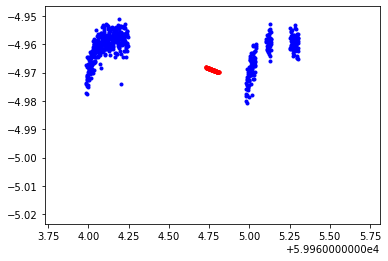

[-4.96620111 -4.96621283 -4.96622454 -4.96623625 -4.96624796 -4.96625967
 -4.96627138 -4.9662831  -4.96629481 -4.96630652 -4.96631823 -4.96632994
 -4.96634165 -4.96635337 -4.96636508 -4.96637679 -4.9663885  -4.96644706
 -4.96645877 -4.96647048 -4.96648219 -4.96649391 -4.96650562 -4.96651733
 -4.96652904 -4.96654075 -4.96655247 -4.96656418 -4.96657589 -4.9665876
 -4.96659931 -4.96661102 -4.96662274 -4.96663445 -4.96664616 -4.96665787
 -4.96666958 -4.96668129 -4.96669301 -4.96670472 -4.96671643 -4.96672814
 -4.96673985 -4.96675156 -4.96676328 -4.96677499 -4.9667867  -4.96679841
 -4.96681012 -4.96682183 -4.96683355 -4.96684526 -4.96685697 -4.96686868
 -4.96688039 -4.9668921  -4.96690382 -4.96691553 -4.96692724 -4.96693895
 -4.96695066 -4.96696237 -4.96697409 -4.9669858  -4.96699751 -4.96700922
 -4.96702093 -4.96703264 -4.96704436 -4.96705607 -4.96706778 -4.96707949
 -4.9670912  -4.96710291 -4.96711463 -4.96712634 -4.96713805 -4.96714976
 -4.96716147 -4.96717318 -4.9671849  -4.96719661 -4.

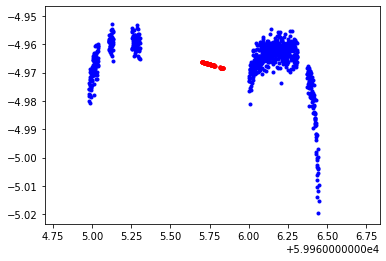

[-4.96327738 -4.96328909 -4.9633008  -4.96331251 -4.96332423 -4.96333594
 -4.96334765 -4.96335936 -4.96337107 -4.96338279 -4.9633945  -4.96340621
 -4.96341792 -4.96342963 -4.96344134 -4.96345306 -4.96346477 -4.96347648
 -4.96348819 -4.9634999  -4.96351161 -4.96352333 -4.96353504 -4.96354675
 -4.96355846 -4.96357017 -4.96358188 -4.9635936  -4.96360531 -4.96361702
 -4.96362873 -4.96364044 -4.96365215 -4.96366387 -4.96367558 -4.96368729
 -4.963699   -4.96371071 -4.96372242 -4.96373414 -4.96374585 -4.96375756
 -4.96376927 -4.96442732 -4.96443903 -4.96445074 -4.96446245 -4.96447417
 -4.96448588 -4.96449759 -4.9645093  -4.96452101 -4.96453272 -4.96454444
 -4.96455615 -4.96456786 -4.96457957 -4.96459128 -4.96460299 -4.96461471
 -4.96462642 -4.96463813 -4.96464984 -4.96466155 -4.96467326 -4.96468498
 -4.96469669 -4.9647084  -4.96472011 -4.96473182 -4.96474353 -4.96475525
 -4.96476696 -4.96477867 -4.96479038 -4.96480209 -4.9648138  -4.96482552
 -4.96483723 -4.96484894 -4.96486065 -4.96487236 -4

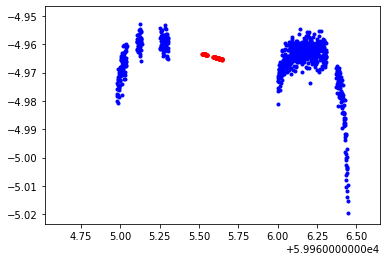

[-4.99844535 -4.99839833 -4.9983513  -4.99830428 -4.99825726 -4.99821023
 -4.99816321 -4.99811619 -4.99806917 -4.99802214 -4.99797512 -4.9979281
 -4.99788107 -4.99783405 -4.99778703 -4.99774001 -4.99750489 -4.99745787
 -4.99741085 -4.99736382 -4.9973168  -4.99726978 -4.99722275 -4.99717573
 -4.99712871 -4.99708169 -4.99703466 -4.99698764 -4.99694062 -4.99689359
 -4.99684657 -4.99679955 -4.99675253 -4.9967055  -4.99665848 -4.99661146
 -4.99656443 -4.99651741 -4.99647039 -4.99642337 -4.99637634 -4.99632932
 -4.99624809 -4.99620107 -4.99615405 -4.99610702 -4.9960258  -4.99597877
 -4.99593175 -4.99588473 -4.9958377  -4.99579068 -4.99574366 -4.99569664
 -4.99564961 -4.99560259 -4.99555557 -4.99550854 -4.99546152 -4.9954145
 -4.99536748 -4.99532045 -4.99527343 -4.99522641 -4.99517938 -4.99513236
 -4.99508534 -4.99503832 -4.99499129 -4.99494427 -4.9948032  -4.99475618
 -4.99470916 -4.99466213 -4.99461511 -4.99456809 -4.99452106 -4.99447404
 -4.99442702 -4.99438    -4.99433297 -4.99428595 -4.9

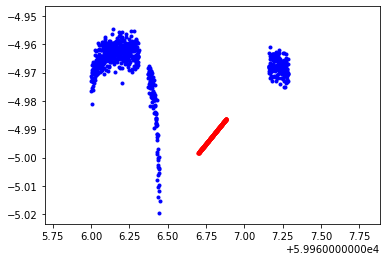

[-4.97921471 -4.97923975 -4.97926479 -4.97928982 -4.97931486 -4.9793399
 -4.97936494 -4.97938998 -4.97941501 -4.97944005 -4.97946509 -4.97949013
 -4.97951516 -4.9795402  -4.97956524 -4.97959028 -4.97961532 -4.97964035
 -4.97966539 -4.97969043 -4.97971547 -4.97974051 -4.97976554 -4.97979058
 -4.97981562 -4.97984066 -4.97986569 -4.97989073 -4.97991577 -4.97994081
 -4.97996585 -4.97999088 -4.98001592 -4.98004096 -4.980066   -4.98009103
 -4.98011607 -4.98014111 -4.98016615 -4.98019119 -4.98021622 -4.98024126
 -4.9802663  -4.98029134 -4.98031637 -4.98034141 -4.98036645 -4.98039149
 -4.98041653 -4.98044156 -4.9804666  -4.98049164 -4.98051668 -4.98054172
 -4.98056675 -4.98059179 -4.98061683 -4.98064187 -4.9806669  -4.98069194
 -4.98071698 -4.98074202 -4.98076706 -4.98079209 -4.98081713 -4.98084217
 -4.98086721 -4.98089224 -4.98091728 -4.98094232 -4.98096736 -4.9809924
 -4.98101743 -4.98104247 -4.98106751 -4.98109255 -4.98111759 -4.98114262
 -4.98116766 -4.9811927  -4.98121774 -4.98124277 -4.9

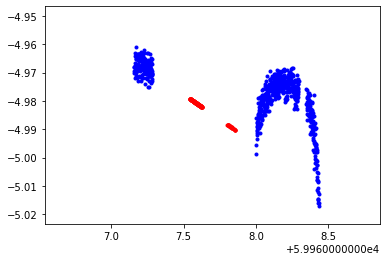

[-4.97846357 -4.97848861 -4.97851365 -4.97853869 -4.97856372 -4.97858876
 -4.9786138  -4.97863884 -4.97866387 -4.97868891 -4.97871395 -4.97873899
 -4.97876403 -4.97878906 -4.9788141  -4.97883914 -4.97886418 -4.97888922
 -4.97891425 -4.97893929 -4.97896433 -4.97898937 -4.9790144  -4.97903944
 -4.97906448 -4.97908952 -4.97911456 -4.97913959 -4.98440686 -4.9844319
 -4.98445694 -4.98448198 -4.98457075 -4.98461627 -4.9846618  -4.98470732
 -4.98485755 -4.98494404 -4.98503053 -4.98526726 -4.98531278 -4.9853583
 -4.98540382 -4.9854926  -4.98551764 -4.98554267 -4.98556771 -4.98565648
 -4.98570201 -4.98574753 -4.98579305 -4.98590231 -4.98594783 -4.98599336
 -4.98603888 -4.98612765 -4.98615269 -4.98617773 -4.98620277]


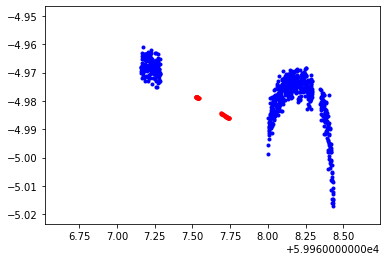

[-5.01613849 -5.01613866 -5.01613882 -5.01613899 -5.01613915 -5.01613932
 -5.01613949 -5.01613965 -5.01613982 -5.01613998 -5.01614015 -5.01614032
 -5.01614048 -5.01614065 -5.01614081 -5.01614098 -5.01614115 -5.01614131
 -5.01614148 -5.01614164 -5.01614181 -5.01614198 -5.01614214 -5.01614231
 -5.01614247 -5.01614264 -5.01614281 -5.01614297 -5.01614314 -5.0161433
 -5.01614347 -5.01614364 -5.0161438  -5.01614397 -5.01614413 -5.0161443
 -5.01614447 -5.01614463 -5.0161448  -5.01614496 -5.01614513 -5.0161453
 -5.01614546 -5.01614563 -5.01614579 -5.01614596 -5.01614613 -5.01614629
 -5.01614646 -5.01614662 -5.01614679 -5.01614696 -5.01614712 -5.01614729
 -5.01614745 -5.01614762 -5.01614779 -5.01614795 -5.01614812 -5.01614828
 -5.01614845 -5.01614861 -5.01614878 -5.01614895 -5.01614911 -5.01614928
 -5.01614944 -5.01614961 -5.01614978 -5.01614994 -5.01615011 -5.01615027
 -5.01615044 -5.01615061 -5.01615077 -5.01615094 -5.0161511  -5.01615127
 -5.01615144 -5.0161516  -5.01615177 -5.01615193 -5.01

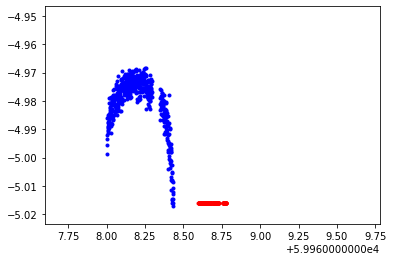

[-5.01639478 -5.01639508 -5.01639538 -5.01639568 -5.01639598 -5.01639628
 -5.01639659 -5.01639689 -5.01639719 -5.01639749 -5.01639779 -5.01639809
 -5.0163984  -5.0163996  -5.01639991 -5.01640021 -5.01640051 -5.01640081
 -5.01640111 -5.01640141 -5.01640172 -5.01640202 -5.01640232 -5.01640262
 -5.01640292 -5.01640323 -5.01640353 -5.01640383 -5.01640413 -5.01640443
 -5.01640473 -5.01640504 -5.01640534 -5.01640564 -5.01640594 -5.01640624
 -5.01640654 -5.01640701 -5.01640748 -5.01640795 -5.01640842 -5.01640888
 -5.01640935 -5.01640982 -5.01641029 -5.01641075 -5.01641122 -5.01641169
 -5.01641216 -5.01641263 -5.01641312 -5.01641359 -5.01641406 -5.01641453
 -5.016415   -5.01641546 -5.01641593 -5.0164164  -5.01641687 -5.01641733
 -5.0164178  -5.01641827 -5.01641874 -5.01641921 -5.01641967 -5.01642014
 -5.01642061 -5.01642108 -5.01642154 -5.01642201 -5.01642248 -5.01642295
 -5.01642342 -5.01642388 -5.01642435 -5.01642482 -5.01642529 -5.01642575
 -5.01642622 -5.01642669 -5.01642716 -5.01642763 -5

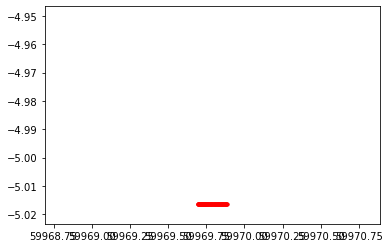

[-5.01659636 -5.01659653 -5.01659669 -5.01659686 -5.01659702 -5.01659719
 -5.01659736 -5.01659752 -5.01659769 -5.01659785 -5.01659802 -5.01659819
 -5.01659835 -5.01659852 -5.01659868 -5.01659885 -5.01659902 -5.01659918
 -5.01659935 -5.01659951 -5.01659968 -5.01659985 -5.01660001 -5.01660018
 -5.01660034 -5.01660051 -5.01660068 -5.01660084 -5.01660101 -5.01660117
 -5.01660134 -5.01660151 -5.01660167 -5.01660184 -5.016602   -5.01660217
 -5.01660234 -5.0166025  -5.01660267 -5.01660283 -5.016603   -5.01660317
 -5.01660333 -5.0166035  -5.01660366 -5.01660383 -5.016604   -5.01660416
 -5.01660433 -5.01660449 -5.01660466 -5.01660483 -5.01660499 -5.01660516
 -5.01660532 -5.01660549 -5.01660566 -5.01660582 -5.01660599 -5.01660615
 -5.01660632 -5.01660649 -5.01660665 -5.01660682 -5.01660698 -5.01660715
 -5.01660732 -5.01660748 -5.01660765 -5.01660781 -5.01660798 -5.01660815
 -5.01660831 -5.01660848 -5.01660864 -5.01660881 -5.01660898 -5.01660914
 -5.01660931 -5.01660947 -5.01660964 -5.0166098  -5

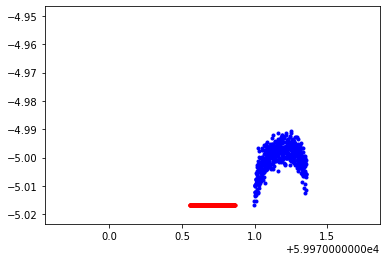

[-5.0054458  -5.00545865 -5.0054715  -5.00549719 -5.00551004 -5.00552288
 -5.00553573 -5.00554858 -5.00556142 -5.00557427 -5.00558712 -5.00559997
 -5.00561281 -5.00562566 -5.00563851 -5.00565135 -5.0056642  -5.00567705
 -5.00568989 -5.00570274 -5.00571559 -5.00572843 -5.00574128 -5.00575413
 -5.00576697 -5.00577982 -5.00579267 -5.00580552 -5.00581836 -5.00583121
 -5.00584406 -5.0058569  -5.00586975 -5.0058826  -5.00589544 -5.00590829
 -5.00592114 -5.00593398 -5.00594683 -5.00595968 -5.00597252 -5.00598537
 -5.00599822 -5.00601107 -5.00602391 -5.00603676 -5.00604961 -5.00606245
 -5.0060753  -5.00608815 -5.00610099 -5.00611384 -5.00612669 -5.00613953
 -5.00615238 -5.00616523 -5.00617807 -5.00619092 -5.00620377 -5.00621662
 -5.00622946 -5.00624231 -5.00625516 -5.006268   -5.00628085 -5.0062937
 -5.00630654 -5.00631939 -5.00633224 -5.00634508 -5.00635793 -5.00637078
 -5.00638362 -5.00639647 -5.00640932 -5.00642217 -5.00643501 -5.00644786
 -5.00646071 -5.00647355 -5.0064864  -5.00649925 -5.

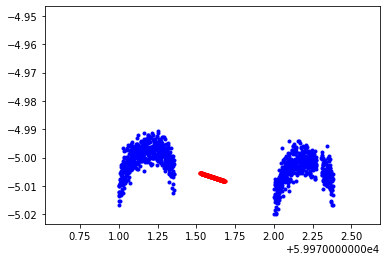

[-5.01364116 -5.01362886 -5.01361656 -5.01360426 -5.01359196 -5.01357967
 -5.01356737 -5.01355507 -5.01354277 -5.01353047 -5.01351817 -5.01350588
 -5.01349358 -5.01348128 -5.01346898 -5.01345668 -5.01344439 -5.01343209
 -5.01341979 -5.01340749 -5.01339519 -5.0133829  -5.0133706  -5.0133583
 -5.013346   -5.0133337  -5.0133214  -5.01330911 -5.01329681 -5.01328451
 -5.01327221 -5.01325991 -5.01324762 -5.01323532 -5.01322302 -5.01321072
 -5.01319842 -5.01318612 -5.01317383 -5.01316153 -5.01314923 -5.01313693
 -5.01312463 -5.01311234 -5.01310004 -5.01308774 -5.01307544 -5.01306314
 -5.01305085 -5.01303855 -5.01302625 -5.01301395 -5.01300165 -5.01298935
 -5.01297706 -5.01296476 -5.01295246 -5.01294016 -5.01292786 -5.01291557
 -5.01290327 -5.01289097 -5.01287867 -5.01286637 -5.01285408 -5.01284178
 -5.01282948 -5.01281718 -5.01280488 -5.01279258 -5.01278029 -5.01276799
 -5.01275569 -5.01274339 -5.01273109 -5.0127188  -5.0127065  -5.0126942
 -5.0126819  -5.0126696  -5.0126573  -5.01264501 -5.0

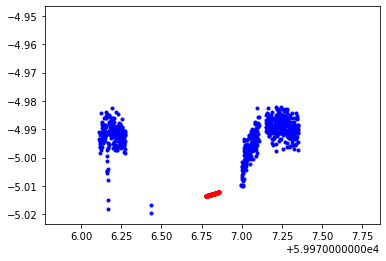

[-4.99776197 -4.99777115 -4.99778033 -4.99778952 -4.9977987  -4.99780788
 -4.99781707 -4.99782625 -4.99783543 -4.99784462 -4.9978538  -4.99786298
 -4.99787217 -4.99788135 -4.99789053 -4.99789972 -4.9979089  -4.99791808
 -4.99792727 -4.99793645 -4.99794563 -4.99795482 -4.997964   -4.99797318
 -4.99798237 -4.99799155 -4.99800073 -4.99800992 -4.9980191  -4.99802828
 -4.99803747 -4.99804665 -4.99805583 -4.99806502 -4.9980742  -4.99808338
 -4.99809257 -4.99810175 -4.99811093 -4.99812012 -4.9981293  -4.99813848
 -4.99814767 -4.99815685 -4.99816603 -4.99817522 -4.9981844  -4.99819358
 -4.99820277 -4.99821195 -4.99822113 -4.99823032 -4.9982395  -4.99824869
 -4.99825787 -4.99826705 -4.99827624 -4.99828542 -4.9982946  -4.99830379
 -4.99831297 -4.99832215 -4.99833134 -4.99834052 -4.9983497  -4.99835889
 -4.99836807 -4.99837725 -4.99838644 -4.99839562 -4.9984048  -4.99841399
 -4.99842317 -4.99843235 -4.99844154 -4.99845072 -4.9984599  -4.99846909
 -4.99847827 -4.99848745 -4.99849664 -4.99850582 -4

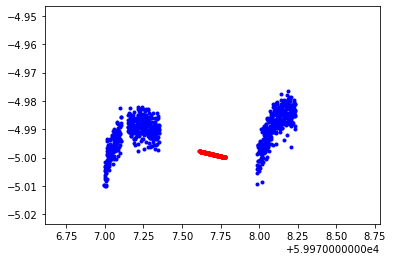

[-4.997149   -4.99716545 -4.9971819  -4.99719835 -4.9972148  -4.99723125
 -4.9972477  -4.99726415 -4.9972806  -4.99729706 -4.99731351 -4.99732996
 -4.99734641 -4.99736286 -4.99737931 -4.99739576 -4.99741221 -4.99742866
 -4.99744511 -4.99746156 -4.99747801 -4.99749446 -4.99751091 -4.99752736
 -4.99754381 -4.99756026 -4.99757671 -4.99759316 -4.99760961 -4.99762606
 -4.99764251 -4.99765896 -4.99767541 -4.99769186 -4.99770832 -4.99772477
 -4.99774122 -4.99775767 -4.99777412 -4.99779057 -4.99780702 -4.99782347
 -4.99783992 -4.99785637 -4.99787282 -4.99788927 -4.99790572 -4.99792217
 -4.99793862 -4.99795507 -4.99797152 -4.99798797 -4.99800442 -4.99802087
 -4.99803732 -4.99805377 -4.99807022 -4.99808667 -4.99810312 -4.99811957
 -4.99813603 -4.99815248 -4.99816893 -4.99818538 -4.99820183 -4.99821828
 -4.99823473 -4.99825118 -4.99826763 -4.99828408 -4.99830053 -4.99831698
 -4.99833343 -4.99834988 -4.99836633 -4.99838278 -4.99839923 -4.99841568
 -4.99843213 -4.99844858 -4.99846503 -4.99848148 -4

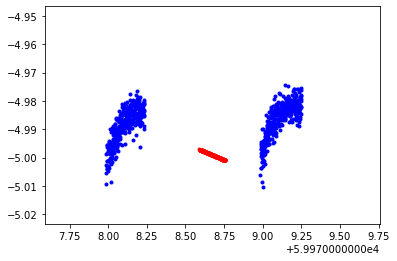

In [111]:
#Looping over each parameter. For each loop we extract interpolate the 



for i in range(len(params_of_interest)):
    long_param = []
    long_param_err = []
    long_time = []
    
    long_rhk = []
    long_rhk_err = []

    # Loop over the keys and values in the fit_params_dict dictionary
    for day in param_dictionnary:
        key_list = list(param_dictionnary.keys())

        index = key_list.index(day)

        param_list = [param[indexes_of_interest[i]] for param in param_dictionnary[day]]
        err_list = [err[indexes_of_interest[i]] for err in err_dictionnary[day]]
        time_list = [time for time in time_dictionnary[day]]

        long_param.append(param_list)
        long_param_err.append(err_list)
        long_time.append(time_list)
    
        interpol_rhk_function = interp1d(rhk_BJD_date, rhk)
        interpol_rhk = interpol_rhk_function(time_list)
        long_rhk.append(interpol_rhk)
        print(interpol_rhk)
        plt.plot(rhk_BJD_date, rhk, 'b.')
        plt.plot(time_list, interpol_rhk, 'r.')
        plt.xlim(time_list[0]-1, time_list[-1]+1)
        plt.show()